# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

files = [file_obs, file_sig, file_ZTT, file_TT]

In [3]:
# 2b events
for i in range(len(files)):
    files[i] = files[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184')\
    .Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4184')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_2,beta_deepcsv_2,bphi_deepcsv_2,bm_deepcsv_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2mu = '(mymu+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbmu = '(myb1+myb2+mymu).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbmu = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'


# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'


# add defined variables to dataframe
for i in range(len(files)):
    files[i] = files[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
# 2018 mu+tau trigger requirements
trigger24OR27 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc = trigger24OR27 + str(' or ') + trigger2027HPS
trigger_obs_1 = trigger2027 + str(' or ') + trigger24OR27
trigger_obs_2 = trigger2027HPS + str(' or ') + trigger24OR27
trigger_emb = trigger24OR27_emb + str(' or ') + trigger2027HPS_emb


for i in range(len(files)):
    files[i] = files[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files[0] = files[0].Filter('Flag_eeBadScFilter==0')
files[2] = files[2].Filter('Flag_eeBadScFilter==0')

files[3] = files[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

#files[1] = files[1].Filter('gen_match_2!=6')
files[1] = files[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files[1] = files[1].Filter('m_b1tt<250')#reject long tail (mostly wrongly reco b jet)

#####for 2b only, remove long tails to reject wrongly reco b jet
files[1] = files[1].Filter('m_bbtt<300').Filter('m_bb<150').Filter('dm_a<1.3')

files[2] = files[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1 = files[0].Filter('run<317509').Filter(trigger_obs_1)
obs2 = files[0].Filter('run>=317509').Filter(trigger_obs_2)
files[1] = files[1].Filter(trigger_mc)
files[2] = files[2].Filter(trigger_emb)
files[3] = files[3].Filter(trigger_mc)

# QCD region
qcd1 = obs1.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2 = obs2.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files)):
    files[i] = files[i].Filter('q_1*q_2<0')\
    .Filter('byLooseDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'pt_2', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1mu', 'm_b1tau', 'm_b2mu', 'm_b2tau', 'dm_a',\
                'm_b1tt', 'm_b2tt', 'm_bbmu', 'm_bbtau', 'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b2mu', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbmu','dR_bbtau', 'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'mT_b1', 'mT_b2', 'norm_zeta', 'Dzeta',\
                'bpt_deepcsv_1', 'bpt_deepcsv_2', 'met', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files)):
    files[i] = pd.DataFrame(files[i].AsNumpy(feature_list))
    print(i)
qcd1 = pd.DataFrame(qcd1.AsNumpy(feature_list))
print('qcd1')
qcd2 = pd.DataFrame(qcd2.AsNumpy(feature_list))
print('qcd2')
qcd = [qcd1, qcd2]
qcd = pd.concat(qcd)
print('qcd')

# tag MC signal events as class 1
files[1]['label'] = np.ones((files[1].shape[0], 1))

# tag MC background events as class 0
files[2]['label'] = np.zeros((files[2].shape[0], 1))
files[3]['label'] = np.zeros((files[3].shape[0], 1))
qcd['label'] = np.zeros((qcd.shape[0],1))

for i in range(1,len(files)):
    print(str(files[i].shape))
print(str(qcd.shape))

1
2
3
qcd1
qcd2
qcd
(4340, 37)
(34929, 37)
(18161, 37)
(68511, 37)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
files[2] = files[2].sample(n = 900, random_state = 20)#Z->tautau
files[3] = files[3].sample(n = 1940, random_state = 20)#ttbar
qcd = qcd.sample(n = 1500, random_state = 20)


# collect all MC as one dataframe, separated from another datafream for observed data
#df_obs = files[0]
df_MC = [files[1], files[2], files[3], qcd]

df_MC = pd.concat(df_MC)


#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1       pt_2      m_b1tt      m_b2tt      m_bbtt        m_bb  \
0       27.653065  23.444542  113.139428  176.301366  210.194223   30.256904   
1       37.294136  24.746000  123.990523  121.047802  174.186058   32.660769   
2       48.086967  27.450483   67.554850   69.080166   98.978725   33.962962   
3       26.535603  32.041039  129.516972   69.666286  147.489689   25.496683   
4       27.671682  27.552095   56.976127   57.630081   80.278141   18.288991   
...           ...        ...         ...         ...         ...         ...   
8184   138.993744  30.010231  532.629296  271.533713  586.563366  188.506631   
6261    22.509968  51.312138  432.796253  422.343980  478.869316   83.240709   
1867    34.826557  27.907085  221.110232  109.711651  264.855528  121.645443   
13873   30.792288  30.245747  151.095145  121.707917  179.736821   68.379190   
34194  171.952026  21.995502  306.353379  395.221782  502.420417  234.807691   

           m_b1mu     m

## Compare input feature distributions between sig and bkg

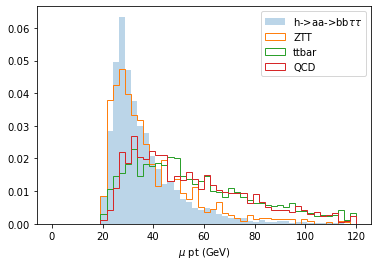

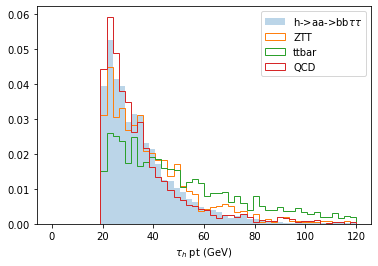

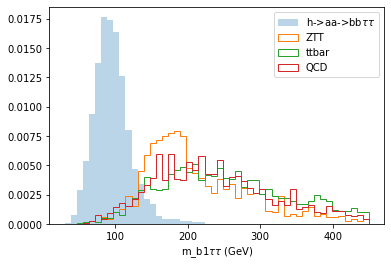

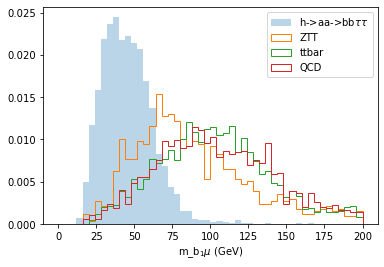

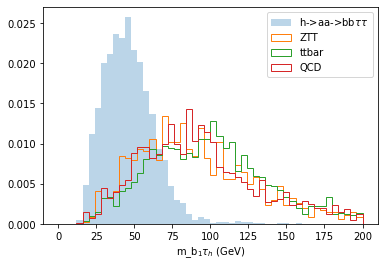

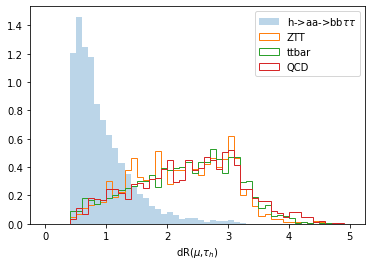

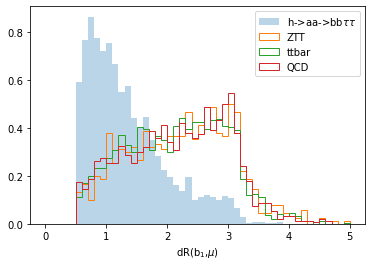

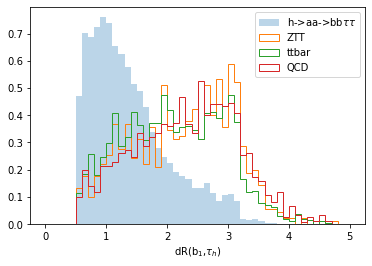

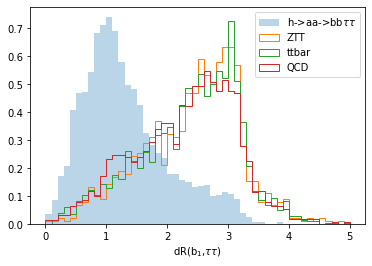

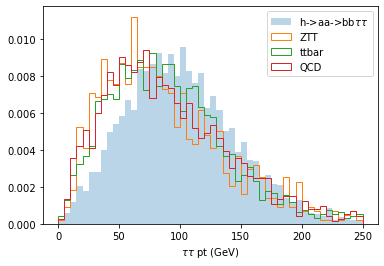

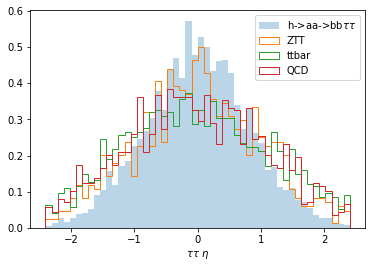

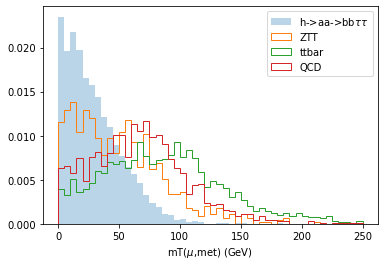

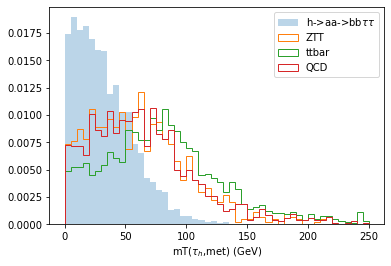

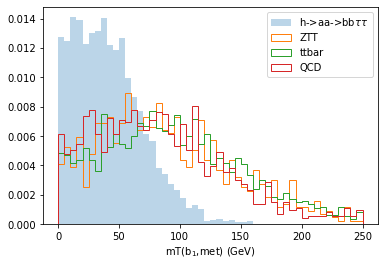

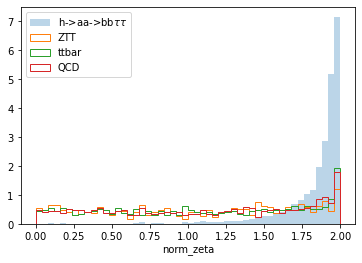

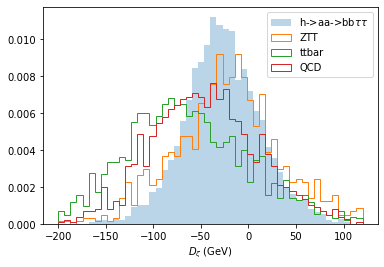

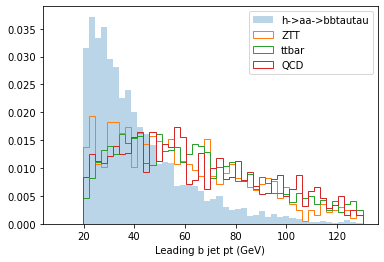

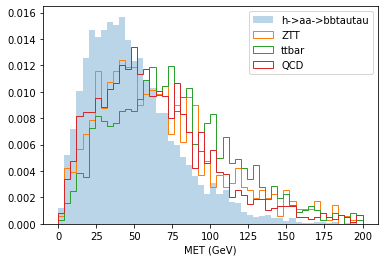

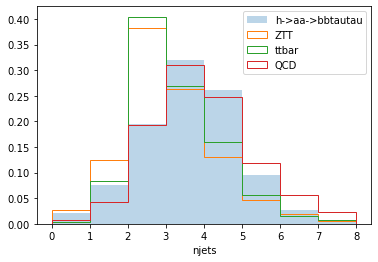

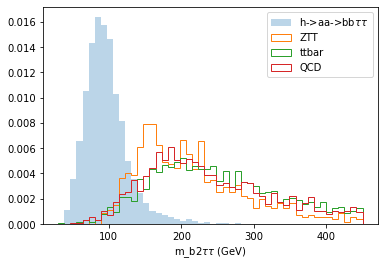

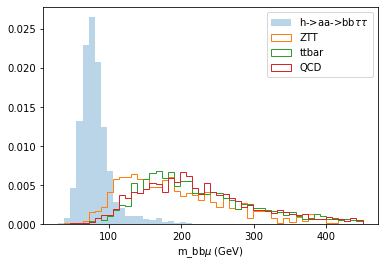

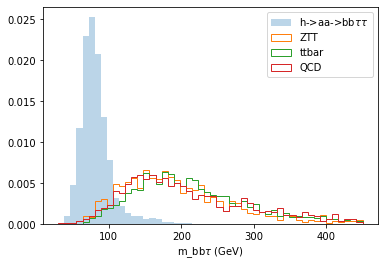

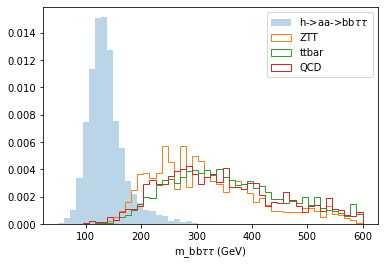

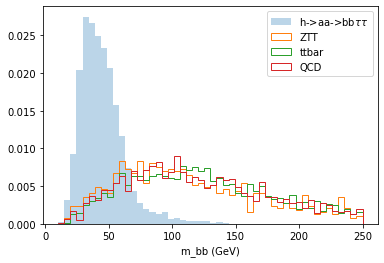

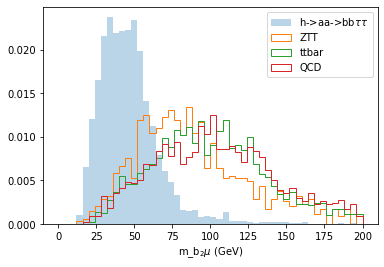

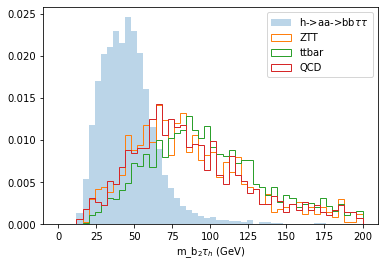

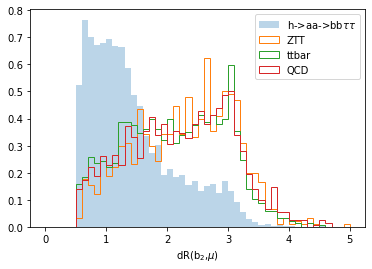

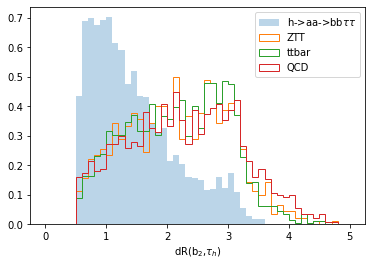

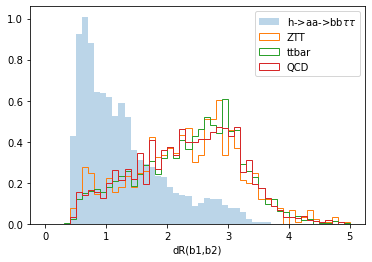

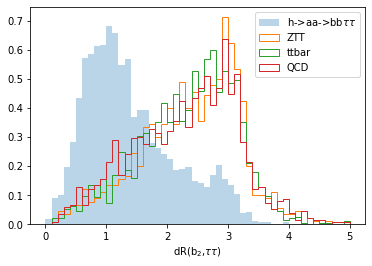

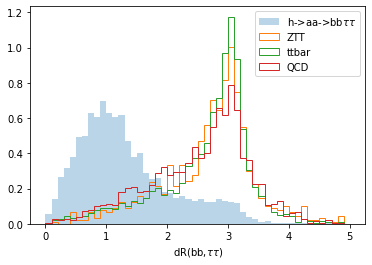

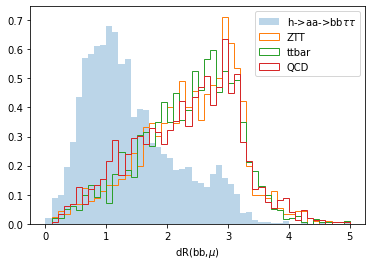

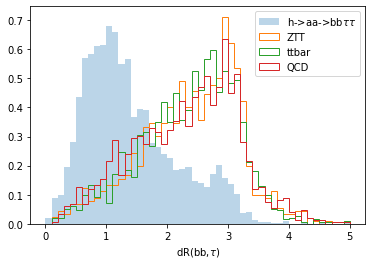

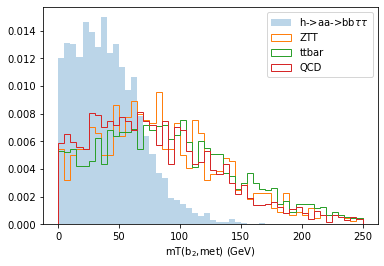

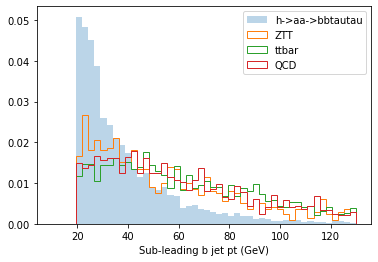

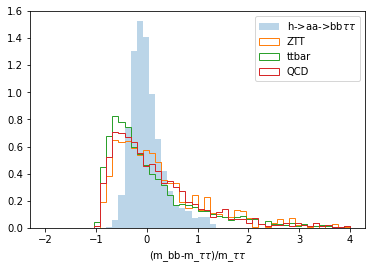

In [8]:
pyplot.hist(files[1]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau_h$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()


pyplot.hist(files[1]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()


pyplot.hist(files[1]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['norm_zeta'], density = 1, range = (0,2.), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'best')
pyplot.xlabel('norm_zeta')
pyplot.show()

pyplot.hist(files[1]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['met'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['met'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('MET (GeV)')
pyplot.show()

pyplot.hist(files[1]['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()


############## for 2b events
pyplot.hist(files[1]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(files[1]['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(files[1]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(files[1]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(files[1]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(files[1]['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\mu$)')
pyplot.show()

pyplot.hist(files[1]['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(files[1]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(files[1]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(files[2]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(files[1]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(files[2]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
pyplot.hist(files[3]['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
pyplot.hist(qcd['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()


## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]


# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)


# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (5208, 36)
Y_train.shape: (5208, 1)
X_val.shape: (1736, 36)
Y_val.shape: (1736, 1)
X_test.shape: (1736, 36)
Y_test.shape: (1736, 1)

Total number of sig/bkg examples: 4340/4340 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 2619/2589 (50.3%/49.7%)
val   : 847/889 (48.8%/51.2%)
test  : 874/862 (50.3%/49.7%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 40,
                                                   max_value = 100,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 40,
                                                   max_value = 100,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.3,
                                                      max_value = 0.5,
                                                      default = 0.3,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-12 23:41:01.504264: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-12 23:41:01.505648: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 128)

Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 29s - loss: 0.6754 - accuracy: 0.578 - ETA: 2s - loss: 0.5448 - accuracy: 0.756 - ETA: 1s - loss: 0.4447 - accuracy: 0.82 - ETA: 0s - loss: 0.3788 - accuracy: 0.85 - ETA: 0s - loss: 0.3323 - accuracy: 0.87 - 1s 227us/sample - loss: 0.3020 - accuracy: 0.8894 - val_loss: 0.1032 - val_accuracy: 0.9631
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.93 - ETA: 0s - loss: 0.1459 - accuracy: 0.95 - ETA: 0s - loss: 0.1531 - accuracy: 0.95 - ETA: 0s - loss: 0.1395 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1292 - accuracy: 0.9562 - val_loss: 0.0771 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.9814 - accuracy: 0.343 - ETA: 1s - loss: 0.7570 - accuracy: 0.514 - ETA: 0s - loss: 0.6554 - accuracy: 0.62 - ETA: 0s - loss: 0.5742 - accuracy: 0.69 - ETA: 0s - loss: 0.5141 - accuracy: 0.74 - 1s 174us/sample - loss: 0.4967 - accuracy: 0.7588 - val_loss: 0.1882 - val_accuracy: 0.9608
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.92 - ETA: 0s - loss: 0.2405 - accuracy: 0.91 - ETA: 0s - loss: 0.2218 - accuracy: 0.92 - ETA: 0s - loss: 0.2090 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.93 - 0s 72us/sample - loss: 0.1945 - accuracy: 0.9345 - val_loss: 0.0990 - val_accuracy: 0.9637


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7971 - accuracy: 0.484 - ETA: 1s - loss: 0.6140 - accuracy: 0.689 - ETA: 0s - loss: 0.5103 - accuracy: 0.77 - ETA: 0s - loss: 0.4361 - accuracy: 0.82 - ETA: 0s - loss: 0.3837 - accuracy: 0.84 - 1s 179us/sample - loss: 0.3517 - accuracy: 0.8642 - val_loss: 0.1180 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.92 - ETA: 0s - loss: 0.1671 - accuracy: 0.93 - ETA: 0s - loss: 0.1628 - accuracy: 0.93 - ETA: 0s - loss: 0.1514 - accuracy: 0.94 - ETA: 0s - loss: 0.1452 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1418 - accuracy: 0.9466 - val_loss: 0.0805 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.8779 - accuracy: 0.414 - ETA: 2s - loss: 0.7198 - accuracy: 0.554 - ETA: 1s - loss: 0.6065 - accuracy: 0.66 - ETA: 0s - loss: 0.5114 - accuracy: 0.75 - ETA: 0s - loss: 0.4448 - accuracy: 0.79 - ETA: 0s - loss: 0.3987 - accuracy: 0.82 - 1s 195us/sample - loss: 0.3900 - accuracy: 0.8260 - val_loss: 0.1139 - val_accuracy: 0.9700
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.92 - ETA: 0s - loss: 0.1554 - accuracy: 0.94 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - ETA: 0s - loss: 0.1400 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1303 - accuracy: 0.9495 - val_loss: 0.0775 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8475 - accuracy: 0.500 - ETA: 1s - loss: 0.6066 - accuracy: 0.691 - ETA: 0s - loss: 0.4821 - accuracy: 0.77 - ETA: 0s - loss: 0.4034 - accuracy: 0.82 - ETA: 0s - loss: 0.3571 - accuracy: 0.84 - 1s 179us/sample - loss: 0.3369 - accuracy: 0.8594 - val_loss: 0.1164 - val_accuracy: 0.9597
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.89 - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - ETA: 0s - loss: 0.1455 - accuracy: 0.94 - ETA: 0s - loss: 0.1461 - accuracy: 0.94 - ETA: 0s - loss: 0.1379 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1339 - accuracy: 0.9512 - val_loss: 0.0812 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8491 - accuracy: 0.554 - ETA: 1s - loss: 0.5698 - accuracy: 0.711 - ETA: 0s - loss: 0.4555 - accuracy: 0.79 - ETA: 0s - loss: 0.3906 - accuracy: 0.83 - ETA: 0s - loss: 0.3396 - accuracy: 0.85 - 1s 177us/sample - loss: 0.3249 - accuracy: 0.8667 - val_loss: 0.1158 - val_accuracy: 0.9585
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.93 - ETA: 0s - loss: 0.1520 - accuracy: 0.94 - ETA: 0s - loss: 0.1483 - accuracy: 0.94 - ETA: 0s - loss: 0.1435 - accuracy: 0.94 - ETA: 0s - loss: 0.1463 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1389 - accuracy: 0.9480 - val_loss: 0.0841 - val_accuracy: 0.9666


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.8375 - accuracy: 0.539 - ETA: 1s - loss: 0.6847 - accuracy: 0.641 - ETA: 0s - loss: 0.5613 - accuracy: 0.74 - ETA: 0s - loss: 0.4662 - accuracy: 0.80 - ETA: 0s - loss: 0.4139 - accuracy: 0.82 - 1s 181us/sample - loss: 0.3744 - accuracy: 0.8497 - val_loss: 0.1135 - val_accuracy: 0.9689
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.97 - ETA: 0s - loss: 0.1445 - accuracy: 0.94 - ETA: 0s - loss: 0.1472 - accuracy: 0.94 - ETA: 0s - loss: 0.1436 - accuracy: 0.94 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1403 - accuracy: 0.9491 - val_loss: 0.0804 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.8287 - accuracy: 0.414 - ETA: 1s - loss: 0.6596 - accuracy: 0.614 - ETA: 0s - loss: 0.5496 - accuracy: 0.73 - ETA: 0s - loss: 0.4600 - accuracy: 0.79 - ETA: 0s - loss: 0.3951 - accuracy: 0.83 - ETA: 0s - loss: 0.3522 - accuracy: 0.85 - 1s 185us/sample - loss: 0.3463 - accuracy: 0.8543 - val_loss: 0.1053 - val_accuracy: 0.9677
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1369 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1217 - accuracy: 0.9556 - val_loss: 0.0770 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.9425 - accuracy: 0.468 - ETA: 1s - loss: 0.7349 - accuracy: 0.529 - ETA: 0s - loss: 0.5913 - accuracy: 0.66 - ETA: 0s - loss: 0.4886 - accuracy: 0.75 - ETA: 0s - loss: 0.4182 - accuracy: 0.79 - 1s 179us/sample - loss: 0.3710 - accuracy: 0.8274 - val_loss: 0.1068 - val_accuracy: 0.9683
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.96 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1278 - accuracy: 0.9533 - val_loss: 0.0803 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7265 - accuracy: 0.531 - ETA: 1s - loss: 0.5556 - accuracy: 0.726 - ETA: 0s - loss: 0.4470 - accuracy: 0.81 - ETA: 0s - loss: 0.3840 - accuracy: 0.84 - ETA: 0s - loss: 0.3322 - accuracy: 0.86 - 1s 182us/sample - loss: 0.2980 - accuracy: 0.8829 - val_loss: 0.1021 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.96 - ETA: 0s - loss: 0.1392 - accuracy: 0.95 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1285 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1168 - accuracy: 0.9574 - val_loss: 0.0751 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7603 - accuracy: 0.523 - ETA: 1s - loss: 0.5800 - accuracy: 0.673 - ETA: 0s - loss: 0.4776 - accuracy: 0.77 - ETA: 0s - loss: 0.3998 - accuracy: 0.82 - ETA: 0s - loss: 0.3459 - accuracy: 0.85 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - 1s 183us/sample - loss: 0.3029 - accuracy: 0.8754 - val_loss: 0.0984 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.94 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1113 - accuracy: 0.9587 - val_loss: 0.0780 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.6449 - accuracy: 0.585 - ETA: 2s - loss: 0.5067 - accuracy: 0.781 - ETA: 1s - loss: 0.4024 - accuracy: 0.85 - ETA: 0s - loss: 0.3391 - accuracy: 0.88 - ETA: 0s - loss: 0.2979 - accuracy: 0.89 - ETA: 0s - loss: 0.2694 - accuracy: 0.90 - 1s 189us/sample - loss: 0.2513 - accuracy: 0.9121 - val_loss: 0.0978 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - 0s 74us/sample - loss: 0.1070 - accuracy: 0.9614 - val_loss: 0.0793 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.6846 - accuracy: 0.617 - ETA: 1s - loss: 0.5127 - accuracy: 0.771 - ETA: 0s - loss: 0.4271 - accuracy: 0.82 - ETA: 0s - loss: 0.3616 - accuracy: 0.86 - ETA: 0s - loss: 0.3205 - accuracy: 0.88 - 1s 178us/sample - loss: 0.3007 - accuracy: 0.8884 - val_loss: 0.1080 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.94 - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - ETA: 0s - loss: 0.1428 - accuracy: 0.95 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1334 - accuracy: 0.9520 - val_loss: 0.0782 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7962 - accuracy: 0.484 - ETA: 1s - loss: 0.6456 - accuracy: 0.645 - ETA: 0s - loss: 0.5016 - accuracy: 0.75 - ETA: 0s - loss: 0.4229 - accuracy: 0.81 - ETA: 0s - loss: 0.3710 - accuracy: 0.84 - 1s 181us/sample - loss: 0.3312 - accuracy: 0.8598 - val_loss: 0.1066 - val_accuracy: 0.9649
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.92 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1227 - accuracy: 0.9556 - val_loss: 0.0737 - val_accuracy: 0.9752


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.6954 - accuracy: 0.554 - ETA: 1s - loss: 0.5475 - accuracy: 0.722 - ETA: 0s - loss: 0.4606 - accuracy: 0.79 - ETA: 0s - loss: 0.3896 - accuracy: 0.83 - ETA: 0s - loss: 0.3368 - accuracy: 0.86 - 1s 178us/sample - loss: 0.3112 - accuracy: 0.8788 - val_loss: 0.1071 - val_accuracy: 0.9689
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.95 - ETA: 0s - loss: 0.1493 - accuracy: 0.95 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1281 - accuracy: 0.9576 - val_loss: 0.0775 - val_accuracy: 0.9712


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.8750 - accuracy: 0.515 - ETA: 2s - loss: 0.5912 - accuracy: 0.700 - ETA: 0s - loss: 0.4651 - accuracy: 0.79 - ETA: 0s - loss: 0.3976 - accuracy: 0.83 - ETA: 0s - loss: 0.3519 - accuracy: 0.85 - 1s 191us/sample - loss: 0.3187 - accuracy: 0.8685 - val_loss: 0.1095 - val_accuracy: 0.9631
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.96 - ETA: 0s - loss: 0.1498 - accuracy: 0.94 - ETA: 0s - loss: 0.1452 - accuracy: 0.95 - ETA: 0s - loss: 0.1547 - accuracy: 0.94 - ETA: 0s - loss: 0.1407 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1380 - accuracy: 0.9520 - val_loss: 0.0814 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8043 - accuracy: 0.500 - ETA: 2s - loss: 0.6046 - accuracy: 0.664 - ETA: 0s - loss: 0.5002 - accuracy: 0.75 - ETA: 0s - loss: 0.4269 - accuracy: 0.80 - ETA: 0s - loss: 0.3768 - accuracy: 0.83 - ETA: 0s - loss: 0.3397 - accuracy: 0.85 - 1s 187us/sample - loss: 0.3366 - accuracy: 0.8535 - val_loss: 0.1065 - val_accuracy: 0.9666
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.91 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - ETA: 0s - loss: 0.1517 - accuracy: 0.94 - ETA: 0s - loss: 0.1428 - accuracy: 0.94 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1314 - accuracy: 0.9526 - val_loss: 0.0781 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.6855 - accuracy: 0.640 - ETA: 1s - loss: 0.5079 - accuracy: 0.780 - ETA: 0s - loss: 0.4150 - accuracy: 0.83 - ETA: 0s - loss: 0.3445 - accuracy: 0.87 - ETA: 0s - loss: 0.2962 - accuracy: 0.89 - 1s 179us/sample - loss: 0.2722 - accuracy: 0.9025 - val_loss: 0.0964 - val_accuracy: 0.9712
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.96 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1134 - accuracy: 0.9604 - val_loss: 0.0768 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7431 - accuracy: 0.578 - ETA: 1s - loss: 0.5809 - accuracy: 0.723 - ETA: 0s - loss: 0.5021 - accuracy: 0.78 - ETA: 0s - loss: 0.4388 - accuracy: 0.82 - ETA: 0s - loss: 0.3857 - accuracy: 0.84 - 1s 176us/sample - loss: 0.3664 - accuracy: 0.8579 - val_loss: 0.1202 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.95 - ETA: 0s - loss: 0.1565 - accuracy: 0.94 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - ETA: 0s - loss: 0.1497 - accuracy: 0.94 - ETA: 0s - loss: 0.1436 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1429 - accuracy: 0.9512 - val_loss: 0.0793 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7349 - accuracy: 0.476 - ETA: 2s - loss: 0.6114 - accuracy: 0.657 - ETA: 1s - loss: 0.4793 - accuracy: 0.77 - ETA: 0s - loss: 0.3993 - accuracy: 0.82 - ETA: 0s - loss: 0.3459 - accuracy: 0.85 - ETA: 0s - loss: 0.3125 - accuracy: 0.87 - 1s 188us/sample - loss: 0.3026 - accuracy: 0.8769 - val_loss: 0.1061 - val_accuracy: 0.9672
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.98 - ETA: 0s - loss: 0.1398 - accuracy: 0.95 - ETA: 0s - loss: 0.1396 - accuracy: 0.94 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1183 - accuracy: 0.9562 - val_loss: 0.0776 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8079 - accuracy: 0.460 - ETA: 1s - loss: 0.6575 - accuracy: 0.589 - ETA: 0s - loss: 0.5656 - accuracy: 0.68 - ETA: 0s - loss: 0.4938 - accuracy: 0.74 - ETA: 0s - loss: 0.4379 - accuracy: 0.78 - 1s 182us/sample - loss: 0.3993 - accuracy: 0.8128 - val_loss: 0.1417 - val_accuracy: 0.9591
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.93 - ETA: 0s - loss: 0.1870 - accuracy: 0.94 - ETA: 0s - loss: 0.1736 - accuracy: 0.94 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1670 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1607 - accuracy: 0.9468 - val_loss: 0.0884 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7733 - accuracy: 0.515 - ETA: 1s - loss: 0.5910 - accuracy: 0.677 - ETA: 0s - loss: 0.5054 - accuracy: 0.76 - ETA: 0s - loss: 0.4400 - accuracy: 0.80 - ETA: 0s - loss: 0.3890 - accuracy: 0.83 - ETA: 0s - loss: 0.3524 - accuracy: 0.85 - 1s 191us/sample - loss: 0.3428 - accuracy: 0.8631 - val_loss: 0.1172 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.92 - ETA: 0s - loss: 0.1563 - accuracy: 0.94 - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1436 - accuracy: 0.94 - ETA: 0s - loss: 0.1371 - accuracy: 0.94 - ETA: 0s - loss: 0.1359 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1353 - accuracy: 0.9491 - val_loss: 0.0820 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8822 - accuracy: 0.460 - ETA: 1s - loss: 0.7318 - accuracy: 0.545 - ETA: 0s - loss: 0.6153 - accuracy: 0.65 - ETA: 0s - loss: 0.5310 - accuracy: 0.72 - ETA: 0s - loss: 0.4614 - accuracy: 0.77 - 1s 179us/sample - loss: 0.4280 - accuracy: 0.7988 - val_loss: 0.1520 - val_accuracy: 0.9539
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.92 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.1961 - accuracy: 0.92 - ETA: 0s - loss: 0.1799 - accuracy: 0.93 - ETA: 0s - loss: 0.1679 - accuracy: 0.93 - 0s 61us/sample - loss: 0.1658 - accuracy: 0.9407 - val_loss: 0.0934 - val_accuracy: 0.9631


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7715 - accuracy: 0.468 - ETA: 1s - loss: 0.6517 - accuracy: 0.591 - ETA: 0s - loss: 0.5494 - accuracy: 0.69 - ETA: 0s - loss: 0.4980 - accuracy: 0.73 - ETA: 0s - loss: 0.4494 - accuracy: 0.77 - ETA: 0s - loss: 0.4130 - accuracy: 0.80 - 1s 189us/sample - loss: 0.4003 - accuracy: 0.8118 - val_loss: 0.1340 - val_accuracy: 0.9597
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.93 - ETA: 0s - loss: 0.2029 - accuracy: 0.93 - ETA: 0s - loss: 0.1937 - accuracy: 0.93 - ETA: 0s - loss: 0.1829 - accuracy: 0.93 - ETA: 0s - loss: 0.1749 - accuracy: 0.94 - ETA: 0s - loss: 0.1688 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1691 - accuracy: 0.9439 - val_loss: 0.0840 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7651 - accuracy: 0.367 - ETA: 1s - loss: 0.6355 - accuracy: 0.585 - ETA: 0s - loss: 0.5279 - accuracy: 0.71 - ETA: 0s - loss: 0.4473 - accuracy: 0.78 - ETA: 0s - loss: 0.3957 - accuracy: 0.82 - 1s 183us/sample - loss: 0.3513 - accuracy: 0.8454 - val_loss: 0.1103 - val_accuracy: 0.9660
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - ETA: 0s - loss: 0.1499 - accuracy: 0.95 - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - ETA: 0s - loss: 0.1403 - accuracy: 0.95 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1261 - accuracy: 0.9551 - val_loss: 0.0776 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7873 - accuracy: 0.437 - ETA: 2s - loss: 0.6431 - accuracy: 0.626 - ETA: 1s - loss: 0.5264 - accuracy: 0.74 - ETA: 0s - loss: 0.4334 - accuracy: 0.80 - ETA: 0s - loss: 0.3724 - accuracy: 0.84 - ETA: 0s - loss: 0.3286 - accuracy: 0.86 - 1s 185us/sample - loss: 0.3224 - accuracy: 0.8660 - val_loss: 0.0971 - val_accuracy: 0.9706
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1552 - accuracy: 0.93 - ETA: 0s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1238 - accuracy: 0.9547 - val_loss: 0.0768 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.6674 - accuracy: 0.484 - ETA: 2s - loss: 0.5885 - accuracy: 0.615 - ETA: 1s - loss: 0.5105 - accuracy: 0.71 - ETA: 0s - loss: 0.4523 - accuracy: 0.77 - ETA: 0s - loss: 0.4084 - accuracy: 0.80 - ETA: 0s - loss: 0.3682 - accuracy: 0.83 - 1s 188us/sample - loss: 0.3447 - accuracy: 0.8452 - val_loss: 0.1154 - val_accuracy: 0.9660
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.94 - ETA: 0s - loss: 0.1521 - accuracy: 0.94 - ETA: 0s - loss: 0.1501 - accuracy: 0.94 - ETA: 0s - loss: 0.1469 - accuracy: 0.94 - ETA: 0s - loss: 0.1454 - accuracy: 0.94 - ETA: 0s - loss: 0.1447 - accuracy: 0.94 - 0s 81us/sample - loss: 0.1455 - accuracy: 0.9455 - val_loss: 0.0829 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8005 - accuracy: 0.585 - ETA: 2s - loss: 0.6272 - accuracy: 0.691 - ETA: 1s - loss: 0.5321 - accuracy: 0.76 - ETA: 0s - loss: 0.4869 - accuracy: 0.79 - ETA: 0s - loss: 0.4298 - accuracy: 0.83 - ETA: 0s - loss: 0.3859 - accuracy: 0.85 - ETA: 0s - loss: 0.3518 - accuracy: 0.86 - 1s 202us/sample - loss: 0.3408 - accuracy: 0.8721 - val_loss: 0.1055 - val_accuracy: 0.9689
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.96 - ETA: 0s - loss: 0.1448 - accuracy: 0.95 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - ETA: 0s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1359 - accuracy: 0.95 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1322 - accuracy: 0.9533 - val_loss: 0.0766 - val_accuracy: 0.9735


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7471 - accuracy: 0.429 - ETA: 2s - loss: 0.6003 - accuracy: 0.655 - ETA: 0s - loss: 0.4968 - accuracy: 0.76 - ETA: 0s - loss: 0.4220 - accuracy: 0.81 - ETA: 0s - loss: 0.3658 - accuracy: 0.84 - ETA: 0s - loss: 0.3297 - accuracy: 0.86 - 1s 191us/sample - loss: 0.3162 - accuracy: 0.8679 - val_loss: 0.1040 - val_accuracy: 0.9683
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1205 - accuracy: 0.96 - ETA: 0s - loss: 0.1328 - accuracy: 0.95 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1249 - accuracy: 0.9555 - val_loss: 0.0781 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7370 - accuracy: 0.515 - ETA: 1s - loss: 0.5569 - accuracy: 0.709 - ETA: 0s - loss: 0.4599 - accuracy: 0.78 - ETA: 0s - loss: 0.3833 - accuracy: 0.83 - ETA: 0s - loss: 0.3387 - accuracy: 0.85 - ETA: 0s - loss: 0.3067 - accuracy: 0.87 - 1s 187us/sample - loss: 0.2983 - accuracy: 0.8763 - val_loss: 0.1082 - val_accuracy: 0.9579
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.97 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1165 - accuracy: 0.9564 - val_loss: 0.0782 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.9817 - accuracy: 0.523 - ETA: 1s - loss: 0.7922 - accuracy: 0.601 - ETA: 0s - loss: 0.6344 - accuracy: 0.69 - ETA: 0s - loss: 0.5285 - accuracy: 0.76 - ETA: 0s - loss: 0.4464 - accuracy: 0.80 - 1s 179us/sample - loss: 0.4178 - accuracy: 0.8243 - val_loss: 0.1282 - val_accuracy: 0.9579
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.92 - ETA: 0s - loss: 0.1653 - accuracy: 0.93 - ETA: 0s - loss: 0.1677 - accuracy: 0.93 - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - ETA: 0s - loss: 0.1466 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1474 - accuracy: 0.9453 - val_loss: 0.0843 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7116 - accuracy: 0.570 - ETA: 2s - loss: 0.6075 - accuracy: 0.678 - ETA: 0s - loss: 0.4898 - accuracy: 0.77 - ETA: 0s - loss: 0.4175 - accuracy: 0.81 - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - ETA: 0s - loss: 0.3262 - accuracy: 0.86 - 1s 183us/sample - loss: 0.3226 - accuracy: 0.8673 - val_loss: 0.1107 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.94 - ETA: 0s - loss: 0.1338 - accuracy: 0.94 - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - ETA: 0s - loss: 0.1381 - accuracy: 0.95 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1301 - accuracy: 0.9530 - val_loss: 0.0782 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7365 - accuracy: 0.570 - ETA: 1s - loss: 0.5530 - accuracy: 0.729 - ETA: 0s - loss: 0.4656 - accuracy: 0.80 - ETA: 0s - loss: 0.3921 - accuracy: 0.84 - ETA: 0s - loss: 0.3470 - accuracy: 0.86 - 1s 182us/sample - loss: 0.3149 - accuracy: 0.8758 - val_loss: 0.1099 - val_accuracy: 0.9660
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.96 - ETA: 0s - loss: 0.1389 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1254 - accuracy: 0.9553 - val_loss: 0.0760 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.8783 - accuracy: 0.445 - ETA: 1s - loss: 0.6837 - accuracy: 0.601 - ETA: 0s - loss: 0.5853 - accuracy: 0.68 - ETA: 0s - loss: 0.4995 - accuracy: 0.75 - ETA: 0s - loss: 0.4334 - accuracy: 0.79 - 1s 180us/sample - loss: 0.4068 - accuracy: 0.8134 - val_loss: 0.1357 - val_accuracy: 0.9579
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.95 - ETA: 0s - loss: 0.1964 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1772 - accuracy: 0.93 - ETA: 0s - loss: 0.1728 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1693 - accuracy: 0.9397 - val_loss: 0.0916 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8606 - accuracy: 0.453 - ETA: 1s - loss: 0.6321 - accuracy: 0.671 - ETA: 0s - loss: 0.5087 - accuracy: 0.75 - ETA: 0s - loss: 0.4326 - accuracy: 0.80 - ETA: 0s - loss: 0.3751 - accuracy: 0.83 - 1s 181us/sample - loss: 0.3442 - accuracy: 0.8525 - val_loss: 0.1054 - val_accuracy: 0.9666
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.93 - ETA: 0s - loss: 0.1409 - accuracy: 0.94 - ETA: 0s - loss: 0.1458 - accuracy: 0.94 - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - ETA: 0s - loss: 0.1349 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1338 - accuracy: 0.9503 - val_loss: 0.0761 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9203 - accuracy: 0.414 - ETA: 1s - loss: 0.6272 - accuracy: 0.633 - ETA: 0s - loss: 0.5225 - accuracy: 0.73 - ETA: 0s - loss: 0.4357 - accuracy: 0.79 - ETA: 0s - loss: 0.3825 - accuracy: 0.82 - ETA: 0s - loss: 0.3387 - accuracy: 0.85 - 1s 185us/sample - loss: 0.3345 - accuracy: 0.8531 - val_loss: 0.1145 - val_accuracy: 0.9603
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.96 - ETA: 0s - loss: 0.1642 - accuracy: 0.94 - ETA: 0s - loss: 0.1608 - accuracy: 0.93 - ETA: 0s - loss: 0.1479 - accuracy: 0.94 - ETA: 0s - loss: 0.1382 - accuracy: 0.94 - ETA: 0s - loss: 0.1339 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1333 - accuracy: 0.9503 - val_loss: 0.0820 - val_accuracy: 0.9712


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.5881 - accuracy: 0.664 - ETA: 1s - loss: 0.4894 - accuracy: 0.782 - ETA: 0s - loss: 0.4166 - accuracy: 0.83 - ETA: 0s - loss: 0.3588 - accuracy: 0.86 - ETA: 0s - loss: 0.3135 - accuracy: 0.88 - ETA: 0s - loss: 0.2842 - accuracy: 0.89 - 1s 186us/sample - loss: 0.2746 - accuracy: 0.9015 - val_loss: 0.0926 - val_accuracy: 0.9689
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.93 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1167 - accuracy: 0.9562 - val_loss: 0.0741 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6662 - accuracy: 0.562 - ETA: 2s - loss: 0.5718 - accuracy: 0.670 - ETA: 0s - loss: 0.4946 - accuracy: 0.75 - ETA: 0s - loss: 0.4252 - accuracy: 0.81 - ETA: 0s - loss: 0.3776 - accuracy: 0.84 - ETA: 0s - loss: 0.3441 - accuracy: 0.85 - 1s 187us/sample - loss: 0.3389 - accuracy: 0.8596 - val_loss: 0.1232 - val_accuracy: 0.9643
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.97 - ETA: 0s - loss: 0.1493 - accuracy: 0.94 - ETA: 0s - loss: 0.1530 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1404 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1373 - accuracy: 0.9514 - val_loss: 0.0841 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 19s - loss: 0.7866 - accuracy: 0.531 - ETA: 1s - loss: 0.6200 - accuracy: 0.649 - ETA: 0s - loss: 0.5053 - accuracy: 0.75 - ETA: 0s - loss: 0.4235 - accuracy: 0.80 - ETA: 0s - loss: 0.3642 - accuracy: 0.83 - ETA: 0s - loss: 0.3193 - accuracy: 0.86 - 1s 183us/sample - loss: 0.3166 - accuracy: 0.8642 - val_loss: 0.0960 - val_accuracy: 0.9729
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.96 - ETA: 0s - loss: 0.1359 - accuracy: 0.94 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1179 - accuracy: 0.9566 - val_loss: 0.0731 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9079 - accuracy: 0.328 - ETA: 1s - loss: 0.6715 - accuracy: 0.585 - ETA: 0s - loss: 0.5315 - accuracy: 0.71 - ETA: 0s - loss: 0.4544 - accuracy: 0.77 - ETA: 0s - loss: 0.3877 - accuracy: 0.81 - ETA: 0s - loss: 0.3460 - accuracy: 0.83 - 1s 187us/sample - loss: 0.3421 - accuracy: 0.8397 - val_loss: 0.1131 - val_accuracy: 0.9603
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.94 - ETA: 0s - loss: 0.1503 - accuracy: 0.94 - ETA: 0s - loss: 0.1436 - accuracy: 0.94 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.94 - ETA: 0s - loss: 0.1355 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1341 - accuracy: 0.9497 - val_loss: 0.0840 - val_accuracy: 0.9643


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 24s - loss: 0.6602 - accuracy: 0.585 - ETA: 1s - loss: 0.5262 - accuracy: 0.742 - ETA: 0s - loss: 0.4497 - accuracy: 0.81 - ETA: 0s - loss: 0.3920 - accuracy: 0.84 - ETA: 0s - loss: 0.3476 - accuracy: 0.87 - 1s 200us/sample - loss: 0.3225 - accuracy: 0.8788 - val_loss: 0.1113 - val_accuracy: 0.9649
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1247 - accuracy: 0.9574 - val_loss: 0.0830 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7349 - accuracy: 0.468 - ETA: 2s - loss: 0.5848 - accuracy: 0.688 - ETA: 0s - loss: 0.4770 - accuracy: 0.78 - ETA: 0s - loss: 0.4057 - accuracy: 0.82 - ETA: 0s - loss: 0.3453 - accuracy: 0.85 - 1s 184us/sample - loss: 0.3167 - accuracy: 0.8742 - val_loss: 0.1126 - val_accuracy: 0.9597
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1412 - accuracy: 0.95 - ETA: 0s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1245 - accuracy: 0.9570 - val_loss: 0.0817 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9120 - accuracy: 0.390 - ETA: 1s - loss: 0.6977 - accuracy: 0.537 - ETA: 0s - loss: 0.5800 - accuracy: 0.66 - ETA: 0s - loss: 0.5086 - accuracy: 0.73 - ETA: 0s - loss: 0.4494 - accuracy: 0.77 - 1s 181us/sample - loss: 0.4024 - accuracy: 0.8101 - val_loss: 0.1401 - val_accuracy: 0.9568
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.95 - ETA: 0s - loss: 0.1853 - accuracy: 0.94 - ETA: 0s - loss: 0.1708 - accuracy: 0.94 - ETA: 0s - loss: 0.1641 - accuracy: 0.94 - ETA: 0s - loss: 0.1547 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1486 - accuracy: 0.9480 - val_loss: 0.0863 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7258 - accuracy: 0.539 - ETA: 2s - loss: 0.5728 - accuracy: 0.701 - ETA: 0s - loss: 0.4897 - accuracy: 0.78 - ETA: 0s - loss: 0.4208 - accuracy: 0.82 - ETA: 0s - loss: 0.3699 - accuracy: 0.85 - ETA: 0s - loss: 0.3315 - accuracy: 0.87 - 1s 188us/sample - loss: 0.3283 - accuracy: 0.8725 - val_loss: 0.1108 - val_accuracy: 0.9643
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.92 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1221 - accuracy: 0.9551 - val_loss: 0.0787 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6501 - accuracy: 0.625 - ETA: 1s - loss: 0.5048 - accuracy: 0.756 - ETA: 0s - loss: 0.4276 - accuracy: 0.81 - ETA: 0s - loss: 0.3626 - accuracy: 0.84 - ETA: 0s - loss: 0.3200 - accuracy: 0.86 - ETA: 0s - loss: 0.2855 - accuracy: 0.88 - 1s 184us/sample - loss: 0.2833 - accuracy: 0.8863 - val_loss: 0.1019 - val_accuracy: 0.9683
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.96 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1436 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1287 - accuracy: 0.9531 - val_loss: 0.0774 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8271 - accuracy: 0.500 - ETA: 1s - loss: 0.6709 - accuracy: 0.633 - ETA: 0s - loss: 0.5528 - accuracy: 0.72 - ETA: 0s - loss: 0.4753 - accuracy: 0.77 - ETA: 0s - loss: 0.4125 - accuracy: 0.81 - 1s 183us/sample - loss: 0.3737 - accuracy: 0.8347 - val_loss: 0.1196 - val_accuracy: 0.9643
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.92 - ETA: 0s - loss: 0.1674 - accuracy: 0.94 - ETA: 0s - loss: 0.1740 - accuracy: 0.93 - ETA: 0s - loss: 0.1581 - accuracy: 0.94 - ETA: 0s - loss: 0.1542 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1512 - accuracy: 0.9466 - val_loss: 0.0805 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8612 - accuracy: 0.523 - ETA: 1s - loss: 0.6225 - accuracy: 0.671 - ETA: 0s - loss: 0.5120 - accuracy: 0.76 - ETA: 0s - loss: 0.4414 - accuracy: 0.81 - ETA: 0s - loss: 0.3887 - accuracy: 0.83 - ETA: 0s - loss: 0.3512 - accuracy: 0.85 - 1s 188us/sample - loss: 0.3368 - accuracy: 0.8623 - val_loss: 0.1087 - val_accuracy: 0.9626
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.96 - ETA: 0s - loss: 0.1300 - accuracy: 0.96 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - ETA: 0s - loss: 0.1421 - accuracy: 0.95 - ETA: 0s - loss: 0.1363 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1329 - accuracy: 0.9566 - val_loss: 0.0788 - val_accuracy: 0.9689
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.99 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 19s - loss: 0.7613 - accuracy: 0.453 - ETA: 1s - loss: 0.6132 - accuracy: 0.674 - ETA: 0s - loss: 0.5009 - accuracy: 0.77 - ETA: 0s - loss: 0.4259 - accuracy: 0.82 - ETA: 0s - loss: 0.3678 - accuracy: 0.85 - ETA: 0s - loss: 0.3298 - accuracy: 0.86 - 1s 185us/sample - loss: 0.3284 - accuracy: 0.8671 - val_loss: 0.1062 - val_accuracy: 0.9643
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.91 - ETA: 0s - loss: 0.1400 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1205 - accuracy: 0.9558 - val_loss: 0.0772 - val_accuracy: 0.9724
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.92 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 1.0119 - accuracy: 0.468 - ETA: 1s - loss: 0.7006 - accuracy: 0.622 - ETA: 1s - loss: 0.6400 - accuracy: 0.66 - ETA: 0s - loss: 0.5479 - accuracy: 0.73 - ETA: 0s - loss: 0.4611 - accuracy: 0.79 - ETA: 0s - loss: 0.4076 - accuracy: 0.81 - 1s 193us/sample - loss: 0.3696 - accuracy: 0.8401 - val_loss: 0.1198 - val_accuracy: 0.9603
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.95 - ETA: 0s - loss: 0.1771 - accuracy: 0.93 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - accuracy: 0.94 - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - ETA: 0s - loss: 0.1419 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1408 - accuracy: 0.9493 - val_loss: 0.0816 - val_accuracy: 0.9712
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 21s - loss: 0.7979 - accuracy: 0.390 - ETA: 2s - loss: 0.5797 - accuracy: 0.672 - ETA: 0s - loss: 0.4753 - accuracy: 0.76 - ETA: 0s - loss: 0.4091 - accuracy: 0.80 - ETA: 0s - loss: 0.3620 - accuracy: 0.83 - ETA: 0s - loss: 0.3260 - accuracy: 0.85 - 1s 193us/sample - loss: 0.3157 - accuracy: 0.8644 - val_loss: 0.1041 - val_accuracy: 0.9672
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.93 - ETA: 0s - loss: 0.1416 - accuracy: 0.95 - ETA: 0s - loss: 0.1484 - accuracy: 0.95 - ETA: 0s - loss: 0.1326 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1270 - accuracy: 0.9585 - val_loss: 0.0797 - val_accuracy: 0.9712
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7097 - accuracy: 0.601 - ETA: 1s - loss: 0.5447 - accuracy: 0.750 - ETA: 0s - loss: 0.4398 - accuracy: 0.82 - ETA: 0s - loss: 0.3750 - accuracy: 0.85 - ETA: 0s - loss: 0.3275 - accuracy: 0.87 - 1s 182us/sample - loss: 0.2963 - accuracy: 0.8884 - val_loss: 0.1033 - val_accuracy: 0.9649
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.97 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1145 - accuracy: 0.9570 - val_loss: 0.0777 - val_accuracy: 0.9718
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0821 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8489 - accuracy: 0.421 - ETA: 1s - loss: 0.6212 - accuracy: 0.654 - ETA: 0s - loss: 0.5073 - accuracy: 0.75 - ETA: 0s - loss: 0.4316 - accuracy: 0.81 - ETA: 0s - loss: 0.3692 - accuracy: 0.84 - 1s 181us/sample - loss: 0.3469 - accuracy: 0.8523 - val_loss: 0.1092 - val_accuracy: 0.9700
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.98 - ETA: 0s - loss: 0.1354 - accuracy: 0.96 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1271 - accuracy: 0.9553 - val_loss: 0.0780 - val_accuracy: 0.9729
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.97 - ETA: 0s - loss: 0.1405 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8737 - accuracy: 0.390 - ETA: 1s - loss: 0.7175 - accuracy: 0.515 - ETA: 0s - loss: 0.6243 - accuracy: 0.62 - ETA: 0s - loss: 0.5509 - accuracy: 0.70 - ETA: 0s - loss: 0.4890 - accuracy: 0.75 - 1s 177us/sample - loss: 0.4735 - accuracy: 0.7686 - val_loss: 0.1818 - val_accuracy: 0.9689
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.90 - ETA: 0s - loss: 0.2110 - accuracy: 0.93 - ETA: 0s - loss: 0.1964 - accuracy: 0.93 - ETA: 0s - loss: 0.1819 - accuracy: 0.94 - ETA: 0s - loss: 0.1745 - accuracy: 0.94 - 0s 55us/sample - loss: 0.1685 - accuracy: 0.9478 - val_loss: 0.0909 - val_accuracy: 0.9683
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.94 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1253 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7914 - accuracy: 0.515 - ETA: 2s - loss: 0.5972 - accuracy: 0.679 - ETA: 1s - loss: 0.4855 - accuracy: 0.77 - ETA: 0s - loss: 0.4040 - accuracy: 0.82 - ETA: 0s - loss: 0.3522 - accuracy: 0.84 - ETA: 0s - loss: 0.3150 - accuracy: 0.86 - 1s 192us/sample - loss: 0.2943 - accuracy: 0.8767 - val_loss: 0.1000 - val_accuracy: 0.9654
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.95 - ETA: 0s - loss: 0.1390 - accuracy: 0.94 - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1392 - accuracy: 0.94 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1244 - accuracy: 0.9551 - val_loss: 0.0761 - val_accuracy: 0.9700
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0782 - accuracy: 0.97 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8151 - accuracy: 0.648 - ETA: 1s - loss: 0.7404 - accuracy: 0.632 - ETA: 0s - loss: 0.6026 - accuracy: 0.71 - ETA: 0s - loss: 0.5151 - accuracy: 0.76 - ETA: 0s - loss: 0.4497 - accuracy: 0.79 - 1s 179us/sample - loss: 0.4323 - accuracy: 0.8089 - val_loss: 0.1417 - val_accuracy: 0.9556
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.92 - ETA: 0s - loss: 0.1937 - accuracy: 0.92 - ETA: 0s - loss: 0.1843 - accuracy: 0.93 - ETA: 0s - loss: 0.1748 - accuracy: 0.93 - ETA: 0s - loss: 0.1703 - accuracy: 0.93 - 0s 61us/sample - loss: 0.1670 - accuracy: 0.9386 - val_loss: 0.0914 - val_accuracy: 0.9689
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.94 - ETA: 0s - loss: 0.1385 - accuracy: 0.95 - ETA: 0s - loss: 0.1338 - accuracy: 0.94 - ETA: 0s - loss: 0.1357 - accuracy: 0.94 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.5622 - accuracy: 0.664 - ETA: 2s - loss: 0.5067 - accuracy: 0.748 - ETA: 1s - loss: 0.4072 - accuracy: 0.82 - ETA: 0s - loss: 0.3400 - accuracy: 0.85 - ETA: 0s - loss: 0.2992 - accuracy: 0.87 - 1s 182us/sample - loss: 0.2744 - accuracy: 0.8881 - val_loss: 0.0976 - val_accuracy: 0.9666
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.96 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1439 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1290 - accuracy: 0.9551 - val_loss: 0.0805 - val_accuracy: 0.9700
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.97 - ETA: 0s - loss: 0.1184 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9148 - accuracy: 0.375 - ETA: 1s - loss: 0.7347 - accuracy: 0.553 - ETA: 0s - loss: 0.5906 - accuracy: 0.68 - ETA: 0s - loss: 0.4972 - accuracy: 0.75 - 1s 172us/sample - loss: 0.4293 - accuracy: 0.8007 - val_loss: 0.1464 - val_accuracy: 0.9568
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.96 - ETA: 0s - loss: 0.1987 - accuracy: 0.93 - ETA: 0s - loss: 0.1803 - accuracy: 0.93 - ETA: 0s - loss: 0.1788 - accuracy: 0.93 - ETA: 0s - loss: 0.1741 - accuracy: 0.93 - 0s 57us/sample - loss: 0.1731 - accuracy: 0.9384 - val_loss: 0.0904 - val_accuracy: 0.9683
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.92 - ETA: 0s - loss: 0.1476 - accuracy: 0.95 - ETA: 0s - loss: 0.1393 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - 0s 55us/sample - loss: 0.1333 - accuracy: 0.9543 - val_

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9703 - accuracy: 0.437 - ETA: 1s - loss: 0.7160 - accuracy: 0.604 - ETA: 0s - loss: 0.5647 - accuracy: 0.71 - ETA: 0s - loss: 0.4736 - accuracy: 0.77 - ETA: 0s - loss: 0.4112 - accuracy: 0.81 - 1s 179us/sample - loss: 0.3835 - accuracy: 0.8314 - val_loss: 0.1246 - val_accuracy: 0.9620
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.94 - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.1596 - accuracy: 0.94 - ETA: 0s - loss: 0.1575 - accuracy: 0.94 - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1451 - accuracy: 0.9472 - val_loss: 0.0860 - val_accuracy: 0.9689
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.98 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7838 - accuracy: 0.507 - ETA: 1s - loss: 0.5889 - accuracy: 0.672 - ETA: 0s - loss: 0.4843 - accuracy: 0.76 - ETA: 0s - loss: 0.4109 - accuracy: 0.81 - ETA: 0s - loss: 0.3580 - accuracy: 0.83 - 1s 184us/sample - loss: 0.3230 - accuracy: 0.8577 - val_loss: 0.1037 - val_accuracy: 0.9637
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.96 - ETA: 0s - loss: 0.1562 - accuracy: 0.94 - ETA: 0s - loss: 0.1414 - accuracy: 0.95 - ETA: 0s - loss: 0.1414 - accuracy: 0.94 - ETA: 0s - loss: 0.1434 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1385 - accuracy: 0.9497 - val_loss: 0.0809 - val_accuracy: 0.9718
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.1120 - accuracy: 0.96 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9657 - accuracy: 0.382 - ETA: 1s - loss: 0.7701 - accuracy: 0.561 - ETA: 0s - loss: 0.6467 - accuracy: 0.65 - ETA: 0s - loss: 0.5470 - accuracy: 0.73 - ETA: 0s - loss: 0.4754 - accuracy: 0.77 - 1s 181us/sample - loss: 0.4413 - accuracy: 0.8001 - val_loss: 0.1456 - val_accuracy: 0.9597
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.92 - ETA: 0s - loss: 0.1843 - accuracy: 0.94 - ETA: 0s - loss: 0.1787 - accuracy: 0.93 - ETA: 0s - loss: 0.1713 - accuracy: 0.94 - ETA: 0s - loss: 0.1644 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1637 - accuracy: 0.9435 - val_loss: 0.0898 - val_accuracy: 0.9637
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.93 - ETA: 0s - loss: 0.1437 - accuracy: 0.94 - ETA: 0s - loss: 0.1386 - accuracy: 0.94 - ETA: 0s - loss: 0.1313 - accuracy: 0.94 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8962 - accuracy: 0.539 - ETA: 2s - loss: 0.7640 - accuracy: 0.586 - ETA: 0s - loss: 0.6168 - accuracy: 0.67 - ETA: 0s - loss: 0.5140 - accuracy: 0.74 - ETA: 0s - loss: 0.4464 - accuracy: 0.79 - ETA: 0s - loss: 0.3963 - accuracy: 0.82 - 1s 184us/sample - loss: 0.3944 - accuracy: 0.8218 - val_loss: 0.1194 - val_accuracy: 0.9608
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.96 - ETA: 0s - loss: 0.1766 - accuracy: 0.94 - ETA: 0s - loss: 0.1673 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - accuracy: 0.95 - ETA: 0s - loss: 0.1478 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1454 - accuracy: 0.9518 - val_loss: 0.0801 - val_accuracy: 0.9706
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.92 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6820 - accuracy: 0.593 - ETA: 1s - loss: 0.5481 - accuracy: 0.718 - ETA: 0s - loss: 0.4553 - accuracy: 0.78 - ETA: 0s - loss: 0.3885 - accuracy: 0.82 - ETA: 0s - loss: 0.3384 - accuracy: 0.85 - 1s 181us/sample - loss: 0.3105 - accuracy: 0.8687 - val_loss: 0.1102 - val_accuracy: 0.9620
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.92 - ETA: 0s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1548 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - ETA: 0s - loss: 0.1402 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1366 - accuracy: 0.9489 - val_loss: 0.0807 - val_accuracy: 0.9729
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6685 - accuracy: 0.593 - ETA: 2s - loss: 0.5487 - accuracy: 0.729 - ETA: 0s - loss: 0.4641 - accuracy: 0.79 - ETA: 0s - loss: 0.4006 - accuracy: 0.83 - ETA: 0s - loss: 0.3535 - accuracy: 0.85 - ETA: 0s - loss: 0.3264 - accuracy: 0.86 - 1s 191us/sample - loss: 0.3229 - accuracy: 0.8694 - val_loss: 0.1188 - val_accuracy: 0.9620
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.90 - ETA: 0s - loss: 0.1818 - accuracy: 0.93 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1554 - accuracy: 0.94 - ETA: 0s - loss: 0.1453 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1404 - accuracy: 0.9501 - val_loss: 0.0811 - val_accuracy: 0.9712
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 1.00 - ETA: 0s - loss: 0.1406 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7607 - accuracy: 0.546 - ETA: 1s - loss: 0.6656 - accuracy: 0.623 - ETA: 0s - loss: 0.5846 - accuracy: 0.68 - ETA: 0s - loss: 0.5164 - accuracy: 0.74 - ETA: 0s - loss: 0.4612 - accuracy: 0.78 - 1s 176us/sample - loss: 0.4489 - accuracy: 0.7876 - val_loss: 0.1651 - val_accuracy: 0.9603
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.88 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.2209 - accuracy: 0.92 - ETA: 0s - loss: 0.2106 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.92 - 0s 61us/sample - loss: 0.1976 - accuracy: 0.9297 - val_loss: 0.0897 - val_accuracy: 0.9706
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 1.00 - ETA: 0s - loss: 0.1498 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 21s - loss: 0.9467 - accuracy: 0.351 - ETA: 2s - loss: 0.6417 - accuracy: 0.628 - ETA: 0s - loss: 0.5315 - accuracy: 0.73 - ETA: 0s - loss: 0.4367 - accuracy: 0.79 - ETA: 0s - loss: 0.3714 - accuracy: 0.83 - ETA: 0s - loss: 0.3281 - accuracy: 0.85 - 1s 190us/sample - loss: 0.3260 - accuracy: 0.8589 - val_loss: 0.1000 - val_accuracy: 0.9637
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.94 - ETA: 0s - loss: 0.1377 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1242 - accuracy: 0.9556 - val_loss: 0.0750 - val_accuracy: 0.9729
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.99 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8091 - accuracy: 0.562 - ETA: 1s - loss: 0.6657 - accuracy: 0.613 - ETA: 0s - loss: 0.5654 - accuracy: 0.69 - ETA: 0s - loss: 0.4967 - accuracy: 0.75 - 1s 174us/sample - loss: 0.4421 - accuracy: 0.7921 - val_loss: 0.1759 - val_accuracy: 0.9516
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.90 - ETA: 0s - loss: 0.2209 - accuracy: 0.92 - ETA: 0s - loss: 0.2057 - accuracy: 0.92 - ETA: 0s - loss: 0.1980 - accuracy: 0.93 - ETA: 0s - loss: 0.1903 - accuracy: 0.93 - 0s 57us/sample - loss: 0.1921 - accuracy: 0.9339 - val_loss: 0.1020 - val_accuracy: 0.9631
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.94 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1463 - accuracy: 0.94 - 0s 55us/sample - loss: 0.1465 - accuracy: 0.9480 - val_

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7121 - accuracy: 0.578 - ETA: 1s - loss: 0.5158 - accuracy: 0.784 - ETA: 0s - loss: 0.4224 - accuracy: 0.84 - ETA: 0s - loss: 0.3535 - accuracy: 0.87 - ETA: 0s - loss: 0.3070 - accuracy: 0.89 - 1s 182us/sample - loss: 0.2803 - accuracy: 0.9028 - val_loss: 0.1021 - val_accuracy: 0.9626
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.92 - ETA: 0s - loss: 0.1600 - accuracy: 0.94 - ETA: 0s - loss: 0.1441 - accuracy: 0.94 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1185 - accuracy: 0.9574 - val_loss: 0.0767 - val_accuracy: 0.9695
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.99 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.9353 - accuracy: 0.500 - ETA: 1s - loss: 0.6250 - accuracy: 0.671 - ETA: 0s - loss: 0.5144 - accuracy: 0.75 - ETA: 0s - loss: 0.4414 - accuracy: 0.80 - ETA: 0s - loss: 0.4104 - accuracy: 0.81 - 1s 184us/sample - loss: 0.3734 - accuracy: 0.8397 - val_loss: 0.1267 - val_accuracy: 0.9603
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1562 - accuracy: 0.95 - ETA: 0s - loss: 0.1493 - accuracy: 0.95 - ETA: 0s - loss: 0.1379 - accuracy: 0.95 - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1394 - accuracy: 0.9522 - val_loss: 0.0809 - val_accuracy: 0.9718
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.97 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.96 - ETA: 0s - loss: 0.1226 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7400 - accuracy: 0.585 - ETA: 1s - loss: 0.6284 - accuracy: 0.666 - ETA: 0s - loss: 0.5392 - accuracy: 0.73 - ETA: 0s - loss: 0.4701 - accuracy: 0.79 - ETA: 0s - loss: 0.4104 - accuracy: 0.82 - 1s 184us/sample - loss: 0.3824 - accuracy: 0.8404 - val_loss: 0.1378 - val_accuracy: 0.9614
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.97 - ETA: 0s - loss: 0.1759 - accuracy: 0.94 - ETA: 0s - loss: 0.1710 - accuracy: 0.94 - ETA: 0s - loss: 0.1647 - accuracy: 0.94 - ETA: 0s - loss: 0.1534 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1507 - accuracy: 0.9483 - val_loss: 0.0855 - val_accuracy: 0.9683
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.98 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8871 - accuracy: 0.546 - ETA: 2s - loss: 0.6077 - accuracy: 0.690 - ETA: 0s - loss: 0.4768 - accuracy: 0.78 - ETA: 0s - loss: 0.3902 - accuracy: 0.83 - ETA: 0s - loss: 0.3360 - accuracy: 0.86 - ETA: 0s - loss: 0.3015 - accuracy: 0.87 - 1s 189us/sample - loss: 0.2948 - accuracy: 0.8802 - val_loss: 0.0942 - val_accuracy: 0.9683
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.96 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1221 - accuracy: 0.9545 - val_loss: 0.0758 - val_accuracy: 0.9712
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.97 - ETA: 0s - loss: 0.1186 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8547 - accuracy: 0.437 - ETA: 2s - loss: 0.6847 - accuracy: 0.592 - ETA: 0s - loss: 0.5656 - accuracy: 0.71 - ETA: 0s - loss: 0.4913 - accuracy: 0.76 - ETA: 0s - loss: 0.4280 - accuracy: 0.80 - ETA: 0s - loss: 0.3961 - accuracy: 0.82 - 1s 192us/sample - loss: 0.3663 - accuracy: 0.8397 - val_loss: 0.1095 - val_accuracy: 0.9700
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.97 - ETA: 0s - loss: 0.1217 - accuracy: 0.96 - ETA: 0s - loss: 0.1256 - accuracy: 0.96 - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - ETA: 0s - loss: 0.1344 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1295 - accuracy: 0.9541 - val_loss: 0.0799 - val_accuracy: 0.9724
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.94 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7888 - accuracy: 0.523 - ETA: 1s - loss: 0.6007 - accuracy: 0.696 - ETA: 0s - loss: 0.4747 - accuracy: 0.78 - ETA: 0s - loss: 0.4072 - accuracy: 0.82 - ETA: 0s - loss: 0.3629 - accuracy: 0.84 - 1s 181us/sample - loss: 0.3416 - accuracy: 0.8577 - val_loss: 0.1111 - val_accuracy: 0.9626
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - ETA: 0s - loss: 0.1599 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - accuracy: 0.93 - ETA: 0s - loss: 0.1480 - accuracy: 0.94 - ETA: 0s - loss: 0.1426 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1397 - accuracy: 0.9472 - val_loss: 0.0831 - val_accuracy: 0.9677
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.92 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6700 - accuracy: 0.539 - ETA: 2s - loss: 0.5087 - accuracy: 0.763 - ETA: 0s - loss: 0.4248 - accuracy: 0.82 - ETA: 0s - loss: 0.3715 - accuracy: 0.85 - ETA: 0s - loss: 0.3162 - accuracy: 0.88 - ETA: 0s - loss: 0.2838 - accuracy: 0.89 - 1s 191us/sample - loss: 0.2782 - accuracy: 0.8957 - val_loss: 0.0925 - val_accuracy: 0.9695
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1249 - accuracy: 0.9555 - val_loss: 0.0756 - val_accuracy: 0.9695
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.93 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7150 - accuracy: 0.562 - ETA: 1s - loss: 0.6057 - accuracy: 0.674 - ETA: 0s - loss: 0.5062 - accuracy: 0.75 - ETA: 0s - loss: 0.4288 - accuracy: 0.81 - ETA: 0s - loss: 0.3730 - accuracy: 0.84 - 1s 182us/sample - loss: 0.3511 - accuracy: 0.8556 - val_loss: 0.1254 - val_accuracy: 0.9614
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.92 - ETA: 0s - loss: 0.1780 - accuracy: 0.92 - ETA: 0s - loss: 0.1587 - accuracy: 0.93 - ETA: 0s - loss: 0.1564 - accuracy: 0.94 - ETA: 0s - loss: 0.1476 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1443 - accuracy: 0.9449 - val_loss: 0.0862 - val_accuracy: 0.9683
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.9855 - accuracy: 0.515 - ETA: 1s - loss: 0.7352 - accuracy: 0.607 - ETA: 0s - loss: 0.6001 - accuracy: 0.69 - ETA: 0s - loss: 0.5153 - accuracy: 0.75 - ETA: 0s - loss: 0.4511 - accuracy: 0.79 - 1s 178us/sample - loss: 0.4473 - accuracy: 0.7965 - val_loss: 0.1618 - val_accuracy: 0.9545
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.92 - ETA: 0s - loss: 0.2326 - accuracy: 0.91 - ETA: 0s - loss: 0.2144 - accuracy: 0.92 - ETA: 0s - loss: 0.2093 - accuracy: 0.92 - ETA: 0s - loss: 0.1943 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1935 - accuracy: 0.9320 - val_loss: 0.1008 - val_accuracy: 0.9614
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.92 - ETA: 0s - loss: 0.1494 - accuracy: 0.94 - ETA: 0s - loss: 0.1367 - accuracy: 0.95 - ETA: 0s - loss: 0.1388 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6433 - accuracy: 0.554 - ETA: 1s - loss: 0.4960 - accuracy: 0.752 - ETA: 0s - loss: 0.4081 - accuracy: 0.82 - ETA: 0s - loss: 0.3560 - accuracy: 0.85 - ETA: 0s - loss: 0.3141 - accuracy: 0.87 - 1s 177us/sample - loss: 0.3025 - accuracy: 0.8833 - val_loss: 0.1126 - val_accuracy: 0.9574
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.95 - ETA: 0s - loss: 0.1626 - accuracy: 0.93 - ETA: 0s - loss: 0.1536 - accuracy: 0.93 - ETA: 0s - loss: 0.1447 - accuracy: 0.94 - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1390 - accuracy: 0.9455 - val_loss: 0.0844 - val_accuracy: 0.9666
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8651 - accuracy: 0.554 - ETA: 2s - loss: 0.6836 - accuracy: 0.652 - ETA: 1s - loss: 0.5598 - accuracy: 0.74 - ETA: 0s - loss: 0.4837 - accuracy: 0.79 - ETA: 0s - loss: 0.4153 - accuracy: 0.83 - ETA: 0s - loss: 0.3716 - accuracy: 0.85 - 1s 192us/sample - loss: 0.3487 - accuracy: 0.8593 - val_loss: 0.1084 - val_accuracy: 0.9666
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0.1505 - accuracy: 0.94 - ETA: 0s - loss: 0.1428 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1238 - accuracy: 0.9558 - val_loss: 0.0780 - val_accuracy: 0.9718
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 21s - loss: 0.7021 - accuracy: 0.531 - ETA: 1s - loss: 0.5399 - accuracy: 0.736 - ETA: 0s - loss: 0.4429 - accuracy: 0.80 - ETA: 0s - loss: 0.3886 - accuracy: 0.83 - ETA: 0s - loss: 0.3409 - accuracy: 0.85 - 1s 187us/sample - loss: 0.3132 - accuracy: 0.8729 - val_loss: 0.1072 - val_accuracy: 0.9603
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.92 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1301 - accuracy: 0.9545 - val_loss: 0.0802 - val_accuracy: 0.9712
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 21s - loss: 0.7244 - accuracy: 0.523 - ETA: 1s - loss: 0.5204 - accuracy: 0.732 - ETA: 0s - loss: 0.4122 - accuracy: 0.81 - ETA: 0s - loss: 0.3628 - accuracy: 0.84 - ETA: 0s - loss: 0.3263 - accuracy: 0.86 - 1s 194us/sample - loss: 0.2972 - accuracy: 0.8758 - val_loss: 0.1062 - val_accuracy: 0.9643
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.96 - ETA: 0s - loss: 0.1548 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.94 - ETA: 0s - loss: 0.1383 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.94 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1304 - accuracy: 0.9512 - val_loss: 0.0796 - val_accuracy: 0.9695
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.92 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6857 - accuracy: 0.546 - ETA: 1s - loss: 0.5469 - accuracy: 0.714 - ETA: 0s - loss: 0.4437 - accuracy: 0.80 - ETA: 0s - loss: 0.3707 - accuracy: 0.84 - ETA: 0s - loss: 0.3302 - accuracy: 0.86 - ETA: 0s - loss: 0.2971 - accuracy: 0.87 - 1s 186us/sample - loss: 0.2937 - accuracy: 0.8813 - val_loss: 0.0982 - val_accuracy: 0.9683
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1199 - accuracy: 0.9589 - val_loss: 0.0844 - val_accuracy: 0.9672
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.94 - ETA: 0s - loss: 0.1066 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 21s - loss: 0.7438 - accuracy: 0.484 - ETA: 2s - loss: 0.6312 - accuracy: 0.636 - ETA: 1s - loss: 0.5450 - accuracy: 0.71 - ETA: 0s - loss: 0.4748 - accuracy: 0.77 - ETA: 0s - loss: 0.4123 - accuracy: 0.81 - ETA: 0s - loss: 0.3680 - accuracy: 0.83 - 1s 190us/sample - loss: 0.3641 - accuracy: 0.8402 - val_loss: 0.1185 - val_accuracy: 0.9614
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.95 - ETA: 0s - loss: 0.1646 - accuracy: 0.94 - ETA: 0s - loss: 0.1631 - accuracy: 0.94 - ETA: 0s - loss: 0.1522 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1463 - accuracy: 0.9464 - val_loss: 0.0833 - val_accuracy: 0.9654
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.97 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8144 - accuracy: 0.453 - ETA: 1s - loss: 0.6701 - accuracy: 0.588 - ETA: 0s - loss: 0.5498 - accuracy: 0.70 - ETA: 0s - loss: 0.4702 - accuracy: 0.76 - ETA: 0s - loss: 0.4117 - accuracy: 0.80 - 1s 180us/sample - loss: 0.3721 - accuracy: 0.8310 - val_loss: 0.1223 - val_accuracy: 0.9637
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.96 - ETA: 0s - loss: 0.1385 - accuracy: 0.96 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - ETA: 0s - loss: 0.1418 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1373 - accuracy: 0.9497 - val_loss: 0.0808 - val_accuracy: 0.9700
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.94 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7086 - accuracy: 0.484 - ETA: 1s - loss: 0.6077 - accuracy: 0.636 - ETA: 0s - loss: 0.5144 - accuracy: 0.74 - ETA: 0s - loss: 0.4392 - accuracy: 0.80 - ETA: 0s - loss: 0.3876 - accuracy: 0.83 - 1s 180us/sample - loss: 0.3565 - accuracy: 0.8535 - val_loss: 0.1230 - val_accuracy: 0.9660
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.93 - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1331 - accuracy: 0.9510 - val_loss: 0.0789 - val_accuracy: 0.9695
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8490 - accuracy: 0.390 - ETA: 1s - loss: 0.6400 - accuracy: 0.625 - ETA: 0s - loss: 0.5133 - accuracy: 0.74 - ETA: 0s - loss: 0.4339 - accuracy: 0.80 - ETA: 0s - loss: 0.3831 - accuracy: 0.83 - ETA: 0s - loss: 0.3398 - accuracy: 0.85 - 1s 185us/sample - loss: 0.3315 - accuracy: 0.8566 - val_loss: 0.1127 - val_accuracy: 0.9597
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - ETA: 0s - loss: 0.1421 - accuracy: 0.94 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1294 - accuracy: 0.9539 - val_loss: 0.0828 - val_accuracy: 0.9666
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6824 - accuracy: 0.585 - ETA: 1s - loss: 0.5501 - accuracy: 0.725 - ETA: 0s - loss: 0.4575 - accuracy: 0.79 - ETA: 0s - loss: 0.3891 - accuracy: 0.83 - ETA: 0s - loss: 0.3416 - accuracy: 0.86 - 1s 184us/sample - loss: 0.3047 - accuracy: 0.8806 - val_loss: 0.1042 - val_accuracy: 0.9660
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.92 - ETA: 0s - loss: 0.1369 - accuracy: 0.94 - ETA: 0s - loss: 0.1388 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.94 - ETA: 0s - loss: 0.1292 - accuracy: 0.94 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1259 - accuracy: 0.9516 - val_loss: 0.0769 - val_accuracy: 0.9712
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6858 - accuracy: 0.578 - ETA: 2s - loss: 0.5458 - accuracy: 0.740 - ETA: 1s - loss: 0.4402 - accuracy: 0.81 - ETA: 0s - loss: 0.3667 - accuracy: 0.85 - ETA: 0s - loss: 0.3207 - accuracy: 0.87 - ETA: 0s - loss: 0.2912 - accuracy: 0.88 - 1s 188us/sample - loss: 0.2751 - accuracy: 0.8919 - val_loss: 0.0951 - val_accuracy: 0.9677
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.93 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1171 - accuracy: 0.9560 - val_loss: 0.0730 - val_accuracy: 0.9712
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.93 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.99 - ETA: 0s - loss: 0.0557 - accuracy: 0.98 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - ETA: 0s - loss: 0.0489 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - 0s 65us/sample - loss: 0.0514 - accuracy: 0.9812 - val_loss: 0.0548 - val_accuracy: 0.9793
Epoch 22/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0391 - accuracy: 0.98 - ETA: 0s - loss: 0.0395 - accuracy: 0.98 - ETA: 0s - loss: 0.0419 - accuracy: 0.98 - ETA: 0s - loss: 0.0436 - accuracy: 0.98 - ETA: 0s - loss: 0.0420 - accuracy: 0.98 - 0s 65us/sample - loss: 0.0430 - accuracy: 0.9825 - val_loss: 0.0527 - val_accuracy: 0.9798
Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 1.00 - ETA: 0s - loss: 0.0439 - accuracy: 0.98 - ETA: 0s - loss: 0.0420 - accuracy: 0.98 - ETA: 0s - loss: 0.0428 - accu

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7824 - accuracy: 0.414 - ETA: 1s - loss: 0.6497 - accuracy: 0.583 - ETA: 0s - loss: 0.5595 - accuracy: 0.68 - ETA: 0s - loss: 0.4922 - accuracy: 0.75 - ETA: 0s - loss: 0.4314 - accuracy: 0.79 - ETA: 0s - loss: 0.3856 - accuracy: 0.82 - 1s 183us/sample - loss: 0.3827 - accuracy: 0.8260 - val_loss: 0.1229 - val_accuracy: 0.9654
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.92 - ETA: 0s - loss: 0.1702 - accuracy: 0.93 - ETA: 0s - loss: 0.1650 - accuracy: 0.93 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1500 - accuracy: 0.94 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1437 - accuracy: 0.9445 - val_loss: 0.0805 - val_accuracy: 0.9712
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.91 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.96 - ETA: 0s - loss: 0.0598 - accuracy: 0.97 - ETA: 0s - loss: 0.0596 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0545 - accuracy: 0.98 - ETA: 0s - loss: 0.0600 - accuracy: 0.97 - 0s 62us/sample - loss: 0.0604 - accuracy: 0.9785 - val_loss: 0.0562 - val_accuracy: 0.9775
Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0827 - accuracy: 0.96 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - 0s 62us/sample - loss: 0.0641 - accuracy: 0.9756 - val_loss: 0.0562 - val_accuracy: 0.9781
Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.98 - ETA: 0s - loss: 0.0533 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0606 - accu

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8155 - accuracy: 0.492 - ETA: 2s - loss: 0.6061 - accuracy: 0.668 - ETA: 1s - loss: 0.4925 - accuracy: 0.76 - ETA: 0s - loss: 0.4101 - accuracy: 0.81 - ETA: 0s - loss: 0.3541 - accuracy: 0.84 - ETA: 0s - loss: 0.3152 - accuracy: 0.86 - 1s 194us/sample - loss: 0.2935 - accuracy: 0.8763 - val_loss: 0.0964 - val_accuracy: 0.9672
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.93 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.94 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1169 - accuracy: 0.9570 - val_loss: 0.0758 - val_accuracy: 0.9712
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.96 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.98 - ETA: 0s - loss: 0.0391 - accuracy: 0.98 - ETA: 0s - loss: 0.0458 - accuracy: 0.98 - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.97 - 0s 72us/sample - loss: 0.0561 - accuracy: 0.9789 - val_loss: 0.0569 - val_accuracy: 0.9793
Epoch 22/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.99 - ETA: 0s - loss: 0.0434 - accuracy: 0.98 - ETA: 0s - loss: 0.0469 - accuracy: 0.98 - ETA: 0s - loss: 0.0500 - accuracy: 0.98 - ETA: 0s - loss: 0.0468 - accuracy: 0.98 - 0s 64us/sample - loss: 0.0499 - accuracy: 0.9829 - val_loss: 0.0567 - val_accuracy: 0.9775
Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.95 - ETA: 0s - loss: 0.0493 - accuracy: 0.97 - ETA: 0s - loss: 0.0553 - accuracy: 0.97 - ETA: 0s - loss: 0.0505 - accuracy: 0.97 - ETA: 0s - loss: 0.0496 - accu

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7391 - accuracy: 0.468 - ETA: 1s - loss: 0.5929 - accuracy: 0.663 - ETA: 0s - loss: 0.4839 - accuracy: 0.76 - ETA: 0s - loss: 0.4150 - accuracy: 0.81 - ETA: 0s - loss: 0.3594 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3170 - accuracy: 0.8658 - val_loss: 0.1044 - val_accuracy: 0.9649
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.97 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1372 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1294 - accuracy: 0.9551 - val_loss: 0.0828 - val_accuracy: 0.9700
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.96 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - 

Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.96 - ETA: 0s - loss: 0.0547 - accuracy: 0.97 - ETA: 0s - loss: 0.0515 - accuracy: 0.98 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - 0s 58us/sample - loss: 0.0571 - accuracy: 0.9795 - val_loss: 0.0587 - val_accuracy: 0.9775
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 1.00 - ETA: 0s - loss: 0.0549 - accuracy: 0.97 - ETA: 0s - loss: 0.0541 - accuracy: 0.97 - ETA: 0s - loss: 0.0503 - accuracy: 0.97 - ETA: 0s - loss: 0.0499 - accuracy: 0.98 - 0s 58us/sample - loss: 0.0549 - accuracy: 0.9798 - val_loss: 0.0599 - val_accuracy: 0.9775
Epoch 26/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.98 - ETA: 0s - loss: 0.0460 - accuracy: 0.98 - ETA: 0s - loss: 0.0515 - accuracy: 0.98 - ETA: 0s - loss: 0.0564 - accuracy: 0.97 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - 0s 64us/sample - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6603 - accuracy: 0.617 - ETA: 1s - loss: 0.5373 - accuracy: 0.714 - ETA: 0s - loss: 0.4490 - accuracy: 0.79 - ETA: 0s - loss: 0.3905 - accuracy: 0.83 - ETA: 0s - loss: 0.3406 - accuracy: 0.86 - 1s 179us/sample - loss: 0.3202 - accuracy: 0.8696 - val_loss: 0.1165 - val_accuracy: 0.9568
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.97 - ETA: 0s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.94 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1308 - accuracy: 0.9510 - val_loss: 0.0829 - val_accuracy: 0.9637
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - 

Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.99 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0575 - accuracy: 0.98 - ETA: 0s - loss: 0.0545 - accuracy: 0.98 - 0s 56us/sample - loss: 0.0514 - accuracy: 0.9820 - val_loss: 0.0560 - val_accuracy: 0.9781
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.98 - ETA: 0s - loss: 0.0492 - accuracy: 0.98 - ETA: 0s - loss: 0.0550 - accuracy: 0.97 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0489 - accuracy: 0.98 - 0s 56us/sample - loss: 0.0499 - accuracy: 0.9818 - val_loss: 0.0555 - val_accuracy: 0.9781
Epoch 26/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.97 - ETA: 0s - loss: 0.0431 - accuracy: 0.98 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 0s - loss: 0.0497 - accuracy: 0.98 - ETA: 0s - loss: 0.0521 - accuracy: 0.98 - 0s 55us/sample - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.9171 - accuracy: 0.375 - ETA: 1s - loss: 0.6998 - accuracy: 0.573 - ETA: 0s - loss: 0.5643 - accuracy: 0.70 - ETA: 0s - loss: 0.4726 - accuracy: 0.77 - ETA: 0s - loss: 0.4097 - accuracy: 0.81 - 1s 178us/sample - loss: 0.3895 - accuracy: 0.8258 - val_loss: 0.1328 - val_accuracy: 0.9579
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.92 - ETA: 0s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1464 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1416 - accuracy: 0.9503 - val_loss: 0.0851 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8131 - accuracy: 0.507 - ETA: 1s - loss: 0.6618 - accuracy: 0.627 - ETA: 0s - loss: 0.5597 - accuracy: 0.71 - ETA: 0s - loss: 0.4824 - accuracy: 0.77 - ETA: 0s - loss: 0.4222 - accuracy: 0.80 - 1s 179us/sample - loss: 0.3979 - accuracy: 0.8237 - val_loss: 0.1335 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.89 - ETA: 0s - loss: 0.2058 - accuracy: 0.92 - ETA: 0s - loss: 0.1904 - accuracy: 0.93 - ETA: 0s - loss: 0.1709 - accuracy: 0.93 - ETA: 0s - loss: 0.1661 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1599 - accuracy: 0.9424 - val_loss: 0.0866 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6730 - accuracy: 0.554 - ETA: 1s - loss: 0.4932 - accuracy: 0.788 - ETA: 0s - loss: 0.3844 - accuracy: 0.85 - ETA: 0s - loss: 0.3253 - accuracy: 0.88 - ETA: 0s - loss: 0.2922 - accuracy: 0.89 - ETA: 0s - loss: 0.2585 - accuracy: 0.90 - 1s 186us/sample - loss: 0.2498 - accuracy: 0.9124 - val_loss: 0.0920 - val_accuracy: 0.9666
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.92 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - 0s 71us/sample - loss: 0.1079 - accuracy: 0.9604 - val_loss: 0.0760 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8909 - accuracy: 0.523 - ETA: 1s - loss: 0.6462 - accuracy: 0.649 - ETA: 0s - loss: 0.5324 - accuracy: 0.74 - ETA: 0s - loss: 0.4349 - accuracy: 0.80 - ETA: 0s - loss: 0.3780 - accuracy: 0.83 - ETA: 0s - loss: 0.3335 - accuracy: 0.85 - 1s 187us/sample - loss: 0.3259 - accuracy: 0.8606 - val_loss: 0.1002 - val_accuracy: 0.9666
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1314 - accuracy: 0.96 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1190 - accuracy: 0.9555 - val_loss: 0.0784 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7991 - accuracy: 0.460 - ETA: 1s - loss: 0.6688 - accuracy: 0.593 - ETA: 0s - loss: 0.5867 - accuracy: 0.67 - ETA: 0s - loss: 0.5219 - accuracy: 0.73 - ETA: 0s - loss: 0.4672 - accuracy: 0.77 - 1s 180us/sample - loss: 0.4482 - accuracy: 0.7876 - val_loss: 0.1821 - val_accuracy: 0.9608
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.92 - ETA: 0s - loss: 0.2316 - accuracy: 0.92 - ETA: 0s - loss: 0.2204 - accuracy: 0.93 - ETA: 0s - loss: 0.2067 - accuracy: 0.93 - ETA: 0s - loss: 0.1965 - accuracy: 0.93 - 0s 59us/sample - loss: 0.1955 - accuracy: 0.9374 - val_loss: 0.1002 - val_accuracy: 0.9620


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8136 - accuracy: 0.507 - ETA: 1s - loss: 0.5792 - accuracy: 0.695 - ETA: 0s - loss: 0.4623 - accuracy: 0.78 - ETA: 0s - loss: 0.3841 - accuracy: 0.83 - ETA: 0s - loss: 0.3335 - accuracy: 0.86 - 1s 182us/sample - loss: 0.3009 - accuracy: 0.8773 - val_loss: 0.1052 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.96 - ETA: 0s - loss: 0.1427 - accuracy: 0.94 - ETA: 0s - loss: 0.1399 - accuracy: 0.94 - ETA: 0s - loss: 0.1360 - accuracy: 0.94 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1263 - accuracy: 0.9514 - val_loss: 0.0842 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.9117 - accuracy: 0.515 - ETA: 1s - loss: 0.7126 - accuracy: 0.605 - ETA: 0s - loss: 0.5910 - accuracy: 0.69 - ETA: 0s - loss: 0.5077 - accuracy: 0.76 - ETA: 0s - loss: 0.4401 - accuracy: 0.80 - 1s 177us/sample - loss: 0.4049 - accuracy: 0.8193 - val_loss: 0.1303 - val_accuracy: 0.9591
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.92 - ETA: 0s - loss: 0.1749 - accuracy: 0.94 - ETA: 0s - loss: 0.1549 - accuracy: 0.95 - ETA: 0s - loss: 0.1508 - accuracy: 0.95 - ETA: 0s - loss: 0.1487 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1464 - accuracy: 0.9508 - val_loss: 0.0856 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7498 - accuracy: 0.601 - ETA: 1s - loss: 0.5608 - accuracy: 0.703 - ETA: 0s - loss: 0.4747 - accuracy: 0.77 - ETA: 0s - loss: 0.4018 - accuracy: 0.82 - ETA: 0s - loss: 0.3526 - accuracy: 0.84 - ETA: 0s - loss: 0.3229 - accuracy: 0.86 - 1s 184us/sample - loss: 0.3151 - accuracy: 0.8683 - val_loss: 0.1166 - val_accuracy: 0.9562
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.92 - ETA: 0s - loss: 0.1620 - accuracy: 0.93 - ETA: 0s - loss: 0.1498 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accuracy: 0.94 - ETA: 0s - loss: 0.1414 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1329 - accuracy: 0.9526 - val_loss: 0.0857 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6305 - accuracy: 0.664 - ETA: 1s - loss: 0.4800 - accuracy: 0.796 - ETA: 0s - loss: 0.4003 - accuracy: 0.84 - ETA: 0s - loss: 0.3390 - accuracy: 0.87 - ETA: 0s - loss: 0.3078 - accuracy: 0.89 - ETA: 0s - loss: 0.2766 - accuracy: 0.90 - 1s 184us/sample - loss: 0.2742 - accuracy: 0.9026 - val_loss: 0.0933 - val_accuracy: 0.9689
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1276 - accuracy: 0.94 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1200 - accuracy: 0.9551 - val_loss: 0.0738 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8881 - accuracy: 0.570 - ETA: 1s - loss: 0.7056 - accuracy: 0.621 - ETA: 0s - loss: 0.6087 - accuracy: 0.69 - ETA: 0s - loss: 0.5348 - accuracy: 0.73 - ETA: 0s - loss: 0.4738 - accuracy: 0.77 - 1s 176us/sample - loss: 0.4633 - accuracy: 0.7834 - val_loss: 0.1748 - val_accuracy: 0.9603
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.90 - ETA: 0s - loss: 0.2483 - accuracy: 0.90 - ETA: 0s - loss: 0.2310 - accuracy: 0.91 - ETA: 0s - loss: 0.2161 - accuracy: 0.92 - ETA: 0s - loss: 0.2069 - accuracy: 0.92 - 0s 59us/sample - loss: 0.2034 - accuracy: 0.9257 - val_loss: 0.1022 - val_accuracy: 0.9643


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6309 - accuracy: 0.687 - ETA: 1s - loss: 0.5261 - accuracy: 0.748 - ETA: 0s - loss: 0.4509 - accuracy: 0.81 - ETA: 0s - loss: 0.3968 - accuracy: 0.84 - ETA: 0s - loss: 0.3546 - accuracy: 0.86 - 1s 179us/sample - loss: 0.3274 - accuracy: 0.8788 - val_loss: 0.1195 - val_accuracy: 0.9649
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.96 - ETA: 0s - loss: 0.1590 - accuracy: 0.94 - ETA: 0s - loss: 0.1452 - accuracy: 0.95 - ETA: 0s - loss: 0.1474 - accuracy: 0.95 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1363 - accuracy: 0.9553 - val_loss: 0.0810 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6249 - accuracy: 0.609 - ETA: 1s - loss: 0.4608 - accuracy: 0.825 - ETA: 0s - loss: 0.3836 - accuracy: 0.86 - ETA: 0s - loss: 0.3304 - accuracy: 0.88 - ETA: 0s - loss: 0.2885 - accuracy: 0.90 - 1s 180us/sample - loss: 0.2608 - accuracy: 0.9105 - val_loss: 0.0969 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - ETA: 0s - loss: 0.1441 - accuracy: 0.94 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1142 - accuracy: 0.9572 - val_loss: 0.0782 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8100 - accuracy: 0.507 - ETA: 1s - loss: 0.6660 - accuracy: 0.628 - ETA: 0s - loss: 0.5340 - accuracy: 0.73 - ETA: 0s - loss: 0.4579 - accuracy: 0.78 - ETA: 0s - loss: 0.3971 - accuracy: 0.82 - 1s 177us/sample - loss: 0.3776 - accuracy: 0.8358 - val_loss: 0.1231 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.98 - ETA: 0s - loss: 0.1560 - accuracy: 0.95 - ETA: 0s - loss: 0.1659 - accuracy: 0.94 - ETA: 0s - loss: 0.1530 - accuracy: 0.94 - ETA: 0s - loss: 0.1488 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1501 - accuracy: 0.9476 - val_loss: 0.0795 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8092 - accuracy: 0.476 - ETA: 1s - loss: 0.6654 - accuracy: 0.624 - ETA: 0s - loss: 0.5609 - accuracy: 0.72 - ETA: 0s - loss: 0.4771 - accuracy: 0.77 - ETA: 0s - loss: 0.4172 - accuracy: 0.81 - 1s 182us/sample - loss: 0.3730 - accuracy: 0.8393 - val_loss: 0.1189 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.94 - ETA: 0s - loss: 0.1511 - accuracy: 0.95 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1461 - accuracy: 0.95 - ETA: 0s - loss: 0.1455 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1479 - accuracy: 0.9489 - val_loss: 0.0805 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.9452 - accuracy: 0.320 - ETA: 1s - loss: 0.7324 - accuracy: 0.550 - ETA: 0s - loss: 0.6116 - accuracy: 0.65 - ETA: 0s - loss: 0.5319 - accuracy: 0.71 - ETA: 0s - loss: 0.4701 - accuracy: 0.76 - 1s 175us/sample - loss: 0.4520 - accuracy: 0.7761 - val_loss: 0.1609 - val_accuracy: 0.9608
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.89 - ETA: 0s - loss: 0.2163 - accuracy: 0.91 - ETA: 0s - loss: 0.2055 - accuracy: 0.92 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1814 - accuracy: 0.93 - 0s 57us/sample - loss: 0.1806 - accuracy: 0.9357 - val_loss: 0.0956 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6937 - accuracy: 0.554 - ETA: 1s - loss: 0.5192 - accuracy: 0.745 - ETA: 0s - loss: 0.4310 - accuracy: 0.81 - ETA: 0s - loss: 0.3671 - accuracy: 0.84 - ETA: 0s - loss: 0.3155 - accuracy: 0.86 - 1s 179us/sample - loss: 0.2989 - accuracy: 0.8777 - val_loss: 0.1084 - val_accuracy: 0.9637
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.91 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.94 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1317 - accuracy: 0.9510 - val_loss: 0.0779 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7285 - accuracy: 0.500 - ETA: 1s - loss: 0.5365 - accuracy: 0.717 - ETA: 0s - loss: 0.4273 - accuracy: 0.80 - ETA: 0s - loss: 0.3686 - accuracy: 0.83 - ETA: 0s - loss: 0.3238 - accuracy: 0.86 - 1s 184us/sample - loss: 0.2929 - accuracy: 0.8771 - val_loss: 0.1072 - val_accuracy: 0.9631
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.91 - ETA: 0s - loss: 0.1375 - accuracy: 0.94 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1304 - accuracy: 0.9520 - val_loss: 0.0790 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.9744 - accuracy: 0.328 - ETA: 1s - loss: 0.7473 - accuracy: 0.519 - ETA: 0s - loss: 0.6502 - accuracy: 0.61 - ETA: 0s - loss: 0.5738 - accuracy: 0.68 - ETA: 0s - loss: 0.5162 - accuracy: 0.73 - 1s 175us/sample - loss: 0.5008 - accuracy: 0.7460 - val_loss: 0.1815 - val_accuracy: 0.9556
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.90 - ETA: 0s - loss: 0.2531 - accuracy: 0.92 - ETA: 0s - loss: 0.2313 - accuracy: 0.92 - ETA: 0s - loss: 0.2164 - accuracy: 0.92 - ETA: 0s - loss: 0.2023 - accuracy: 0.93 - 0s 61us/sample - loss: 0.1990 - accuracy: 0.9334 - val_loss: 0.0927 - val_accuracy: 0.9666


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6789 - accuracy: 0.593 - ETA: 1s - loss: 0.5029 - accuracy: 0.764 - ETA: 0s - loss: 0.4091 - accuracy: 0.82 - ETA: 0s - loss: 0.3585 - accuracy: 0.85 - ETA: 0s - loss: 0.3182 - accuracy: 0.87 - 1s 180us/sample - loss: 0.2906 - accuracy: 0.8834 - val_loss: 0.0950 - val_accuracy: 0.9700
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.95 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - ETA: 0s - loss: 0.1428 - accuracy: 0.95 - ETA: 0s - loss: 0.1369 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1310 - accuracy: 0.9531 - val_loss: 0.0759 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7436 - accuracy: 0.515 - ETA: 1s - loss: 0.5199 - accuracy: 0.753 - ETA: 0s - loss: 0.4115 - accuracy: 0.82 - ETA: 0s - loss: 0.3466 - accuracy: 0.86 - ETA: 0s - loss: 0.3064 - accuracy: 0.88 - 1s 178us/sample - loss: 0.2869 - accuracy: 0.8892 - val_loss: 0.1048 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.94 - ETA: 0s - loss: 0.1454 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1196 - accuracy: 0.9566 - val_loss: 0.0786 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6264 - accuracy: 0.656 - ETA: 1s - loss: 0.5644 - accuracy: 0.695 - ETA: 0s - loss: 0.4769 - accuracy: 0.78 - ETA: 0s - loss: 0.4154 - accuracy: 0.82 - ETA: 0s - loss: 0.3576 - accuracy: 0.85 - 1s 175us/sample - loss: 0.3467 - accuracy: 0.8627 - val_loss: 0.1258 - val_accuracy: 0.9608
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.94 - ETA: 0s - loss: 0.1544 - accuracy: 0.94 - ETA: 0s - loss: 0.1522 - accuracy: 0.94 - ETA: 0s - loss: 0.1404 - accuracy: 0.95 - ETA: 0s - loss: 0.1375 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1360 - accuracy: 0.9535 - val_loss: 0.0807 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7563 - accuracy: 0.578 - ETA: 1s - loss: 0.6062 - accuracy: 0.659 - ETA: 0s - loss: 0.5160 - accuracy: 0.74 - ETA: 0s - loss: 0.4481 - accuracy: 0.79 - ETA: 0s - loss: 0.3968 - accuracy: 0.82 - 1s 177us/sample - loss: 0.3886 - accuracy: 0.8264 - val_loss: 0.1370 - val_accuracy: 0.9591
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.96 - ETA: 0s - loss: 0.1743 - accuracy: 0.94 - ETA: 0s - loss: 0.1605 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1521 - accuracy: 0.9482 - val_loss: 0.0870 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7101 - accuracy: 0.562 - ETA: 1s - loss: 0.5700 - accuracy: 0.708 - ETA: 0s - loss: 0.4696 - accuracy: 0.78 - ETA: 0s - loss: 0.3959 - accuracy: 0.83 - ETA: 0s - loss: 0.3450 - accuracy: 0.85 - 1s 181us/sample - loss: 0.3104 - accuracy: 0.8738 - val_loss: 0.1058 - val_accuracy: 0.9631
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1206 - accuracy: 0.9555 - val_loss: 0.0774 - val_accuracy: 0.9735


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7299 - accuracy: 0.539 - ETA: 1s - loss: 0.5574 - accuracy: 0.721 - ETA: 0s - loss: 0.4397 - accuracy: 0.80 - ETA: 0s - loss: 0.3738 - accuracy: 0.84 - ETA: 0s - loss: 0.3309 - accuracy: 0.86 - ETA: 0s - loss: 0.2958 - accuracy: 0.87 - 1s 187us/sample - loss: 0.2856 - accuracy: 0.8823 - val_loss: 0.0990 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1171 - accuracy: 0.96 - ETA: 0s - loss: 0.1195 - accuracy: 0.96 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1224 - accuracy: 0.9556 - val_loss: 0.0777 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7035 - accuracy: 0.500 - ETA: 1s - loss: 0.5824 - accuracy: 0.654 - ETA: 0s - loss: 0.4940 - accuracy: 0.76 - ETA: 0s - loss: 0.4367 - accuracy: 0.81 - ETA: 0s - loss: 0.3844 - accuracy: 0.84 - 1s 179us/sample - loss: 0.3590 - accuracy: 0.8560 - val_loss: 0.1253 - val_accuracy: 0.9585
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.92 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1413 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1297 - accuracy: 0.9514 - val_loss: 0.0794 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7323 - accuracy: 0.570 - ETA: 1s - loss: 0.5651 - accuracy: 0.720 - ETA: 0s - loss: 0.4596 - accuracy: 0.80 - ETA: 0s - loss: 0.3838 - accuracy: 0.84 - ETA: 0s - loss: 0.3332 - accuracy: 0.87 - ETA: 0s - loss: 0.2963 - accuracy: 0.88 - 1s 185us/sample - loss: 0.2899 - accuracy: 0.8902 - val_loss: 0.0937 - val_accuracy: 0.9666
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - 0s 70us/sample - loss: 0.1094 - accuracy: 0.9627 - val_loss: 0.0786 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6763 - accuracy: 0.585 - ETA: 1s - loss: 0.5776 - accuracy: 0.696 - ETA: 0s - loss: 0.4779 - accuracy: 0.79 - ETA: 0s - loss: 0.4115 - accuracy: 0.83 - ETA: 0s - loss: 0.3608 - accuracy: 0.85 - 1s 183us/sample - loss: 0.3286 - accuracy: 0.8714 - val_loss: 0.1052 - val_accuracy: 0.9603
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.94 - ETA: 0s - loss: 0.1366 - accuracy: 0.94 - ETA: 0s - loss: 0.1404 - accuracy: 0.94 - ETA: 0s - loss: 0.1378 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1273 - accuracy: 0.9526 - val_loss: 0.0810 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 19s - loss: 0.7291 - accuracy: 0.570 - ETA: 1s - loss: 0.6174 - accuracy: 0.677 - ETA: 0s - loss: 0.5252 - accuracy: 0.76 - ETA: 0s - loss: 0.4509 - accuracy: 0.81 - ETA: 0s - loss: 0.3973 - accuracy: 0.84 - 1s 178us/sample - loss: 0.3718 - accuracy: 0.8537 - val_loss: 0.1369 - val_accuracy: 0.9597
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.90 - ETA: 0s - loss: 0.1824 - accuracy: 0.93 - ETA: 0s - loss: 0.1703 - accuracy: 0.93 - ETA: 0s - loss: 0.1590 - accuracy: 0.94 - ETA: 0s - loss: 0.1541 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1513 - accuracy: 0.9445 - val_loss: 0.0862 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6840 - accuracy: 0.570 - ETA: 1s - loss: 0.5537 - accuracy: 0.735 - ETA: 0s - loss: 0.4863 - accuracy: 0.79 - ETA: 0s - loss: 0.4203 - accuracy: 0.83 - ETA: 0s - loss: 0.3717 - accuracy: 0.85 - 1s 171us/sample - loss: 0.3679 - accuracy: 0.8594 - val_loss: 0.1423 - val_accuracy: 0.9545
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.94 - ETA: 0s - loss: 0.1737 - accuracy: 0.94 - ETA: 0s - loss: 0.1681 - accuracy: 0.94 - ETA: 0s - loss: 0.1664 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - 0s 58us/sample - loss: 0.1547 - accuracy: 0.9485 - val_loss: 0.0920 - val_accuracy: 0.9626


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.6235 - accuracy: 0.695 - ETA: 1s - loss: 0.4762 - accuracy: 0.797 - ETA: 0s - loss: 0.3706 - accuracy: 0.85 - ETA: 0s - loss: 0.3122 - accuracy: 0.88 - ETA: 0s - loss: 0.2703 - accuracy: 0.90 - 1s 178us/sample - loss: 0.2566 - accuracy: 0.9065 - val_loss: 0.0942 - val_accuracy: 0.9689
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.98 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1146 - accuracy: 0.9568 - val_loss: 0.0791 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.9755 - accuracy: 0.375 - ETA: 1s - loss: 0.7384 - accuracy: 0.585 - ETA: 0s - loss: 0.6227 - accuracy: 0.69 - ETA: 0s - loss: 0.5421 - accuracy: 0.75 - ETA: 0s - loss: 0.4806 - accuracy: 0.79 - 1s 180us/sample - loss: 0.4375 - accuracy: 0.8164 - val_loss: 0.1547 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - ETA: 0s - loss: 0.1861 - accuracy: 0.93 - ETA: 0s - loss: 0.1754 - accuracy: 0.94 - ETA: 0s - loss: 0.1690 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1565 - accuracy: 0.9460 - val_loss: 0.0890 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7693 - accuracy: 0.453 - ETA: 1s - loss: 0.6561 - accuracy: 0.605 - ETA: 0s - loss: 0.5701 - accuracy: 0.70 - ETA: 0s - loss: 0.4991 - accuracy: 0.76 - ETA: 0s - loss: 0.4464 - accuracy: 0.79 - 1s 177us/sample - loss: 0.4261 - accuracy: 0.8061 - val_loss: 0.1484 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.93 - ETA: 0s - loss: 0.1983 - accuracy: 0.93 - ETA: 0s - loss: 0.1872 - accuracy: 0.94 - ETA: 0s - loss: 0.1736 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1643 - accuracy: 0.9470 - val_loss: 0.0883 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8478 - accuracy: 0.476 - ETA: 1s - loss: 0.6331 - accuracy: 0.664 - ETA: 0s - loss: 0.5170 - accuracy: 0.75 - ETA: 0s - loss: 0.4269 - accuracy: 0.81 - ETA: 0s - loss: 0.3736 - accuracy: 0.83 - 1s 182us/sample - loss: 0.3400 - accuracy: 0.8562 - val_loss: 0.1068 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.93 - ETA: 0s - loss: 0.1578 - accuracy: 0.93 - ETA: 0s - loss: 0.1459 - accuracy: 0.94 - ETA: 0s - loss: 0.1369 - accuracy: 0.94 - ETA: 0s - loss: 0.1342 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1293 - accuracy: 0.9518 - val_loss: 0.0774 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7758 - accuracy: 0.484 - ETA: 1s - loss: 0.5933 - accuracy: 0.667 - ETA: 0s - loss: 0.4921 - accuracy: 0.75 - ETA: 0s - loss: 0.4142 - accuracy: 0.81 - ETA: 0s - loss: 0.3628 - accuracy: 0.84 - 1s 179us/sample - loss: 0.3362 - accuracy: 0.8550 - val_loss: 0.1131 - val_accuracy: 0.9649
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.92 - ETA: 0s - loss: 0.1618 - accuracy: 0.94 - ETA: 0s - loss: 0.1449 - accuracy: 0.94 - ETA: 0s - loss: 0.1418 - accuracy: 0.94 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1316 - accuracy: 0.9528 - val_loss: 0.0795 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8976 - accuracy: 0.554 - ETA: 1s - loss: 0.6889 - accuracy: 0.654 - ETA: 0s - loss: 0.5579 - accuracy: 0.75 - ETA: 0s - loss: 0.4712 - accuracy: 0.80 - ETA: 0s - loss: 0.4153 - accuracy: 0.82 - 1s 182us/sample - loss: 0.3737 - accuracy: 0.8450 - val_loss: 0.1290 - val_accuracy: 0.9562
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - ETA: 0s - loss: 0.1668 - accuracy: 0.94 - ETA: 0s - loss: 0.1488 - accuracy: 0.94 - ETA: 0s - loss: 0.1453 - accuracy: 0.94 - ETA: 0s - loss: 0.1446 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1390 - accuracy: 0.9520 - val_loss: 0.0850 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8171 - accuracy: 0.414 - ETA: 1s - loss: 0.5954 - accuracy: 0.676 - ETA: 0s - loss: 0.4818 - accuracy: 0.77 - ETA: 0s - loss: 0.4061 - accuracy: 0.82 - ETA: 0s - loss: 0.3532 - accuracy: 0.85 - 1s 184us/sample - loss: 0.3182 - accuracy: 0.8719 - val_loss: 0.0963 - val_accuracy: 0.9672
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.97 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1197 - accuracy: 0.9564 - val_loss: 0.0754 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 19s - loss: 0.8175 - accuracy: 0.445 - ETA: 1s - loss: 0.6743 - accuracy: 0.600 - ETA: 0s - loss: 0.5453 - accuracy: 0.71 - ETA: 0s - loss: 0.4631 - accuracy: 0.78 - ETA: 0s - loss: 0.4001 - accuracy: 0.82 - 1s 177us/sample - loss: 0.3750 - accuracy: 0.8356 - val_loss: 0.1293 - val_accuracy: 0.9626
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.96 - ETA: 0s - loss: 0.1747 - accuracy: 0.94 - ETA: 0s - loss: 0.1599 - accuracy: 0.94 - ETA: 0s - loss: 0.1497 - accuracy: 0.95 - ETA: 0s - loss: 0.1488 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1455 - accuracy: 0.9530 - val_loss: 0.0882 - val_accuracy: 0.9649


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6999 - accuracy: 0.562 - ETA: 1s - loss: 0.5588 - accuracy: 0.722 - ETA: 0s - loss: 0.4457 - accuracy: 0.80 - ETA: 0s - loss: 0.3797 - accuracy: 0.84 - ETA: 0s - loss: 0.3258 - accuracy: 0.86 - 1s 181us/sample - loss: 0.2908 - accuracy: 0.8834 - val_loss: 0.1000 - val_accuracy: 0.9672
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.94 - ETA: 0s - loss: 0.1365 - accuracy: 0.95 - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1220 - accuracy: 0.9562 - val_loss: 0.0753 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7651 - accuracy: 0.539 - ETA: 1s - loss: 0.6351 - accuracy: 0.643 - ETA: 0s - loss: 0.5514 - accuracy: 0.71 - ETA: 0s - loss: 0.4788 - accuracy: 0.76 - ETA: 0s - loss: 0.4188 - accuracy: 0.80 - 1s 177us/sample - loss: 0.3905 - accuracy: 0.8191 - val_loss: 0.1349 - val_accuracy: 0.9643
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.96 - ETA: 0s - loss: 0.1844 - accuracy: 0.93 - ETA: 0s - loss: 0.1726 - accuracy: 0.94 - ETA: 0s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1534 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1515 - accuracy: 0.9474 - val_loss: 0.0849 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7588 - accuracy: 0.523 - ETA: 1s - loss: 0.5563 - accuracy: 0.686 - ETA: 0s - loss: 0.4567 - accuracy: 0.78 - ETA: 0s - loss: 0.3876 - accuracy: 0.83 - ETA: 0s - loss: 0.3392 - accuracy: 0.85 - 1s 180us/sample - loss: 0.3115 - accuracy: 0.8715 - val_loss: 0.1051 - val_accuracy: 0.9677
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.92 - ETA: 0s - loss: 0.1590 - accuracy: 0.93 - ETA: 0s - loss: 0.1504 - accuracy: 0.94 - ETA: 0s - loss: 0.1419 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1369 - accuracy: 0.9530 - val_loss: 0.0776 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8181 - accuracy: 0.523 - ETA: 1s - loss: 0.5977 - accuracy: 0.647 - ETA: 0s - loss: 0.4931 - accuracy: 0.75 - ETA: 0s - loss: 0.4225 - accuracy: 0.80 - ETA: 0s - loss: 0.3741 - accuracy: 0.83 - 1s 182us/sample - loss: 0.3424 - accuracy: 0.8487 - val_loss: 0.1109 - val_accuracy: 0.9626
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.92 - ETA: 0s - loss: 0.1703 - accuracy: 0.93 - ETA: 0s - loss: 0.1666 - accuracy: 0.93 - ETA: 0s - loss: 0.1580 - accuracy: 0.93 - ETA: 0s - loss: 0.1472 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1429 - accuracy: 0.9466 - val_loss: 0.0789 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9891 - accuracy: 0.367 - ETA: 2s - loss: 0.7393 - accuracy: 0.547 - ETA: 1s - loss: 0.5920 - accuracy: 0.69 - ETA: 0s - loss: 0.4918 - accuracy: 0.76 - ETA: 0s - loss: 0.4285 - accuracy: 0.80 - ETA: 0s - loss: 0.3840 - accuracy: 0.82 - 1s 189us/sample - loss: 0.3580 - accuracy: 0.8412 - val_loss: 0.1088 - val_accuracy: 0.9672
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - ETA: 0s - loss: 0.1434 - accuracy: 0.95 - ETA: 0s - loss: 0.1413 - accuracy: 0.95 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1294 - accuracy: 0.9545 - val_loss: 0.0773 - val_accuracy: 0.9712


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7171 - accuracy: 0.468 - ETA: 1s - loss: 0.6047 - accuracy: 0.644 - ETA: 0s - loss: 0.5342 - accuracy: 0.72 - ETA: 0s - loss: 0.4710 - accuracy: 0.77 - ETA: 0s - loss: 0.4248 - accuracy: 0.81 - 1s 174us/sample - loss: 0.4150 - accuracy: 0.8189 - val_loss: 0.1574 - val_accuracy: 0.9689
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.86 - ETA: 0s - loss: 0.2062 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.93 - ETA: 0s - loss: 0.1757 - accuracy: 0.93 - ETA: 0s - loss: 0.1673 - accuracy: 0.94 - 0s 58us/sample - loss: 0.1673 - accuracy: 0.9412 - val_loss: 0.0845 - val_accuracy: 0.9735


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8668 - accuracy: 0.398 - ETA: 1s - loss: 0.6209 - accuracy: 0.632 - ETA: 0s - loss: 0.4975 - accuracy: 0.74 - ETA: 0s - loss: 0.4153 - accuracy: 0.80 - ETA: 0s - loss: 0.3598 - accuracy: 0.83 - 1s 183us/sample - loss: 0.3154 - accuracy: 0.8621 - val_loss: 0.1011 - val_accuracy: 0.9677
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1189 - accuracy: 0.9566 - val_loss: 0.0767 - val_accuracy: 0.9729


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8043 - accuracy: 0.484 - ETA: 1s - loss: 0.6378 - accuracy: 0.661 - ETA: 0s - loss: 0.5341 - accuracy: 0.74 - ETA: 0s - loss: 0.4635 - accuracy: 0.79 - ETA: 0s - loss: 0.4149 - accuracy: 0.81 - 1s 178us/sample - loss: 0.3941 - accuracy: 0.8293 - val_loss: 0.1413 - val_accuracy: 0.9556
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.91 - ETA: 0s - loss: 0.1790 - accuracy: 0.94 - ETA: 0s - loss: 0.1728 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy: 0.94 - ETA: 0s - loss: 0.1595 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1558 - accuracy: 0.9476 - val_loss: 0.0856 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6770 - accuracy: 0.546 - ETA: 1s - loss: 0.5651 - accuracy: 0.723 - ETA: 0s - loss: 0.4802 - accuracy: 0.79 - ETA: 0s - loss: 0.4157 - accuracy: 0.82 - ETA: 0s - loss: 0.3643 - accuracy: 0.85 - 1s 179us/sample - loss: 0.3418 - accuracy: 0.8646 - val_loss: 0.1170 - val_accuracy: 0.9614
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.89 - ETA: 0s - loss: 0.1774 - accuracy: 0.93 - ETA: 0s - loss: 0.1644 - accuracy: 0.93 - ETA: 0s - loss: 0.1479 - accuracy: 0.94 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1384 - accuracy: 0.9501 - val_loss: 0.0797 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 19s - loss: 0.8160 - accuracy: 0.492 - ETA: 1s - loss: 0.6539 - accuracy: 0.618 - ETA: 0s - loss: 0.5555 - accuracy: 0.70 - ETA: 0s - loss: 0.4802 - accuracy: 0.76 - ETA: 0s - loss: 0.4153 - accuracy: 0.80 - 1s 173us/sample - loss: 0.4037 - accuracy: 0.8166 - val_loss: 0.1464 - val_accuracy: 0.9574
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.94 - ETA: 0s - loss: 0.1966 - accuracy: 0.93 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1567 - accuracy: 0.94 - 0s 57us/sample - loss: 0.1567 - accuracy: 0.9468 - val_loss: 0.0899 - val_accuracy: 0.9683
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.93 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6769 - accuracy: 0.632 - ETA: 2s - loss: 0.5234 - accuracy: 0.758 - ETA: 0s - loss: 0.4118 - accuracy: 0.83 - ETA: 0s - loss: 0.3445 - accuracy: 0.86 - ETA: 0s - loss: 0.2900 - accuracy: 0.89 - 1s 183us/sample - loss: 0.2604 - accuracy: 0.9051 - val_loss: 0.0900 - val_accuracy: 0.9706
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.94 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1135 - accuracy: 0.9578 - val_loss: 0.0756 - val_accuracy: 0.9700
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.97 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8904 - accuracy: 0.320 - ETA: 1s - loss: 0.6192 - accuracy: 0.663 - ETA: 0s - loss: 0.5097 - accuracy: 0.76 - ETA: 0s - loss: 0.4259 - accuracy: 0.81 - ETA: 0s - loss: 0.3651 - accuracy: 0.85 - 1s 180us/sample - loss: 0.3391 - accuracy: 0.8618 - val_loss: 0.1073 - val_accuracy: 0.9649
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.93 - ETA: 0s - loss: 0.1422 - accuracy: 0.94 - ETA: 0s - loss: 0.1362 - accuracy: 0.94 - ETA: 0s - loss: 0.1340 - accuracy: 0.94 - ETA: 0s - loss: 0.1339 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1327 - accuracy: 0.9495 - val_loss: 0.0793 - val_accuracy: 0.9689
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.95 - ETA: 0s - loss: 0.1070 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6653 - accuracy: 0.601 - ETA: 1s - loss: 0.5500 - accuracy: 0.712 - ETA: 0s - loss: 0.4471 - accuracy: 0.79 - ETA: 0s - loss: 0.3801 - accuracy: 0.83 - ETA: 0s - loss: 0.3369 - accuracy: 0.85 - 1s 181us/sample - loss: 0.3034 - accuracy: 0.8758 - val_loss: 0.0996 - val_accuracy: 0.9649
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.93 - ETA: 0s - loss: 0.1352 - accuracy: 0.95 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1284 - accuracy: 0.9543 - val_loss: 0.0782 - val_accuracy: 0.9677
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.95 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6816 - accuracy: 0.632 - ETA: 1s - loss: 0.5982 - accuracy: 0.678 - ETA: 0s - loss: 0.5140 - accuracy: 0.74 - ETA: 0s - loss: 0.4531 - accuracy: 0.78 - ETA: 0s - loss: 0.4141 - accuracy: 0.81 - 1s 174us/sample - loss: 0.4105 - accuracy: 0.8136 - val_loss: 0.1635 - val_accuracy: 0.9476
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.93 - ETA: 0s - loss: 0.2141 - accuracy: 0.91 - ETA: 0s - loss: 0.1949 - accuracy: 0.93 - ETA: 0s - loss: 0.1873 - accuracy: 0.93 - ETA: 0s - loss: 0.1851 - accuracy: 0.93 - 0s 57us/sample - loss: 0.1834 - accuracy: 0.9336 - val_loss: 0.1012 - val_accuracy: 0.9626
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.94 - ETA: 0s - loss: 0.1589 - accuracy: 0.94 - ETA: 0s - loss: 0.1439 - accuracy: 0.94 - ETA: 0s - loss: 0.1394 - accuracy: 0.94 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.5477 - accuracy: 0.742 - ETA: 1s - loss: 0.4252 - accuracy: 0.829 - ETA: 0s - loss: 0.3531 - accuracy: 0.86 - ETA: 0s - loss: 0.3032 - accuracy: 0.88 - ETA: 0s - loss: 0.2665 - accuracy: 0.89 - 1s 183us/sample - loss: 0.2424 - accuracy: 0.9078 - val_loss: 0.1002 - val_accuracy: 0.9614
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1149 - accuracy: 0.9574 - val_loss: 0.0799 - val_accuracy: 0.9666
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8232 - accuracy: 0.375 - ETA: 1s - loss: 0.6303 - accuracy: 0.639 - ETA: 0s - loss: 0.4926 - accuracy: 0.76 - ETA: 0s - loss: 0.4096 - accuracy: 0.81 - ETA: 0s - loss: 0.3627 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3380 - accuracy: 0.8581 - val_loss: 0.1002 - val_accuracy: 0.9700
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.94 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - ETA: 0s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1238 - accuracy: 0.9533 - val_loss: 0.0760 - val_accuracy: 0.9724
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9262 - accuracy: 0.453 - ETA: 1s - loss: 0.6474 - accuracy: 0.645 - ETA: 0s - loss: 0.5093 - accuracy: 0.75 - ETA: 0s - loss: 0.4289 - accuracy: 0.80 - ETA: 0s - loss: 0.3738 - accuracy: 0.83 - 1s 180us/sample - loss: 0.3319 - accuracy: 0.8610 - val_loss: 0.1038 - val_accuracy: 0.9683
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.96 - ETA: 0s - loss: 0.1528 - accuracy: 0.94 - ETA: 0s - loss: 0.1391 - accuracy: 0.95 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1212 - accuracy: 0.9578 - val_loss: 0.0737 - val_accuracy: 0.9741
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8199 - accuracy: 0.429 - ETA: 1s - loss: 0.6099 - accuracy: 0.640 - ETA: 0s - loss: 0.4981 - accuracy: 0.75 - ETA: 0s - loss: 0.4167 - accuracy: 0.81 - ETA: 0s - loss: 0.3703 - accuracy: 0.84 - 1s 184us/sample - loss: 0.3290 - accuracy: 0.8608 - val_loss: 0.1080 - val_accuracy: 0.9643
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.94 - ETA: 0s - loss: 0.1254 - accuracy: 0.96 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1206 - accuracy: 0.9576 - val_loss: 0.0823 - val_accuracy: 0.9695
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.97 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1002 - accuracy: 0.95 - ETA: 0s - loss: 0.0999 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7976 - accuracy: 0.539 - ETA: 1s - loss: 0.6437 - accuracy: 0.627 - ETA: 0s - loss: 0.5432 - accuracy: 0.71 - ETA: 0s - loss: 0.4739 - accuracy: 0.77 - ETA: 0s - loss: 0.4145 - accuracy: 0.80 - 1s 183us/sample - loss: 0.3693 - accuracy: 0.8364 - val_loss: 0.1130 - val_accuracy: 0.9695
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.96 - ETA: 0s - loss: 0.1424 - accuracy: 0.96 - ETA: 0s - loss: 0.1489 - accuracy: 0.95 - ETA: 0s - loss: 0.1478 - accuracy: 0.95 - ETA: 0s - loss: 0.1448 - accuracy: 0.95 - ETA: 0s - loss: 0.1445 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1438 - accuracy: 0.9489 - val_loss: 0.0783 - val_accuracy: 0.9700
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.97 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9901 - accuracy: 0.351 - ETA: 1s - loss: 0.7393 - accuracy: 0.536 - ETA: 0s - loss: 0.6312 - accuracy: 0.64 - ETA: 0s - loss: 0.5469 - accuracy: 0.71 - ETA: 0s - loss: 0.4896 - accuracy: 0.75 - 1s 182us/sample - loss: 0.4629 - accuracy: 0.7725 - val_loss: 0.1668 - val_accuracy: 0.9551
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.84 - ETA: 0s - loss: 0.2214 - accuracy: 0.92 - ETA: 0s - loss: 0.1999 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - 0s 64us/sample - loss: 0.1790 - accuracy: 0.9397 - val_loss: 0.0970 - val_accuracy: 0.9631
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.91 - ETA: 0s - loss: 0.1605 - accuracy: 0.94 - ETA: 0s - loss: 0.1420 - accuracy: 0.95 - ETA: 0s - loss: 0.1442 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 21s - loss: 0.7183 - accuracy: 0.609 - ETA: 1s - loss: 0.5581 - accuracy: 0.704 - ETA: 0s - loss: 0.4796 - accuracy: 0.76 - ETA: 0s - loss: 0.4220 - accuracy: 0.80 - ETA: 0s - loss: 0.3688 - accuracy: 0.83 - 1s 187us/sample - loss: 0.3410 - accuracy: 0.8522 - val_loss: 0.1173 - val_accuracy: 0.9677
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.88 - ETA: 0s - loss: 0.1825 - accuracy: 0.93 - ETA: 0s - loss: 0.1802 - accuracy: 0.93 - ETA: 0s - loss: 0.1699 - accuracy: 0.93 - ETA: 0s - loss: 0.1625 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1578 - accuracy: 0.9412 - val_loss: 0.0830 - val_accuracy: 0.9695
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.94 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8271 - accuracy: 0.445 - ETA: 1s - loss: 0.6834 - accuracy: 0.590 - ETA: 0s - loss: 0.5815 - accuracy: 0.69 - ETA: 0s - loss: 0.5055 - accuracy: 0.75 - ETA: 0s - loss: 0.4414 - accuracy: 0.79 - 1s 177us/sample - loss: 0.4326 - accuracy: 0.7995 - val_loss: 0.1554 - val_accuracy: 0.9591
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.94 - ETA: 0s - loss: 0.2097 - accuracy: 0.93 - ETA: 0s - loss: 0.1911 - accuracy: 0.94 - ETA: 0s - loss: 0.1866 - accuracy: 0.94 - ETA: 0s - loss: 0.1780 - accuracy: 0.94 - ETA: 0s - loss: 0.1751 - accuracy: 0.94 - 0s 80us/sample - loss: 0.1717 - accuracy: 0.9424 - val_loss: 0.0903 - val_accuracy: 0.9660
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.94 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9362 - accuracy: 0.304 - ETA: 2s - loss: 0.7155 - accuracy: 0.542 - ETA: 0s - loss: 0.5966 - accuracy: 0.66 - ETA: 0s - loss: 0.5123 - accuracy: 0.73 - ETA: 0s - loss: 0.4480 - accuracy: 0.78 - 1s 189us/sample - loss: 0.4016 - accuracy: 0.8118 - val_loss: 0.1284 - val_accuracy: 0.9637
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.94 - ETA: 0s - loss: 0.1687 - accuracy: 0.94 - ETA: 0s - loss: 0.1675 - accuracy: 0.94 - ETA: 0s - loss: 0.1620 - accuracy: 0.94 - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - ETA: 0s - loss: 0.1482 - accuracy: 0.94 - 0s 71us/sample - loss: 0.1470 - accuracy: 0.9483 - val_loss: 0.0836 - val_accuracy: 0.9695
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.97 - ETA: 0s - loss: 0.1346 - accuracy: 0.94 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 21s - loss: 0.7318 - accuracy: 0.476 - ETA: 1s - loss: 0.6097 - accuracy: 0.627 - ETA: 0s - loss: 0.5086 - accuracy: 0.73 - ETA: 0s - loss: 0.4480 - accuracy: 0.78 - ETA: 0s - loss: 0.3908 - accuracy: 0.82 - 1s 186us/sample - loss: 0.3640 - accuracy: 0.8379 - val_loss: 0.1373 - val_accuracy: 0.9562
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.89 - ETA: 0s - loss: 0.1689 - accuracy: 0.93 - ETA: 0s - loss: 0.1617 - accuracy: 0.94 - ETA: 0s - loss: 0.1618 - accuracy: 0.94 - ETA: 0s - loss: 0.1554 - accuracy: 0.94 - ETA: 0s - loss: 0.1526 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1518 - accuracy: 0.9443 - val_loss: 0.0925 - val_accuracy: 0.9649
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1175 - accuracy: 0.96 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 21s - loss: 0.7887 - accuracy: 0.445 - ETA: 2s - loss: 0.6382 - accuracy: 0.623 - ETA: 1s - loss: 0.5723 - accuracy: 0.70 - ETA: 0s - loss: 0.4978 - accuracy: 0.76 - ETA: 0s - loss: 0.4329 - accuracy: 0.81 - ETA: 0s - loss: 0.3858 - accuracy: 0.83 - 1s 194us/sample - loss: 0.3713 - accuracy: 0.8441 - val_loss: 0.1220 - val_accuracy: 0.9637
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.93 - ETA: 0s - loss: 0.1654 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accuracy: 0.95 - ETA: 0s - loss: 0.1467 - accuracy: 0.95 - ETA: 0s - loss: 0.1439 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1444 - accuracy: 0.9516 - val_loss: 0.0871 - val_accuracy: 0.9695
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7605 - accuracy: 0.554 - ETA: 1s - loss: 0.5940 - accuracy: 0.689 - ETA: 0s - loss: 0.5090 - accuracy: 0.76 - ETA: 0s - loss: 0.4412 - accuracy: 0.80 - ETA: 0s - loss: 0.3891 - accuracy: 0.83 - 1s 177us/sample - loss: 0.3712 - accuracy: 0.8454 - val_loss: 0.1228 - val_accuracy: 0.9637
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.88 - ETA: 0s - loss: 0.1791 - accuracy: 0.92 - ETA: 0s - loss: 0.1730 - accuracy: 0.93 - ETA: 0s - loss: 0.1648 - accuracy: 0.94 - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1530 - accuracy: 0.9449 - val_loss: 0.0858 - val_accuracy: 0.9677
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.93 - ETA: 0s - loss: 0.1421 - accuracy: 0.94 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8912 - accuracy: 0.382 - ETA: 1s - loss: 0.6614 - accuracy: 0.600 - ETA: 0s - loss: 0.5707 - accuracy: 0.70 - ETA: 0s - loss: 0.4985 - accuracy: 0.76 - ETA: 0s - loss: 0.4447 - accuracy: 0.80 - 1s 177us/sample - loss: 0.4255 - accuracy: 0.8120 - val_loss: 0.1611 - val_accuracy: 0.9585
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.96 - ETA: 0s - loss: 0.1815 - accuracy: 0.94 - ETA: 0s - loss: 0.1792 - accuracy: 0.94 - ETA: 0s - loss: 0.1748 - accuracy: 0.94 - ETA: 0s - loss: 0.1696 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1691 - accuracy: 0.9405 - val_loss: 0.0945 - val_accuracy: 0.9643
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.94 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8385 - accuracy: 0.484 - ETA: 1s - loss: 0.5978 - accuracy: 0.689 - ETA: 0s - loss: 0.5020 - accuracy: 0.76 - ETA: 0s - loss: 0.4244 - accuracy: 0.81 - ETA: 0s - loss: 0.3741 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3494 - accuracy: 0.8525 - val_loss: 0.1225 - val_accuracy: 0.9631
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.92 - ETA: 0s - loss: 0.1751 - accuracy: 0.93 - ETA: 0s - loss: 0.1672 - accuracy: 0.94 - ETA: 0s - loss: 0.1519 - accuracy: 0.94 - ETA: 0s - loss: 0.1555 - accuracy: 0.94 - ETA: 0s - loss: 0.1544 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1527 - accuracy: 0.9478 - val_loss: 0.0877 - val_accuracy: 0.9677
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.94 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7306 - accuracy: 0.492 - ETA: 2s - loss: 0.5886 - accuracy: 0.673 - ETA: 0s - loss: 0.4998 - accuracy: 0.76 - ETA: 0s - loss: 0.4257 - accuracy: 0.82 - ETA: 0s - loss: 0.3698 - accuracy: 0.85 - ETA: 0s - loss: 0.3327 - accuracy: 0.86 - 1s 191us/sample - loss: 0.3232 - accuracy: 0.8714 - val_loss: 0.1031 - val_accuracy: 0.9695
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.95 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1235 - accuracy: 0.9545 - val_loss: 0.0762 - val_accuracy: 0.9706
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 21s - loss: 0.6724 - accuracy: 0.601 - ETA: 1s - loss: 0.5369 - accuracy: 0.742 - ETA: 0s - loss: 0.4552 - accuracy: 0.80 - ETA: 0s - loss: 0.4007 - accuracy: 0.84 - ETA: 0s - loss: 0.3521 - accuracy: 0.86 - 1s 184us/sample - loss: 0.3366 - accuracy: 0.8735 - val_loss: 0.1238 - val_accuracy: 0.9631
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.91 - ETA: 0s - loss: 0.1622 - accuracy: 0.93 - ETA: 0s - loss: 0.1629 - accuracy: 0.93 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1441 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1397 - accuracy: 0.9483 - val_loss: 0.0800 - val_accuracy: 0.9718
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.95 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 22s - loss: 0.7530 - accuracy: 0.468 - ETA: 2s - loss: 0.5434 - accuracy: 0.727 - ETA: 0s - loss: 0.4324 - accuracy: 0.80 - ETA: 0s - loss: 0.3575 - accuracy: 0.84 - ETA: 0s - loss: 0.3060 - accuracy: 0.87 - ETA: 0s - loss: 0.2739 - accuracy: 0.88 - 1s 205us/sample - loss: 0.2722 - accuracy: 0.8875 - val_loss: 0.0921 - val_accuracy: 0.9689
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.97 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - 0s 77us/sample - loss: 0.1105 - accuracy: 0.9581 - val_loss: 0.0734 - val_accuracy: 0.9712
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 22s - loss: 0.6973 - accuracy: 0.570 - ETA: 1s - loss: 0.5690 - accuracy: 0.711 - ETA: 0s - loss: 0.4820 - accuracy: 0.79 - ETA: 0s - loss: 0.4126 - accuracy: 0.83 - ETA: 0s - loss: 0.3663 - accuracy: 0.85 - 1s 185us/sample - loss: 0.3478 - accuracy: 0.8662 - val_loss: 0.1239 - val_accuracy: 0.9579
Epoch 6/10
5208/5208 [==============================] - ETA: 2s - loss: 0.1777 - accuracy: 0.95 - ETA: 0s - loss: 0.1519 - accuracy: 0.95 - ETA: 0s - loss: 0.1411 - accuracy: 0.95 - ETA: 0s - loss: 0.1372 - accuracy: 0.95 - ETA: 0s - loss: 0.1316 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1320 - accuracy: 0.9547 - val_loss: 0.0770 - val_accuracy: 0.9706
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.92 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8160 - accuracy: 0.507 - ETA: 2s - loss: 0.6386 - accuracy: 0.605 - ETA: 0s - loss: 0.5432 - accuracy: 0.71 - ETA: 0s - loss: 0.4536 - accuracy: 0.79 - ETA: 0s - loss: 0.3959 - accuracy: 0.82 - 1s 184us/sample - loss: 0.3558 - accuracy: 0.8493 - val_loss: 0.1189 - val_accuracy: 0.9626
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.92 - ETA: 0s - loss: 0.1541 - accuracy: 0.94 - ETA: 0s - loss: 0.1428 - accuracy: 0.94 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1255 - accuracy: 0.9541 - val_loss: 0.0827 - val_accuracy: 0.9695
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.97 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.95 - ETA: 0s - loss: 0.1061 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7376 - accuracy: 0.562 - ETA: 1s - loss: 0.5927 - accuracy: 0.693 - ETA: 0s - loss: 0.5027 - accuracy: 0.76 - ETA: 0s - loss: 0.4270 - accuracy: 0.81 - ETA: 0s - loss: 0.3776 - accuracy: 0.83 - 1s 179us/sample - loss: 0.3700 - accuracy: 0.8420 - val_loss: 0.1264 - val_accuracy: 0.9637
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.96 - ETA: 0s - loss: 0.1800 - accuracy: 0.94 - ETA: 0s - loss: 0.1621 - accuracy: 0.94 - ETA: 0s - loss: 0.1609 - accuracy: 0.94 - ETA: 0s - loss: 0.1514 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1546 - accuracy: 0.9480 - val_loss: 0.0860 - val_accuracy: 0.9700
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.96 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7519 - accuracy: 0.492 - ETA: 1s - loss: 0.5886 - accuracy: 0.676 - ETA: 0s - loss: 0.5034 - accuracy: 0.75 - ETA: 0s - loss: 0.4413 - accuracy: 0.79 - ETA: 0s - loss: 0.3919 - accuracy: 0.82 - 1s 184us/sample - loss: 0.3583 - accuracy: 0.8474 - val_loss: 0.1272 - val_accuracy: 0.9637
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1804 - accuracy: 0.93 - ETA: 0s - loss: 0.1638 - accuracy: 0.93 - ETA: 0s - loss: 0.1563 - accuracy: 0.94 - ETA: 0s - loss: 0.1499 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1469 - accuracy: 0.9447 - val_loss: 0.0828 - val_accuracy: 0.9706
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8781 - accuracy: 0.406 - ETA: 1s - loss: 0.6123 - accuracy: 0.685 - ETA: 0s - loss: 0.4845 - accuracy: 0.78 - ETA: 0s - loss: 0.3997 - accuracy: 0.83 - ETA: 0s - loss: 0.3460 - accuracy: 0.85 - 1s 181us/sample - loss: 0.3180 - accuracy: 0.8721 - val_loss: 0.1067 - val_accuracy: 0.9660
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1432 - accuracy: 0.95 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1281 - accuracy: 0.9543 - val_loss: 0.0792 - val_accuracy: 0.9724
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.95 - ETA: 0s - loss: 0.0841 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7653 - accuracy: 0.460 - ETA: 1s - loss: 0.6203 - accuracy: 0.648 - ETA: 0s - loss: 0.5157 - accuracy: 0.74 - ETA: 0s - loss: 0.4455 - accuracy: 0.79 - ETA: 0s - loss: 0.3891 - accuracy: 0.83 - 1s 177us/sample - loss: 0.3763 - accuracy: 0.8374 - val_loss: 0.1325 - val_accuracy: 0.9579
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.91 - ETA: 0s - loss: 0.1714 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - accuracy: 0.95 - ETA: 0s - loss: 0.1498 - accuracy: 0.95 - ETA: 0s - loss: 0.1467 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1447 - accuracy: 0.9487 - val_loss: 0.0822 - val_accuracy: 0.9718
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8857 - accuracy: 0.476 - ETA: 2s - loss: 0.7537 - accuracy: 0.539 - ETA: 0s - loss: 0.6329 - accuracy: 0.65 - ETA: 0s - loss: 0.5441 - accuracy: 0.72 - ETA: 0s - loss: 0.4671 - accuracy: 0.77 - 1s 188us/sample - loss: 0.4170 - accuracy: 0.8091 - val_loss: 0.1316 - val_accuracy: 0.9597
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.93 - ETA: 0s - loss: 0.1795 - accuracy: 0.93 - ETA: 0s - loss: 0.1733 - accuracy: 0.94 - ETA: 0s - loss: 0.1623 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1599 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1570 - accuracy: 0.9447 - val_loss: 0.0871 - val_accuracy: 0.9683
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.93 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 23s - loss: 0.8716 - accuracy: 0.406 - ETA: 2s - loss: 0.7100 - accuracy: 0.540 - ETA: 0s - loss: 0.6177 - accuracy: 0.62 - ETA: 0s - loss: 0.5480 - accuracy: 0.70 - ETA: 0s - loss: 0.5206 - accuracy: 0.72 - ETA: 0s - loss: 0.4716 - accuracy: 0.76 - 1s 203us/sample - loss: 0.4581 - accuracy: 0.7711 - val_loss: 0.1661 - val_accuracy: 0.9603
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.89 - ETA: 0s - loss: 0.2474 - accuracy: 0.90 - ETA: 0s - loss: 0.2267 - accuracy: 0.91 - ETA: 0s - loss: 0.2153 - accuracy: 0.92 - ETA: 0s - loss: 0.2106 - accuracy: 0.92 - ETA: 0s - loss: 0.1998 - accuracy: 0.92 - 0s 70us/sample - loss: 0.1988 - accuracy: 0.9261 - val_loss: 0.0913 - val_accuracy: 0.9660
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.93 - ETA: 0s - loss: 0.1711 - accuracy: 0.94 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 27s - loss: 0.6645 - accuracy: 0.585 - ETA: 3s - loss: 0.5656 - accuracy: 0.698 - ETA: 1s - loss: 0.4725 - accuracy: 0.78 - ETA: 0s - loss: 0.4116 - accuracy: 0.83 - ETA: 0s - loss: 0.3710 - accuracy: 0.85 - ETA: 0s - loss: 0.3334 - accuracy: 0.87 - 1s 233us/sample - loss: 0.3151 - accuracy: 0.8811 - val_loss: 0.1203 - val_accuracy: 0.9608
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.94 - ETA: 0s - loss: 0.1428 - accuracy: 0.95 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1377 - accuracy: 0.95 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - 0s 82us/sample - loss: 0.1277 - accuracy: 0.9543 - val_loss: 0.0838 - val_accuracy: 0.9700
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 21s - loss: 0.8171 - accuracy: 0.437 - ETA: 2s - loss: 0.6264 - accuracy: 0.633 - ETA: 1s - loss: 0.4997 - accuracy: 0.75 - ETA: 0s - loss: 0.4192 - accuracy: 0.80 - ETA: 0s - loss: 0.3670 - accuracy: 0.83 - ETA: 0s - loss: 0.3275 - accuracy: 0.85 - 1s 197us/sample - loss: 0.3075 - accuracy: 0.8667 - val_loss: 0.1027 - val_accuracy: 0.9608
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.92 - ETA: 0s - loss: 0.1465 - accuracy: 0.94 - ETA: 0s - loss: 0.1389 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1272 - accuracy: 0.9531 - val_loss: 0.0778 - val_accuracy: 0.9666
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.94 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7516 - accuracy: 0.507 - ETA: 2s - loss: 0.6435 - accuracy: 0.629 - ETA: 0s - loss: 0.5627 - accuracy: 0.71 - ETA: 0s - loss: 0.4891 - accuracy: 0.76 - ETA: 0s - loss: 0.4386 - accuracy: 0.80 - 1s 186us/sample - loss: 0.4013 - accuracy: 0.8232 - val_loss: 0.1424 - val_accuracy: 0.9574
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.92 - ETA: 0s - loss: 0.2204 - accuracy: 0.92 - ETA: 0s - loss: 0.2088 - accuracy: 0.92 - ETA: 0s - loss: 0.2000 - accuracy: 0.93 - ETA: 0s - loss: 0.1908 - accuracy: 0.93 - ETA: 0s - loss: 0.1807 - accuracy: 0.93 - 0s 69us/sample - loss: 0.1789 - accuracy: 0.9343 - val_loss: 0.0903 - val_accuracy: 0.9672
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.94 - ETA: 0s - loss: 0.1540 - accuracy: 0.94 - ETA: 0s - loss: 0.1449 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 22s - loss: 0.7478 - accuracy: 0.515 - ETA: 2s - loss: 0.6475 - accuracy: 0.635 - ETA: 0s - loss: 0.5738 - accuracy: 0.70 - ETA: 0s - loss: 0.5149 - accuracy: 0.76 - ETA: 0s - loss: 0.4667 - accuracy: 0.79 - 1s 195us/sample - loss: 0.4270 - accuracy: 0.8166 - val_loss: 0.1641 - val_accuracy: 0.9539
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.92 - ETA: 0s - loss: 0.2245 - accuracy: 0.91 - ETA: 0s - loss: 0.2078 - accuracy: 0.92 - ETA: 0s - loss: 0.1963 - accuracy: 0.92 - ETA: 0s - loss: 0.1899 - accuracy: 0.93 - 0s 65us/sample - loss: 0.1844 - accuracy: 0.9316 - val_loss: 0.0970 - val_accuracy: 0.9683
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.96 - ETA: 0s - loss: 0.1612 - accuracy: 0.93 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7925 - accuracy: 0.468 - ETA: 2s - loss: 0.6837 - accuracy: 0.625 - ETA: 0s - loss: 0.5495 - accuracy: 0.72 - ETA: 0s - loss: 0.4574 - accuracy: 0.79 - ETA: 0s - loss: 0.3973 - accuracy: 0.82 - ETA: 0s - loss: 0.3565 - accuracy: 0.84 - 1s 191us/sample - loss: 0.3432 - accuracy: 0.8529 - val_loss: 0.1086 - val_accuracy: 0.9654
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.86 - ETA: 0s - loss: 0.1763 - accuracy: 0.92 - ETA: 0s - loss: 0.1630 - accuracy: 0.93 - ETA: 0s - loss: 0.1590 - accuracy: 0.93 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1422 - accuracy: 0.94 - 0s 77us/sample - loss: 0.1411 - accuracy: 0.9451 - val_loss: 0.0819 - val_accuracy: 0.9700
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.96 - ETA: 0s - loss: 0.1383 - accuracy: 0.94 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6360 - accuracy: 0.640 - ETA: 2s - loss: 0.5152 - accuracy: 0.771 - ETA: 0s - loss: 0.4384 - accuracy: 0.83 - ETA: 0s - loss: 0.3675 - accuracy: 0.86 - ETA: 0s - loss: 0.3213 - accuracy: 0.88 - ETA: 0s - loss: 0.2877 - accuracy: 0.89 - 1s 187us/sample - loss: 0.2862 - accuracy: 0.8973 - val_loss: 0.0972 - val_accuracy: 0.9677
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.93 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1164 - accuracy: 0.9549 - val_loss: 0.0767 - val_accuracy: 0.9712
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8387 - accuracy: 0.492 - ETA: 2s - loss: 0.6780 - accuracy: 0.613 - ETA: 1s - loss: 0.5443 - accuracy: 0.73 - ETA: 0s - loss: 0.4563 - accuracy: 0.79 - ETA: 0s - loss: 0.3988 - accuracy: 0.82 - ETA: 0s - loss: 0.3550 - accuracy: 0.84 - 1s 193us/sample - loss: 0.3316 - accuracy: 0.8612 - val_loss: 0.1033 - val_accuracy: 0.9620
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1202 - accuracy: 0.9562 - val_loss: 0.0794 - val_accuracy: 0.9700
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.96 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 23s - loss: 0.7472 - accuracy: 0.539 - ETA: 1s - loss: 0.6026 - accuracy: 0.675 - ETA: 0s - loss: 0.5223 - accuracy: 0.74 - ETA: 0s - loss: 0.4611 - accuracy: 0.78 - ETA: 0s - loss: 0.4160 - accuracy: 0.81 - 1s 195us/sample - loss: 0.3962 - accuracy: 0.8257 - val_loss: 0.1403 - val_accuracy: 0.9585
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.95 - ETA: 0s - loss: 0.1861 - accuracy: 0.94 - ETA: 0s - loss: 0.1793 - accuracy: 0.94 - ETA: 0s - loss: 0.1762 - accuracy: 0.94 - ETA: 0s - loss: 0.1720 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1744 - accuracy: 0.9399 - val_loss: 0.0876 - val_accuracy: 0.9672
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1388 - accuracy: 0.94 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - ETA: 0s - loss: 0.1400 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 21s - loss: 0.8248 - accuracy: 0.546 - ETA: 2s - loss: 0.6629 - accuracy: 0.607 - ETA: 0s - loss: 0.5569 - accuracy: 0.70 - ETA: 0s - loss: 0.4877 - accuracy: 0.76 - ETA: 0s - loss: 0.4396 - accuracy: 0.79 - ETA: 0s - loss: 0.4025 - accuracy: 0.82 - 1s 194us/sample - loss: 0.3931 - accuracy: 0.8262 - val_loss: 0.1338 - val_accuracy: 0.9603
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.90 - ETA: 0s - loss: 0.1948 - accuracy: 0.92 - ETA: 0s - loss: 0.1759 - accuracy: 0.93 - ETA: 0s - loss: 0.1751 - accuracy: 0.93 - ETA: 0s - loss: 0.1612 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1592 - accuracy: 0.9435 - val_loss: 0.0893 - val_accuracy: 0.9683
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - ETA: 0s - loss: 0.1423 - accuracy: 0.94 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.9307 - accuracy: 0.484 - ETA: 1s - loss: 0.7238 - accuracy: 0.596 - ETA: 0s - loss: 0.6291 - accuracy: 0.66 - ETA: 0s - loss: 0.5505 - accuracy: 0.72 - ETA: 0s - loss: 0.4867 - accuracy: 0.76 - 1s 175us/sample - loss: 0.4844 - accuracy: 0.7688 - val_loss: 0.1830 - val_accuracy: 0.9556
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.84 - ETA: 0s - loss: 0.2643 - accuracy: 0.89 - ETA: 0s - loss: 0.2449 - accuracy: 0.90 - ETA: 0s - loss: 0.2278 - accuracy: 0.91 - ETA: 0s - loss: 0.2196 - accuracy: 0.91 - 0s 59us/sample - loss: 0.2161 - accuracy: 0.9190 - val_loss: 0.1019 - val_accuracy: 0.9660
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.93 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1603 - accuracy: 0.94 - ETA: 0s - 

Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.98 - ETA: 0s - loss: 0.0679 - accuracy: 0.97 - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0757 - accuracy: 0.97 - 0s 53us/sample - loss: 0.0763 - accuracy: 0.9710 - val_loss: 0.0631 - val_accuracy: 0.9741
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 1.00 - ETA: 0s - loss: 0.0661 - accuracy: 0.97 - ETA: 0s - loss: 0.0726 - accuracy: 0.97 - ETA: 0s - loss: 0.0725 - accuracy: 0.97 - ETA: 0s - loss: 0.0698 - accuracy: 0.97 - 0s 53us/sample - loss: 0.0728 - accuracy: 0.9735 - val_loss: 0.0631 - val_accuracy: 0.9735
Epoch 26/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.98 - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s - loss: 0.0717 - accuracy: 0.97 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - 0s 52us/sample - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7702 - accuracy: 0.468 - ETA: 2s - loss: 0.5956 - accuracy: 0.679 - ETA: 0s - loss: 0.4884 - accuracy: 0.77 - ETA: 0s - loss: 0.4107 - accuracy: 0.82 - ETA: 0s - loss: 0.3581 - accuracy: 0.84 - ETA: 0s - loss: 0.3288 - accuracy: 0.86 - 1s 193us/sample - loss: 0.3122 - accuracy: 0.8717 - val_loss: 0.0994 - val_accuracy: 0.9637
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1212 - accuracy: 0.9555 - val_loss: 0.0779 - val_accuracy: 0.9689
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.96 - ETA: 0s - loss: 0.0694 - accuracy: 0.97 - ETA: 0s - loss: 0.0568 - accuracy: 0.97 - ETA: 0s - loss: 0.0578 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.97 - ETA: 0s - loss: 0.0566 - accuracy: 0.97 - 0s 71us/sample - loss: 0.0566 - accuracy: 0.9770 - val_loss: 0.0581 - val_accuracy: 0.9775
Epoch 22/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.99 - ETA: 0s - loss: 0.0521 - accuracy: 0.97 - ETA: 0s - loss: 0.0541 - accuracy: 0.97 - ETA: 0s - loss: 0.0556 - accuracy: 0.97 - ETA: 0s - loss: 0.0538 - accuracy: 0.97 - ETA: 0s - loss: 0.0529 - accuracy: 0.97 - 0s 76us/sample - loss: 0.0534 - accuracy: 0.9787 - val_loss: 0.0562 - val_accuracy: 0.9787
Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.97 - ETA: 0s - loss: 0.0510 - accuracy: 0.98 - ETA: 0s - loss: 0.0459 - accu

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7891 - accuracy: 0.437 - ETA: 1s - loss: 0.6302 - accuracy: 0.640 - ETA: 0s - loss: 0.5252 - accuracy: 0.74 - ETA: 0s - loss: 0.4474 - accuracy: 0.80 - ETA: 0s - loss: 0.3866 - accuracy: 0.83 - 1s 182us/sample - loss: 0.3459 - accuracy: 0.8564 - val_loss: 0.1210 - val_accuracy: 0.9591
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.93 - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.1616 - accuracy: 0.93 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - ETA: 0s - loss: 0.1436 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1399 - accuracy: 0.9487 - val_loss: 0.0858 - val_accuracy: 0.9666
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.94 - ETA: 0s - loss: 0.1323 - accuracy: 0.94 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - 

Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.99 - ETA: 0s - loss: 0.0550 - accuracy: 0.98 - ETA: 0s - loss: 0.0534 - accuracy: 0.98 - ETA: 0s - loss: 0.0532 - accuracy: 0.98 - ETA: 0s - loss: 0.0531 - accuracy: 0.98 - ETA: 0s - loss: 0.0527 - accuracy: 0.98 - 0s 63us/sample - loss: 0.0527 - accuracy: 0.9818 - val_loss: 0.0572 - val_accuracy: 0.9781
Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.98 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0561 - accuracy: 0.97 - ETA: 0s - loss: 0.0594 - accuracy: 0.97 - ETA: 0s - loss: 0.0572 - accuracy: 0.97 - 0s 60us/sample - loss: 0.0577 - accuracy: 0.9791 - val_loss: 0.0579 - val_accuracy: 0.9781
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.97 - ETA: 0s - loss: 0.0630 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 22s - loss: 0.7034 - accuracy: 0.570 - ETA: 3s - loss: 0.5590 - accuracy: 0.738 - ETA: 1s - loss: 0.4687 - accuracy: 0.80 - ETA: 0s - loss: 0.4095 - accuracy: 0.83 - ETA: 0s - loss: 0.3724 - accuracy: 0.85 - ETA: 0s - loss: 0.3366 - accuracy: 0.87 - ETA: 0s - loss: 0.3131 - accuracy: 0.88 - ETA: 0s - loss: 0.2904 - accuracy: 0.89 - 1s 226us/sample - loss: 0.2867 - accuracy: 0.8929 - val_loss: 0.1039 - val_accuracy: 0.9660
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.96 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - 0s 86us/sample - loss: 0.1154 - accuracy: 0.9581 - val_loss: 0.0842 - val_accuracy: 0.9672
Epoch 3/30
5208/5208 [==

5208/5208 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.97 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0535 - accuracy: 0.98 - ETA: 0s - loss: 0.0549 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - 0s 73us/sample - loss: 0.0573 - accuracy: 0.9793 - val_loss: 0.0565 - val_accuracy: 0.9804
Epoch 22/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - ETA: 0s - loss: 0.0603 - accuracy: 0.98 - ETA: 0s - loss: 0.0566 - accuracy: 0.98 - ETA: 0s - loss: 0.0566 - accuracy: 0.98 - ETA: 0s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0519 - accuracy: 0.98 - 0s 64us/sample - loss: 0.0528 - accuracy: 0.9814 - val_loss: 0.0566 - val_accuracy: 0.9804
Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.98 - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.98 - ETA: 0s - loss: 0.0542 - accu

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8368 - accuracy: 0.320 - ETA: 2s - loss: 0.6947 - accuracy: 0.544 - ETA: 1s - loss: 0.5828 - accuracy: 0.69 - ETA: 0s - loss: 0.4939 - accuracy: 0.77 - ETA: 0s - loss: 0.4209 - accuracy: 0.82 - 1s 183us/sample - loss: 0.3710 - accuracy: 0.8464 - val_loss: 0.1206 - val_accuracy: 0.9689
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - ETA: 0s - loss: 0.1453 - accuracy: 0.94 - ETA: 0s - loss: 0.1433 - accuracy: 0.94 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1267 - accuracy: 0.9539 - val_loss: 0.0762 - val_accuracy: 0.9741
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.97 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.99 - ETA: 0s - loss: 0.0512 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - 0s 58us/sample - loss: 0.0502 - accuracy: 0.9804 - val_loss: 0.0549 - val_accuracy: 0.9775
Epoch 23/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.97 - ETA: 0s - loss: 0.0489 - accuracy: 0.98 - ETA: 0s - loss: 0.0519 - accuracy: 0.97 - ETA: 0s - loss: 0.0519 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - 0s 58us/sample - loss: 0.0506 - accuracy: 0.9812 - val_loss: 0.0528 - val_accuracy: 0.9787
Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 1.00 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accuracy: 0.98 - ETA: 0s - loss: 0.0447 - accuracy: 0.98 - ETA: 0s - loss: 0.0472 - accuracy: 0.98 - 0s 62us/sample - loss: 0.0452

Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7883 - accuracy: 0.468 - ETA: 2s - loss: 0.5845 - accuracy: 0.677 - ETA: 0s - loss: 0.4907 - accuracy: 0.77 - ETA: 0s - loss: 0.4192 - accuracy: 0.81 - ETA: 0s - loss: 0.3622 - accuracy: 0.84 - ETA: 0s - loss: 0.3275 - accuracy: 0.86 - 1s 192us/sample - loss: 0.3206 - accuracy: 0.8679 - val_loss: 0.1064 - val_accuracy: 0.9637
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.92 - ETA: 0s - loss: 0.1437 - accuracy: 0.95 - ETA: 0s - loss: 0.1539 - accuracy: 0.94 - ETA: 0s - loss: 0.1422 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1259 - accuracy: 0.9579 - val_loss: 0.0786 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8216 - accuracy: 0.460 - ETA: 1s - loss: 0.6241 - accuracy: 0.622 - ETA: 0s - loss: 0.4987 - accuracy: 0.74 - ETA: 0s - loss: 0.4147 - accuracy: 0.80 - ETA: 0s - loss: 0.3569 - accuracy: 0.84 - 1s 181us/sample - loss: 0.3333 - accuracy: 0.8545 - val_loss: 0.1104 - val_accuracy: 0.9631
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.95 - ETA: 0s - loss: 0.1662 - accuracy: 0.93 - ETA: 0s - loss: 0.1520 - accuracy: 0.94 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1268 - accuracy: 0.9547 - val_loss: 0.0794 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 1.0864 - accuracy: 0.320 - ETA: 2s - loss: 0.7789 - accuracy: 0.494 - ETA: 0s - loss: 0.6455 - accuracy: 0.63 - ETA: 0s - loss: 0.5548 - accuracy: 0.71 - ETA: 0s - loss: 0.4735 - accuracy: 0.76 - 1s 188us/sample - loss: 0.4285 - accuracy: 0.7951 - val_loss: 0.1367 - val_accuracy: 0.9574
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.92 - ETA: 0s - loss: 0.1727 - accuracy: 0.94 - ETA: 0s - loss: 0.1652 - accuracy: 0.94 - ETA: 0s - loss: 0.1631 - accuracy: 0.94 - ETA: 0s - loss: 0.1562 - accuracy: 0.94 - ETA: 0s - loss: 0.1459 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1437 - accuracy: 0.9487 - val_loss: 0.0837 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7345 - accuracy: 0.546 - ETA: 2s - loss: 0.5662 - accuracy: 0.707 - ETA: 1s - loss: 0.4417 - accuracy: 0.81 - ETA: 0s - loss: 0.3732 - accuracy: 0.85 - ETA: 0s - loss: 0.3256 - accuracy: 0.87 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - ETA: 0s - loss: 0.2656 - accuracy: 0.89 - 1s 202us/sample - loss: 0.2588 - accuracy: 0.9017 - val_loss: 0.0873 - val_accuracy: 0.9683
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1110 - accuracy: 0.9597 - val_loss: 0.0770 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 1.0782 - accuracy: 0.335 - ETA: 1s - loss: 0.8909 - accuracy: 0.474 - ETA: 0s - loss: 0.7605 - accuracy: 0.55 - ETA: 0s - loss: 0.6717 - accuracy: 0.62 - ETA: 0s - loss: 0.5922 - accuracy: 0.68 - 1s 185us/sample - loss: 0.5588 - accuracy: 0.7106 - val_loss: 0.2055 - val_accuracy: 0.9401
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.88 - ETA: 0s - loss: 0.2788 - accuracy: 0.88 - ETA: 0s - loss: 0.2631 - accuracy: 0.89 - ETA: 0s - loss: 0.2603 - accuracy: 0.89 - ETA: 0s - loss: 0.2467 - accuracy: 0.90 - 0s 59us/sample - loss: 0.2476 - accuracy: 0.9026 - val_loss: 0.1145 - val_accuracy: 0.9597


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.8576 - accuracy: 0.421 - ETA: 3s - loss: 0.6916 - accuracy: 0.575 - ETA: 1s - loss: 0.5613 - accuracy: 0.70 - ETA: 0s - loss: 0.4730 - accuracy: 0.77 - ETA: 0s - loss: 0.4059 - accuracy: 0.81 - ETA: 0s - loss: 0.3597 - accuracy: 0.84 - 1s 197us/sample - loss: 0.3305 - accuracy: 0.8560 - val_loss: 0.1068 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.94 - ETA: 0s - loss: 0.1434 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1289 - accuracy: 0.9541 - val_loss: 0.0775 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 23s - loss: 0.8215 - accuracy: 0.406 - ETA: 2s - loss: 0.6745 - accuracy: 0.579 - ETA: 0s - loss: 0.5578 - accuracy: 0.69 - ETA: 0s - loss: 0.4880 - accuracy: 0.75 - ETA: 0s - loss: 0.4406 - accuracy: 0.79 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - 1s 215us/sample - loss: 0.3764 - accuracy: 0.8326 - val_loss: 0.1180 - val_accuracy: 0.9677
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.91 - ETA: 0s - loss: 0.1698 - accuracy: 0.93 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - ETA: 0s - loss: 0.1467 - accuracy: 0.94 - ETA: 0s - loss: 0.1523 - accuracy: 0.94 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1450 - accuracy: 0.9476 - val_loss: 0.0777 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8443 - accuracy: 0.468 - ETA: 1s - loss: 0.5973 - accuracy: 0.671 - ETA: 0s - loss: 0.4836 - accuracy: 0.76 - ETA: 0s - loss: 0.4014 - accuracy: 0.81 - ETA: 0s - loss: 0.3559 - accuracy: 0.84 - 1s 185us/sample - loss: 0.3213 - accuracy: 0.8602 - val_loss: 0.1101 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - ETA: 0s - loss: 0.1395 - accuracy: 0.94 - ETA: 0s - loss: 0.1411 - accuracy: 0.94 - ETA: 0s - loss: 0.1396 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1289 - accuracy: 0.9528 - val_loss: 0.0855 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7505 - accuracy: 0.476 - ETA: 1s - loss: 0.6059 - accuracy: 0.656 - ETA: 0s - loss: 0.5230 - accuracy: 0.73 - ETA: 0s - loss: 0.4537 - accuracy: 0.79 - ETA: 0s - loss: 0.3969 - accuracy: 0.83 - 1s 181us/sample - loss: 0.3692 - accuracy: 0.8460 - val_loss: 0.1266 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.93 - ETA: 0s - loss: 0.1774 - accuracy: 0.93 - ETA: 0s - loss: 0.1732 - accuracy: 0.94 - ETA: 0s - loss: 0.1597 - accuracy: 0.94 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1478 - accuracy: 0.9482 - val_loss: 0.0848 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7980 - accuracy: 0.476 - ETA: 2s - loss: 0.6424 - accuracy: 0.634 - ETA: 0s - loss: 0.5344 - accuracy: 0.73 - ETA: 0s - loss: 0.4526 - accuracy: 0.79 - ETA: 0s - loss: 0.4009 - accuracy: 0.82 - ETA: 0s - loss: 0.3522 - accuracy: 0.84 - 1s 188us/sample - loss: 0.3487 - accuracy: 0.8510 - val_loss: 0.1156 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.92 - ETA: 0s - loss: 0.1498 - accuracy: 0.94 - ETA: 0s - loss: 0.1493 - accuracy: 0.94 - ETA: 0s - loss: 0.1433 - accuracy: 0.94 - ETA: 0s - loss: 0.1392 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1360 - accuracy: 0.9503 - val_loss: 0.0790 - val_accuracy: 0.9712


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7241 - accuracy: 0.531 - ETA: 2s - loss: 0.6008 - accuracy: 0.676 - ETA: 0s - loss: 0.5123 - accuracy: 0.75 - ETA: 0s - loss: 0.4393 - accuracy: 0.80 - ETA: 0s - loss: 0.3848 - accuracy: 0.84 - ETA: 0s - loss: 0.3460 - accuracy: 0.85 - 1s 186us/sample - loss: 0.3429 - accuracy: 0.8593 - val_loss: 0.1139 - val_accuracy: 0.9643
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.96 - ETA: 0s - loss: 0.1544 - accuracy: 0.95 - ETA: 0s - loss: 0.1534 - accuracy: 0.95 - ETA: 0s - loss: 0.1473 - accuracy: 0.95 - ETA: 0s - loss: 0.1420 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1346 - accuracy: 0.9562 - val_loss: 0.0819 - val_accuracy: 0.9660


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7913 - accuracy: 0.476 - ETA: 1s - loss: 0.5468 - accuracy: 0.739 - ETA: 0s - loss: 0.4556 - accuracy: 0.80 - ETA: 0s - loss: 0.3975 - accuracy: 0.83 - ETA: 0s - loss: 0.3563 - accuracy: 0.86 - 1s 188us/sample - loss: 0.3269 - accuracy: 0.8752 - val_loss: 0.1098 - val_accuracy: 0.9695
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.93 - ETA: 0s - loss: 0.1590 - accuracy: 0.93 - ETA: 0s - loss: 0.1483 - accuracy: 0.94 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1331 - accuracy: 0.9512 - val_loss: 0.0793 - val_accuracy: 0.9712


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.6895 - accuracy: 0.578 - ETA: 2s - loss: 0.5246 - accuracy: 0.754 - ETA: 0s - loss: 0.4281 - accuracy: 0.83 - ETA: 0s - loss: 0.3660 - accuracy: 0.86 - ETA: 0s - loss: 0.3149 - accuracy: 0.88 - 1s 188us/sample - loss: 0.2827 - accuracy: 0.8984 - val_loss: 0.1041 - val_accuracy: 0.9660
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.98 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1138 - accuracy: 0.9579 - val_loss: 0.0761 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.6425 - accuracy: 0.656 - ETA: 2s - loss: 0.4714 - accuracy: 0.814 - ETA: 1s - loss: 0.3767 - accuracy: 0.86 - ETA: 0s - loss: 0.3306 - accuracy: 0.88 - ETA: 0s - loss: 0.2950 - accuracy: 0.89 - ETA: 0s - loss: 0.2674 - accuracy: 0.90 - 1s 199us/sample - loss: 0.2456 - accuracy: 0.9130 - val_loss: 0.0955 - val_accuracy: 0.9608
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.97 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accuracy: 0.96 - 0s 76us/sample - loss: 0.1134 - accuracy: 0.9606 - val_loss: 0.0737 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7649 - accuracy: 0.570 - ETA: 2s - loss: 0.5967 - accuracy: 0.683 - ETA: 1s - loss: 0.4987 - accuracy: 0.76 - ETA: 0s - loss: 0.4187 - accuracy: 0.81 - ETA: 0s - loss: 0.3633 - accuracy: 0.84 - ETA: 0s - loss: 0.3217 - accuracy: 0.86 - 1s 196us/sample - loss: 0.2989 - accuracy: 0.8742 - val_loss: 0.0948 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.93 - ETA: 0s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - 0s 74us/sample - loss: 0.1188 - accuracy: 0.9560 - val_loss: 0.0755 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.6939 - accuracy: 0.515 - ETA: 1s - loss: 0.5282 - accuracy: 0.729 - ETA: 0s - loss: 0.4279 - accuracy: 0.80 - ETA: 0s - loss: 0.3710 - accuracy: 0.83 - ETA: 0s - loss: 0.3312 - accuracy: 0.85 - 1s 186us/sample - loss: 0.3088 - accuracy: 0.8708 - val_loss: 0.1157 - val_accuracy: 0.9591
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.96 - ETA: 0s - loss: 0.1394 - accuracy: 0.94 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - 0s 73us/sample - loss: 0.1276 - accuracy: 0.9539 - val_loss: 0.0781 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 22s - loss: 0.7249 - accuracy: 0.492 - ETA: 2s - loss: 0.6240 - accuracy: 0.641 - ETA: 1s - loss: 0.5490 - accuracy: 0.72 - ETA: 0s - loss: 0.4686 - accuracy: 0.79 - ETA: 0s - loss: 0.4230 - accuracy: 0.82 - ETA: 0s - loss: 0.3846 - accuracy: 0.84 - 1s 200us/sample - loss: 0.3767 - accuracy: 0.8443 - val_loss: 0.1356 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.95 - ETA: 0s - loss: 0.1699 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - accuracy: 0.94 - ETA: 0s - loss: 0.1497 - accuracy: 0.94 - ETA: 0s - loss: 0.1425 - accuracy: 0.95 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1395 - accuracy: 0.9516 - val_loss: 0.0920 - val_accuracy: 0.9666


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.8139 - accuracy: 0.367 - ETA: 2s - loss: 0.6391 - accuracy: 0.622 - ETA: 0s - loss: 0.5284 - accuracy: 0.73 - ETA: 0s - loss: 0.4621 - accuracy: 0.79 - ETA: 0s - loss: 0.4047 - accuracy: 0.82 - ETA: 0s - loss: 0.3659 - accuracy: 0.84 - 1s 197us/sample - loss: 0.3535 - accuracy: 0.8504 - val_loss: 0.1066 - val_accuracy: 0.9689
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.92 - ETA: 0s - loss: 0.1541 - accuracy: 0.93 - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1423 - accuracy: 0.94 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1275 - accuracy: 0.9522 - val_loss: 0.0769 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.6856 - accuracy: 0.585 - ETA: 1s - loss: 0.5339 - accuracy: 0.742 - ETA: 0s - loss: 0.4656 - accuracy: 0.79 - ETA: 0s - loss: 0.4088 - accuracy: 0.82 - ETA: 0s - loss: 0.3632 - accuracy: 0.84 - ETA: 0s - loss: 0.3315 - accuracy: 0.86 - 1s 191us/sample - loss: 0.3293 - accuracy: 0.8639 - val_loss: 0.1334 - val_accuracy: 0.9516
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.93 - ETA: 0s - loss: 0.1704 - accuracy: 0.94 - ETA: 0s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1613 - accuracy: 0.94 - ETA: 0s - loss: 0.1559 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1539 - accuracy: 0.9457 - val_loss: 0.0882 - val_accuracy: 0.9683


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8550 - accuracy: 0.468 - ETA: 2s - loss: 0.6283 - accuracy: 0.618 - ETA: 0s - loss: 0.5009 - accuracy: 0.74 - ETA: 0s - loss: 0.4151 - accuracy: 0.80 - ETA: 0s - loss: 0.3634 - accuracy: 0.83 - ETA: 0s - loss: 0.3257 - accuracy: 0.85 - 1s 191us/sample - loss: 0.3192 - accuracy: 0.8608 - val_loss: 0.1020 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.93 - ETA: 0s - loss: 0.1490 - accuracy: 0.94 - ETA: 0s - loss: 0.1373 - accuracy: 0.94 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1212 - accuracy: 0.9576 - val_loss: 0.0769 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7908 - accuracy: 0.500 - ETA: 1s - loss: 0.7005 - accuracy: 0.564 - ETA: 0s - loss: 0.6114 - accuracy: 0.65 - ETA: 0s - loss: 0.5404 - accuracy: 0.72 - ETA: 0s - loss: 0.4883 - accuracy: 0.75 - 1s 176us/sample - loss: 0.4803 - accuracy: 0.7638 - val_loss: 0.2006 - val_accuracy: 0.9510
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.89 - ETA: 0s - loss: 0.2481 - accuracy: 0.91 - ETA: 0s - loss: 0.2333 - accuracy: 0.91 - ETA: 0s - loss: 0.2226 - accuracy: 0.91 - ETA: 0s - loss: 0.2136 - accuracy: 0.92 - 0s 57us/sample - loss: 0.2122 - accuracy: 0.9226 - val_loss: 0.1076 - val_accuracy: 0.9579


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.6623 - accuracy: 0.632 - ETA: 1s - loss: 0.5648 - accuracy: 0.728 - ETA: 0s - loss: 0.4710 - accuracy: 0.79 - ETA: 0s - loss: 0.3987 - accuracy: 0.83 - ETA: 0s - loss: 0.3540 - accuracy: 0.85 - 1s 185us/sample - loss: 0.3391 - accuracy: 0.8639 - val_loss: 0.1216 - val_accuracy: 0.9620
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.91 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - ETA: 0s - loss: 0.1631 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1473 - accuracy: 0.9476 - val_loss: 0.0871 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7594 - accuracy: 0.539 - ETA: 2s - loss: 0.5869 - accuracy: 0.698 - ETA: 1s - loss: 0.4624 - accuracy: 0.79 - ETA: 0s - loss: 0.3873 - accuracy: 0.83 - ETA: 0s - loss: 0.3363 - accuracy: 0.86 - ETA: 0s - loss: 0.3088 - accuracy: 0.87 - 1s 202us/sample - loss: 0.2884 - accuracy: 0.8854 - val_loss: 0.0920 - val_accuracy: 0.9695
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - 0s 80us/sample - loss: 0.1158 - accuracy: 0.9574 - val_loss: 0.0709 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7827 - accuracy: 0.578 - ETA: 1s - loss: 0.6324 - accuracy: 0.658 - ETA: 0s - loss: 0.5150 - accuracy: 0.75 - ETA: 0s - loss: 0.4321 - accuracy: 0.80 - ETA: 0s - loss: 0.3740 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3542 - accuracy: 0.8512 - val_loss: 0.1256 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1532 - accuracy: 0.95 - ETA: 0s - loss: 0.1490 - accuracy: 0.95 - ETA: 0s - loss: 0.1391 - accuracy: 0.95 - ETA: 0s - loss: 0.1339 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1355 - accuracy: 0.9524 - val_loss: 0.0831 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8732 - accuracy: 0.468 - ETA: 2s - loss: 0.6181 - accuracy: 0.658 - ETA: 0s - loss: 0.5033 - accuracy: 0.75 - ETA: 0s - loss: 0.4281 - accuracy: 0.80 - ETA: 0s - loss: 0.3735 - accuracy: 0.83 - 1s 185us/sample - loss: 0.3359 - accuracy: 0.8552 - val_loss: 0.1098 - val_accuracy: 0.9631
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.94 - ETA: 0s - loss: 0.1666 - accuracy: 0.94 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1360 - accuracy: 0.94 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1337 - accuracy: 0.9495 - val_loss: 0.0794 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7781 - accuracy: 0.523 - ETA: 2s - loss: 0.6114 - accuracy: 0.673 - ETA: 1s - loss: 0.5229 - accuracy: 0.75 - ETA: 0s - loss: 0.4602 - accuracy: 0.79 - ETA: 0s - loss: 0.4137 - accuracy: 0.82 - ETA: 0s - loss: 0.3731 - accuracy: 0.84 - 1s 191us/sample - loss: 0.3512 - accuracy: 0.8568 - val_loss: 0.1228 - val_accuracy: 0.9626
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.94 - ETA: 0s - loss: 0.1677 - accuracy: 0.94 - ETA: 0s - loss: 0.1525 - accuracy: 0.95 - ETA: 0s - loss: 0.1437 - accuracy: 0.95 - ETA: 0s - loss: 0.1455 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1397 - accuracy: 0.9501 - val_loss: 0.0807 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.8128 - accuracy: 0.453 - ETA: 1s - loss: 0.6482 - accuracy: 0.632 - ETA: 0s - loss: 0.5494 - accuracy: 0.73 - ETA: 0s - loss: 0.4815 - accuracy: 0.77 - ETA: 0s - loss: 0.4237 - accuracy: 0.81 - 1s 187us/sample - loss: 0.4072 - accuracy: 0.8220 - val_loss: 0.1438 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.94 - ETA: 0s - loss: 0.1927 - accuracy: 0.93 - ETA: 0s - loss: 0.1776 - accuracy: 0.93 - ETA: 0s - loss: 0.1671 - accuracy: 0.94 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1561 - accuracy: 0.9441 - val_loss: 0.0864 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.6965 - accuracy: 0.562 - ETA: 1s - loss: 0.5893 - accuracy: 0.683 - ETA: 0s - loss: 0.4771 - accuracy: 0.77 - ETA: 0s - loss: 0.3986 - accuracy: 0.82 - ETA: 0s - loss: 0.3478 - accuracy: 0.85 - 1s 186us/sample - loss: 0.3331 - accuracy: 0.8581 - val_loss: 0.1069 - val_accuracy: 0.9672
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.97 - ETA: 0s - loss: 0.1439 - accuracy: 0.95 - ETA: 0s - loss: 0.1427 - accuracy: 0.94 - ETA: 0s - loss: 0.1393 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1338 - accuracy: 0.9487 - val_loss: 0.0789 - val_accuracy: 0.9712


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.8800 - accuracy: 0.484 - ETA: 2s - loss: 0.6373 - accuracy: 0.657 - ETA: 0s - loss: 0.5392 - accuracy: 0.72 - ETA: 0s - loss: 0.4686 - accuracy: 0.78 - ETA: 0s - loss: 0.4192 - accuracy: 0.81 - 1s 189us/sample - loss: 0.3863 - accuracy: 0.8295 - val_loss: 0.1413 - val_accuracy: 0.9614
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.90 - ETA: 0s - loss: 0.2062 - accuracy: 0.93 - ETA: 0s - loss: 0.1888 - accuracy: 0.93 - ETA: 0s - loss: 0.1794 - accuracy: 0.94 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - 0s 66us/sample - loss: 0.1638 - accuracy: 0.9460 - val_loss: 0.0904 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7588 - accuracy: 0.500 - ETA: 2s - loss: 0.6123 - accuracy: 0.666 - ETA: 1s - loss: 0.5178 - accuracy: 0.74 - ETA: 0s - loss: 0.4476 - accuracy: 0.80 - ETA: 0s - loss: 0.3911 - accuracy: 0.83 - ETA: 0s - loss: 0.3498 - accuracy: 0.85 - 1s 196us/sample - loss: 0.3262 - accuracy: 0.8669 - val_loss: 0.1104 - val_accuracy: 0.9654
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1523 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - accuracy: 0.93 - ETA: 0s - loss: 0.1434 - accuracy: 0.94 - ETA: 0s - loss: 0.1361 - accuracy: 0.94 - ETA: 0s - loss: 0.1352 - accuracy: 0.94 - 0s 70us/sample - loss: 0.1359 - accuracy: 0.9489 - val_loss: 0.0796 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.8092 - accuracy: 0.445 - ETA: 2s - loss: 0.6662 - accuracy: 0.616 - ETA: 0s - loss: 0.5557 - accuracy: 0.72 - ETA: 0s - loss: 0.4633 - accuracy: 0.78 - ETA: 0s - loss: 0.4002 - accuracy: 0.82 - ETA: 0s - loss: 0.3583 - accuracy: 0.84 - 1s 194us/sample - loss: 0.3540 - accuracy: 0.8460 - val_loss: 0.1086 - val_accuracy: 0.9660
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.95 - ETA: 0s - loss: 0.1578 - accuracy: 0.93 - ETA: 0s - loss: 0.1375 - accuracy: 0.94 - ETA: 0s - loss: 0.1375 - accuracy: 0.94 - ETA: 0s - loss: 0.1324 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1289 - accuracy: 0.9530 - val_loss: 0.0770 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 20s - loss: 0.7992 - accuracy: 0.507 - ETA: 1s - loss: 0.6389 - accuracy: 0.642 - ETA: 0s - loss: 0.5241 - accuracy: 0.73 - ETA: 0s - loss: 0.4678 - accuracy: 0.78 - ETA: 0s - loss: 0.4131 - accuracy: 0.81 - 1s 183us/sample - loss: 0.3852 - accuracy: 0.8326 - val_loss: 0.1410 - val_accuracy: 0.9608
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.93 - ETA: 0s - loss: 0.2122 - accuracy: 0.92 - ETA: 0s - loss: 0.1906 - accuracy: 0.93 - ETA: 0s - loss: 0.1785 - accuracy: 0.93 - ETA: 0s - loss: 0.1701 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1655 - accuracy: 0.9422 - val_loss: 0.0975 - val_accuracy: 0.9626


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7196 - accuracy: 0.609 - ETA: 2s - loss: 0.5255 - accuracy: 0.749 - ETA: 0s - loss: 0.4320 - accuracy: 0.82 - ETA: 0s - loss: 0.3698 - accuracy: 0.85 - ETA: 0s - loss: 0.3305 - accuracy: 0.87 - 1s 193us/sample - loss: 0.3037 - accuracy: 0.8825 - val_loss: 0.1124 - val_accuracy: 0.9603
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.89 - ETA: 0s - loss: 0.1831 - accuracy: 0.93 - ETA: 0s - loss: 0.1640 - accuracy: 0.93 - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1408 - accuracy: 0.9493 - val_loss: 0.0898 - val_accuracy: 0.9654


Train on 5208 samples, validate on 1736 samples
Epoch 1/2
5208/5208 [==============================] - ETA: 21s - loss: 0.7589 - accuracy: 0.460 - ETA: 2s - loss: 0.5672 - accuracy: 0.691 - ETA: 1s - loss: 0.4758 - accuracy: 0.78 - ETA: 0s - loss: 0.4006 - accuracy: 0.82 - ETA: 0s - loss: 0.3450 - accuracy: 0.85 - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - 1s 194us/sample - loss: 0.3106 - accuracy: 0.8740 - val_loss: 0.1023 - val_accuracy: 0.9649
Epoch 2/2
5208/5208 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.92 - ETA: 0s - loss: 0.1380 - accuracy: 0.94 - ETA: 0s - loss: 0.1408 - accuracy: 0.94 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1233 - accuracy: 0.9541 - val_loss: 0.0804 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 21s - loss: 0.8062 - accuracy: 0.453 - ETA: 2s - loss: 0.6277 - accuracy: 0.639 - ETA: 1s - loss: 0.5230 - accuracy: 0.74 - ETA: 0s - loss: 0.4498 - accuracy: 0.79 - ETA: 0s - loss: 0.3904 - accuracy: 0.82 - ETA: 0s - loss: 0.3509 - accuracy: 0.84 - 1s 197us/sample - loss: 0.3326 - accuracy: 0.8577 - val_loss: 0.1049 - val_accuracy: 0.9631
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.92 - ETA: 0s - loss: 0.1506 - accuracy: 0.94 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 0s - loss: 0.1313 - accuracy: 0.94 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1236 - accuracy: 0.9537 - val_loss: 0.0794 - val_accuracy: 0.9689


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7481 - accuracy: 0.625 - ETA: 2s - loss: 0.5464 - accuracy: 0.759 - ETA: 1s - loss: 0.4304 - accuracy: 0.83 - ETA: 0s - loss: 0.3563 - accuracy: 0.87 - ETA: 0s - loss: 0.3080 - accuracy: 0.89 - ETA: 0s - loss: 0.2780 - accuracy: 0.90 - 1s 191us/sample - loss: 0.2602 - accuracy: 0.9080 - val_loss: 0.0871 - val_accuracy: 0.9666
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.94 - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - ETA: 0s - loss: 0.1362 - accuracy: 0.94 - ETA: 0s - loss: 0.1319 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - 0s 75us/sample - loss: 0.1133 - accuracy: 0.9595 - val_loss: 0.0730 - val_accuracy: 0.9700


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9513 - accuracy: 0.312 - ETA: 2s - loss: 0.7461 - accuracy: 0.553 - ETA: 0s - loss: 0.5955 - accuracy: 0.69 - ETA: 0s - loss: 0.4980 - accuracy: 0.76 - ETA: 0s - loss: 0.4359 - accuracy: 0.79 - ETA: 0s - loss: 0.3895 - accuracy: 0.82 - 1s 192us/sample - loss: 0.3779 - accuracy: 0.8303 - val_loss: 0.1146 - val_accuracy: 0.9654
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.92 - ETA: 0s - loss: 0.1622 - accuracy: 0.93 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1417 - accuracy: 0.94 - ETA: 0s - loss: 0.1388 - accuracy: 0.94 - ETA: 0s - loss: 0.1368 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1368 - accuracy: 0.9508 - val_loss: 0.0825 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6518 - accuracy: 0.632 - ETA: 1s - loss: 0.4989 - accuracy: 0.782 - ETA: 0s - loss: 0.4168 - accuracy: 0.83 - ETA: 0s - loss: 0.3679 - accuracy: 0.86 - ETA: 0s - loss: 0.3255 - accuracy: 0.88 - ETA: 0s - loss: 0.2964 - accuracy: 0.89 - 1s 189us/sample - loss: 0.2947 - accuracy: 0.8959 - val_loss: 0.1056 - val_accuracy: 0.9654
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1328 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1305 - accuracy: 0.9549 - val_loss: 0.0805 - val_accuracy: 0.9718


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9131 - accuracy: 0.406 - ETA: 1s - loss: 0.6963 - accuracy: 0.601 - ETA: 0s - loss: 0.5778 - accuracy: 0.71 - ETA: 0s - loss: 0.4885 - accuracy: 0.77 - ETA: 0s - loss: 0.4350 - accuracy: 0.80 - 1s 181us/sample - loss: 0.3889 - accuracy: 0.8318 - val_loss: 0.1341 - val_accuracy: 0.9574
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.92 - ETA: 0s - loss: 0.1835 - accuracy: 0.93 - ETA: 0s - loss: 0.1767 - accuracy: 0.93 - ETA: 0s - loss: 0.1647 - accuracy: 0.94 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1558 - accuracy: 0.9441 - val_loss: 0.0862 - val_accuracy: 0.9649


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6504 - accuracy: 0.648 - ETA: 1s - loss: 0.5383 - accuracy: 0.750 - ETA: 0s - loss: 0.4499 - accuracy: 0.81 - ETA: 0s - loss: 0.3829 - accuracy: 0.85 - ETA: 0s - loss: 0.3380 - accuracy: 0.87 - 1s 180us/sample - loss: 0.3098 - accuracy: 0.8831 - val_loss: 0.1015 - val_accuracy: 0.9672
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.93 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - ETA: 0s - loss: 0.1312 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1311 - accuracy: 0.9539 - val_loss: 0.0775 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 21s - loss: 0.6953 - accuracy: 0.578 - ETA: 1s - loss: 0.5581 - accuracy: 0.711 - ETA: 0s - loss: 0.4653 - accuracy: 0.78 - ETA: 0s - loss: 0.4203 - accuracy: 0.81 - ETA: 0s - loss: 0.3710 - accuracy: 0.84 - 1s 194us/sample - loss: 0.3294 - accuracy: 0.8619 - val_loss: 0.1120 - val_accuracy: 0.9724
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.92 - ETA: 0s - loss: 0.1537 - accuracy: 0.95 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - ETA: 0s - loss: 0.1406 - accuracy: 0.95 - 0s 57us/sample - loss: 0.1401 - accuracy: 0.9535 - val_loss: 0.0772 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6102 - accuracy: 0.695 - ETA: 2s - loss: 0.4907 - accuracy: 0.778 - ETA: 0s - loss: 0.4102 - accuracy: 0.83 - ETA: 0s - loss: 0.3432 - accuracy: 0.86 - ETA: 0s - loss: 0.2954 - accuracy: 0.88 - ETA: 0s - loss: 0.2672 - accuracy: 0.89 - 1s 186us/sample - loss: 0.2642 - accuracy: 0.8984 - val_loss: 0.0993 - val_accuracy: 0.9608
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1387 - accuracy: 0.94 - ETA: 0s - loss: 0.1249 - accuracy: 0.94 - ETA: 0s - loss: 0.1249 - accuracy: 0.94 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1216 - accuracy: 0.9512 - val_loss: 0.0810 - val_accuracy: 0.9695


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7332 - accuracy: 0.539 - ETA: 1s - loss: 0.5258 - accuracy: 0.736 - ETA: 0s - loss: 0.4260 - accuracy: 0.81 - ETA: 0s - loss: 0.3635 - accuracy: 0.84 - ETA: 0s - loss: 0.3222 - accuracy: 0.86 - ETA: 0s - loss: 0.2926 - accuracy: 0.88 - 1s 189us/sample - loss: 0.2769 - accuracy: 0.8886 - val_loss: 0.0905 - val_accuracy: 0.9672
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.96 - ETA: 0s - loss: 0.1454 - accuracy: 0.94 - ETA: 0s - loss: 0.1388 - accuracy: 0.94 - ETA: 0s - loss: 0.1362 - accuracy: 0.94 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1225 - accuracy: 0.9531 - val_loss: 0.0703 - val_accuracy: 0.9706


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6923 - accuracy: 0.609 - ETA: 1s - loss: 0.5243 - accuracy: 0.731 - ETA: 0s - loss: 0.4319 - accuracy: 0.80 - ETA: 0s - loss: 0.3629 - accuracy: 0.84 - ETA: 0s - loss: 0.3199 - accuracy: 0.86 - 1s 180us/sample - loss: 0.2972 - accuracy: 0.8783 - val_loss: 0.0971 - val_accuracy: 0.9689
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.94 - ETA: 0s - loss: 0.1311 - accuracy: 0.95 - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1358 - accuracy: 0.95 - ETA: 0s - loss: 0.1322 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1303 - accuracy: 0.9555 - val_loss: 0.0784 - val_accuracy: 0.9724


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8428 - accuracy: 0.484 - ETA: 1s - loss: 0.6154 - accuracy: 0.664 - ETA: 0s - loss: 0.5318 - accuracy: 0.74 - ETA: 0s - loss: 0.4533 - accuracy: 0.80 - ETA: 0s - loss: 0.3921 - accuracy: 0.83 - 1s 177us/sample - loss: 0.3670 - accuracy: 0.8485 - val_loss: 0.1269 - val_accuracy: 0.9603
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.97 - ETA: 0s - loss: 0.1578 - accuracy: 0.94 - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1480 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1422 - accuracy: 0.9478 - val_loss: 0.0877 - val_accuracy: 0.9677


Train on 5208 samples, validate on 1736 samples
Epoch 3/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7693 - accuracy: 0.515 - ETA: 2s - loss: 0.6860 - accuracy: 0.613 - ETA: 0s - loss: 0.5545 - accuracy: 0.72 - ETA: 0s - loss: 0.4848 - accuracy: 0.77 - ETA: 0s - loss: 0.4287 - accuracy: 0.80 - ETA: 0s - loss: 0.3869 - accuracy: 0.82 - 1s 197us/sample - loss: 0.3725 - accuracy: 0.8343 - val_loss: 0.1241 - val_accuracy: 0.9620
Epoch 4/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.92 - ETA: 0s - loss: 0.1578 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - ETA: 0s - loss: 0.1425 - accuracy: 0.95 - ETA: 0s - loss: 0.1404 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1392 - accuracy: 0.9518 - val_loss: 0.0849 - val_accuracy: 0.9672


Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7219 - accuracy: 0.609 - ETA: 1s - loss: 0.5857 - accuracy: 0.678 - ETA: 0s - loss: 0.4915 - accuracy: 0.75 - ETA: 0s - loss: 0.4204 - accuracy: 0.80 - ETA: 0s - loss: 0.3670 - accuracy: 0.83 - 1s 184us/sample - loss: 0.3493 - accuracy: 0.8487 - val_loss: 0.1238 - val_accuracy: 0.9614
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.96 - ETA: 0s - loss: 0.1676 - accuracy: 0.94 - ETA: 0s - loss: 0.1744 - accuracy: 0.93 - ETA: 0s - loss: 0.1617 - accuracy: 0.94 - ETA: 0s - loss: 0.1562 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1495 - accuracy: 0.9483 - val_loss: 0.0822 - val_accuracy: 0.9700
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7469 - accuracy: 0.523 - ETA: 1s - loss: 0.5947 - accuracy: 0.671 - ETA: 0s - loss: 0.5027 - accuracy: 0.75 - ETA: 0s - loss: 0.4253 - accuracy: 0.80 - ETA: 0s - loss: 0.3620 - accuracy: 0.84 - 1s 183us/sample - loss: 0.3373 - accuracy: 0.8543 - val_loss: 0.1073 - val_accuracy: 0.9689
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.92 - ETA: 0s - loss: 0.1556 - accuracy: 0.94 - ETA: 0s - loss: 0.1480 - accuracy: 0.94 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - ETA: 0s - loss: 0.1384 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1381 - accuracy: 0.9485 - val_loss: 0.0781 - val_accuracy: 0.9718
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.95 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 21s - loss: 0.6933 - accuracy: 0.500 - ETA: 2s - loss: 0.6155 - accuracy: 0.591 - ETA: 0s - loss: 0.5418 - accuracy: 0.69 - ETA: 0s - loss: 0.4850 - accuracy: 0.75 - ETA: 0s - loss: 0.4339 - accuracy: 0.79 - 1s 189us/sample - loss: 0.3906 - accuracy: 0.8226 - val_loss: 0.1422 - val_accuracy: 0.9637
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.92 - ETA: 0s - loss: 0.1789 - accuracy: 0.94 - ETA: 0s - loss: 0.1751 - accuracy: 0.94 - ETA: 0s - loss: 0.1653 - accuracy: 0.94 - ETA: 0s - loss: 0.1598 - accuracy: 0.94 - ETA: 0s - loss: 0.1538 - accuracy: 0.94 - 0s 72us/sample - loss: 0.1543 - accuracy: 0.9487 - val_loss: 0.0878 - val_accuracy: 0.9677
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.93 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - ETA: 0s - loss: 0.1327 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7879 - accuracy: 0.523 - ETA: 1s - loss: 0.5804 - accuracy: 0.694 - ETA: 0s - loss: 0.4753 - accuracy: 0.78 - ETA: 0s - loss: 0.4058 - accuracy: 0.82 - ETA: 0s - loss: 0.3555 - accuracy: 0.85 - ETA: 0s - loss: 0.3192 - accuracy: 0.87 - 1s 191us/sample - loss: 0.3039 - accuracy: 0.8788 - val_loss: 0.0973 - val_accuracy: 0.9689
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.93 - ETA: 0s - loss: 0.1392 - accuracy: 0.94 - ETA: 0s - loss: 0.1355 - accuracy: 0.94 - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - ETA: 0s - loss: 0.1340 - accuracy: 0.94 - ETA: 0s - loss: 0.1337 - accuracy: 0.94 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - 0s 79us/sample - loss: 0.1263 - accuracy: 0.9524 - val_loss: 0.0793 - val_accuracy: 0.9672
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7214 - accuracy: 0.460 - ETA: 1s - loss: 0.5438 - accuracy: 0.743 - ETA: 0s - loss: 0.4629 - accuracy: 0.80 - ETA: 0s - loss: 0.3939 - accuracy: 0.84 - ETA: 0s - loss: 0.3421 - accuracy: 0.86 - 1s 179us/sample - loss: 0.3206 - accuracy: 0.8773 - val_loss: 0.1075 - val_accuracy: 0.9672
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.97 - ETA: 0s - loss: 0.1520 - accuracy: 0.95 - ETA: 0s - loss: 0.1603 - accuracy: 0.94 - ETA: 0s - loss: 0.1467 - accuracy: 0.94 - ETA: 0s - loss: 0.1441 - accuracy: 0.95 - ETA: 0s - loss: 0.1362 - accuracy: 0.95 - 0s 69us/sample - loss: 0.1363 - accuracy: 0.9526 - val_loss: 0.0789 - val_accuracy: 0.9695
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.94 - ETA: 0s - loss: 0.1127 - accuracy: 0.94 - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8764 - accuracy: 0.398 - ETA: 1s - loss: 0.6583 - accuracy: 0.613 - ETA: 0s - loss: 0.5457 - accuracy: 0.72 - ETA: 0s - loss: 0.4690 - accuracy: 0.77 - ETA: 0s - loss: 0.4104 - accuracy: 0.81 - 1s 180us/sample - loss: 0.3818 - accuracy: 0.8287 - val_loss: 0.1289 - val_accuracy: 0.9579
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.97 - ETA: 0s - loss: 0.1755 - accuracy: 0.93 - ETA: 0s - loss: 0.1667 - accuracy: 0.93 - ETA: 0s - loss: 0.1591 - accuracy: 0.93 - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1514 - accuracy: 0.9418 - val_loss: 0.0864 - val_accuracy: 0.9683
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.98 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6961 - accuracy: 0.601 - ETA: 2s - loss: 0.5349 - accuracy: 0.726 - ETA: 1s - loss: 0.4692 - accuracy: 0.77 - ETA: 0s - loss: 0.4064 - accuracy: 0.82 - ETA: 0s - loss: 0.3716 - accuracy: 0.83 - ETA: 0s - loss: 0.3402 - accuracy: 0.85 - 1s 196us/sample - loss: 0.3119 - accuracy: 0.8685 - val_loss: 0.1094 - val_accuracy: 0.9626
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.92 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1482 - accuracy: 0.94 - ETA: 0s - loss: 0.1439 - accuracy: 0.94 - ETA: 0s - loss: 0.1432 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.94 - 0s 73us/sample - loss: 0.1404 - accuracy: 0.9466 - val_loss: 0.0789 - val_accuracy: 0.9735
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 21s - loss: 0.8866 - accuracy: 0.523 - ETA: 1s - loss: 0.8165 - accuracy: 0.568 - ETA: 0s - loss: 0.6511 - accuracy: 0.68 - ETA: 0s - loss: 0.5457 - accuracy: 0.75 - ETA: 0s - loss: 0.4748 - accuracy: 0.79 - 1s 190us/sample - loss: 0.4528 - accuracy: 0.8065 - val_loss: 0.1442 - val_accuracy: 0.9608
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.96 - ETA: 0s - loss: 0.1949 - accuracy: 0.93 - ETA: 0s - loss: 0.1785 - accuracy: 0.94 - ETA: 0s - loss: 0.1717 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1614 - accuracy: 0.9451 - val_loss: 0.0897 - val_accuracy: 0.9689
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.96 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.96 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7816 - accuracy: 0.515 - ETA: 2s - loss: 0.6133 - accuracy: 0.628 - ETA: 0s - loss: 0.5187 - accuracy: 0.73 - ETA: 0s - loss: 0.4447 - accuracy: 0.79 - ETA: 0s - loss: 0.3819 - accuracy: 0.83 - ETA: 0s - loss: 0.3400 - accuracy: 0.85 - 1s 190us/sample - loss: 0.3360 - accuracy: 0.8573 - val_loss: 0.1106 - val_accuracy: 0.9643
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.94 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1473 - accuracy: 0.95 - ETA: 0s - loss: 0.1423 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1283 - accuracy: 0.9533 - val_loss: 0.0775 - val_accuracy: 0.9712
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7920 - accuracy: 0.539 - ETA: 1s - loss: 0.6123 - accuracy: 0.696 - ETA: 0s - loss: 0.5289 - accuracy: 0.75 - ETA: 0s - loss: 0.4646 - accuracy: 0.78 - ETA: 0s - loss: 0.4229 - accuracy: 0.81 - 1s 177us/sample - loss: 0.4204 - accuracy: 0.8130 - val_loss: 0.1545 - val_accuracy: 0.9585
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.92 - ETA: 0s - loss: 0.2083 - accuracy: 0.92 - ETA: 0s - loss: 0.2020 - accuracy: 0.92 - ETA: 0s - loss: 0.1915 - accuracy: 0.93 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - 0s 58us/sample - loss: 0.1912 - accuracy: 0.9324 - val_loss: 0.0952 - val_accuracy: 0.9672
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1611 - accuracy: 0.93 - ETA: 0s - loss: 0.1574 - accuracy: 0.94 - ETA: 0s - loss: 0.1531 - accuracy: 0.94 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9212 - accuracy: 0.453 - ETA: 1s - loss: 0.7678 - accuracy: 0.542 - ETA: 0s - loss: 0.6279 - accuracy: 0.67 - ETA: 0s - loss: 0.5279 - accuracy: 0.74 - ETA: 0s - loss: 0.4659 - accuracy: 0.78 - 1s 183us/sample - loss: 0.4171 - accuracy: 0.8099 - val_loss: 0.1267 - val_accuracy: 0.9574
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.96 - ETA: 0s - loss: 0.1754 - accuracy: 0.94 - ETA: 0s - loss: 0.1658 - accuracy: 0.94 - ETA: 0s - loss: 0.1589 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - ETA: 0s - loss: 0.1478 - accuracy: 0.94 - 0s 69us/sample - loss: 0.1456 - accuracy: 0.9474 - val_loss: 0.0831 - val_accuracy: 0.9689
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.97 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9356 - accuracy: 0.414 - ETA: 1s - loss: 0.6356 - accuracy: 0.655 - ETA: 0s - loss: 0.5273 - accuracy: 0.74 - ETA: 0s - loss: 0.4351 - accuracy: 0.80 - ETA: 0s - loss: 0.3833 - accuracy: 0.83 - 1s 180us/sample - loss: 0.3526 - accuracy: 0.8477 - val_loss: 0.1192 - val_accuracy: 0.9626
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.96 - ETA: 0s - loss: 0.1589 - accuracy: 0.94 - ETA: 0s - loss: 0.1478 - accuracy: 0.94 - ETA: 0s - loss: 0.1414 - accuracy: 0.94 - ETA: 0s - loss: 0.1411 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1369 - accuracy: 0.9499 - val_loss: 0.0829 - val_accuracy: 0.9683
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.91 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7204 - accuracy: 0.515 - ETA: 1s - loss: 0.5930 - accuracy: 0.657 - ETA: 0s - loss: 0.5146 - accuracy: 0.73 - ETA: 0s - loss: 0.4469 - accuracy: 0.79 - ETA: 0s - loss: 0.3975 - accuracy: 0.82 - 1s 181us/sample - loss: 0.3728 - accuracy: 0.8370 - val_loss: 0.1343 - val_accuracy: 0.9579
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.89 - ETA: 0s - loss: 0.1806 - accuracy: 0.93 - ETA: 0s - loss: 0.1754 - accuracy: 0.93 - ETA: 0s - loss: 0.1654 - accuracy: 0.94 - ETA: 0s - loss: 0.1619 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1613 - accuracy: 0.9437 - val_loss: 0.0906 - val_accuracy: 0.9672
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.94 - ETA: 0s - loss: 0.1285 - accuracy: 0.95 - ETA: 0s - loss: 0.1326 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7149 - accuracy: 0.484 - ETA: 1s - loss: 0.5942 - accuracy: 0.648 - ETA: 0s - loss: 0.5026 - accuracy: 0.75 - ETA: 0s - loss: 0.4276 - accuracy: 0.81 - ETA: 0s - loss: 0.3750 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3488 - accuracy: 0.8552 - val_loss: 0.1296 - val_accuracy: 0.9585
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.94 - ETA: 0s - loss: 0.1744 - accuracy: 0.94 - ETA: 0s - loss: 0.1540 - accuracy: 0.94 - ETA: 0s - loss: 0.1489 - accuracy: 0.94 - ETA: 0s - loss: 0.1429 - accuracy: 0.94 - 0s 58us/sample - loss: 0.1414 - accuracy: 0.9482 - val_loss: 0.0860 - val_accuracy: 0.9683
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.98 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1117 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.6507 - accuracy: 0.601 - ETA: 1s - loss: 0.5434 - accuracy: 0.719 - ETA: 0s - loss: 0.4723 - accuracy: 0.77 - ETA: 0s - loss: 0.4199 - accuracy: 0.81 - ETA: 0s - loss: 0.3751 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3490 - accuracy: 0.8554 - val_loss: 0.1203 - val_accuracy: 0.9620
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.92 - ETA: 0s - loss: 0.1825 - accuracy: 0.93 - ETA: 0s - loss: 0.1761 - accuracy: 0.93 - ETA: 0s - loss: 0.1694 - accuracy: 0.93 - ETA: 0s - loss: 0.1596 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1577 - accuracy: 0.9407 - val_loss: 0.0849 - val_accuracy: 0.9677
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.95 - ETA: 0s - loss: 0.1328 - accuracy: 0.95 - ETA: 0s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.8637 - accuracy: 0.484 - ETA: 2s - loss: 0.5984 - accuracy: 0.693 - ETA: 0s - loss: 0.4580 - accuracy: 0.79 - ETA: 0s - loss: 0.3855 - accuracy: 0.83 - ETA: 0s - loss: 0.3346 - accuracy: 0.86 - ETA: 0s - loss: 0.3023 - accuracy: 0.87 - 1s 195us/sample - loss: 0.2847 - accuracy: 0.8852 - val_loss: 0.0892 - val_accuracy: 0.9683
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.97 - ETA: 0s - loss: 0.1156 - accuracy: 0.96 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - 0s 72us/sample - loss: 0.1076 - accuracy: 0.9593 - val_loss: 0.0714 - val_accuracy: 0.9718
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.98 - ETA: 0s - loss: 0.0957 - accuracy: 0.97 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.9463 - accuracy: 0.359 - ETA: 1s - loss: 0.6514 - accuracy: 0.632 - ETA: 0s - loss: 0.5418 - accuracy: 0.73 - ETA: 0s - loss: 0.4562 - accuracy: 0.79 - ETA: 0s - loss: 0.4005 - accuracy: 0.82 - 1s 181us/sample - loss: 0.3626 - accuracy: 0.8466 - val_loss: 0.1186 - val_accuracy: 0.9620
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.94 - ETA: 0s - loss: 0.1690 - accuracy: 0.94 - ETA: 0s - loss: 0.1575 - accuracy: 0.94 - ETA: 0s - loss: 0.1525 - accuracy: 0.94 - ETA: 0s - loss: 0.1487 - accuracy: 0.94 - 0s 67us/sample - loss: 0.1422 - accuracy: 0.9501 - val_loss: 0.0837 - val_accuracy: 0.9677
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.93 - ETA: 0s - loss: 0.1342 - accuracy: 0.94 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7810 - accuracy: 0.476 - ETA: 1s - loss: 0.6089 - accuracy: 0.671 - ETA: 0s - loss: 0.4847 - accuracy: 0.77 - ETA: 0s - loss: 0.4054 - accuracy: 0.82 - ETA: 0s - loss: 0.3484 - accuracy: 0.85 - 1s 178us/sample - loss: 0.3248 - accuracy: 0.8673 - val_loss: 0.1082 - val_accuracy: 0.9614
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1467 - accuracy: 0.94 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1324 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1266 - accuracy: 0.9551 - val_loss: 0.0824 - val_accuracy: 0.9718
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.94 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7419 - accuracy: 0.492 - ETA: 1s - loss: 0.5775 - accuracy: 0.690 - ETA: 0s - loss: 0.4801 - accuracy: 0.77 - ETA: 0s - loss: 0.4038 - accuracy: 0.82 - ETA: 0s - loss: 0.3592 - accuracy: 0.84 - 1s 183us/sample - loss: 0.3324 - accuracy: 0.8635 - val_loss: 0.1160 - val_accuracy: 0.9585
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1562 - accuracy: 0.94 - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1457 - accuracy: 0.94 - ETA: 0s - loss: 0.1388 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1356 - accuracy: 0.9514 - val_loss: 0.0827 - val_accuracy: 0.9677
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.95 - ETA: 0s - loss: 0.1056 - accuracy: 0.95 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7964 - accuracy: 0.453 - ETA: 2s - loss: 0.5848 - accuracy: 0.668 - ETA: 1s - loss: 0.4870 - accuracy: 0.77 - ETA: 0s - loss: 0.4047 - accuracy: 0.82 - ETA: 0s - loss: 0.3516 - accuracy: 0.85 - ETA: 0s - loss: 0.3185 - accuracy: 0.86 - 1s 190us/sample - loss: 0.3021 - accuracy: 0.8769 - val_loss: 0.0995 - val_accuracy: 0.9637
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.96 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1195 - accuracy: 0.9578 - val_loss: 0.0774 - val_accuracy: 0.9706
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.97 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 1/4
5208/5208 [==============================] - ETA: 20s - loss: 0.7255 - accuracy: 0.531 - ETA: 1s - loss: 0.5478 - accuracy: 0.717 - ETA: 0s - loss: 0.4392 - accuracy: 0.81 - ETA: 0s - loss: 0.3680 - accuracy: 0.85 - ETA: 0s - loss: 0.3225 - accuracy: 0.87 - 1s 178us/sample - loss: 0.3038 - accuracy: 0.8815 - val_loss: 0.1044 - val_accuracy: 0.9683
Epoch 2/4
5208/5208 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.93 - ETA: 0s - loss: 0.1410 - accuracy: 0.94 - ETA: 0s - loss: 0.1412 - accuracy: 0.94 - ETA: 0s - loss: 0.1428 - accuracy: 0.94 - ETA: 0s - loss: 0.1381 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1309 - accuracy: 0.9524 - val_loss: 0.0766 - val_accuracy: 0.9729
Epoch 3/4
5208/5208 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.98 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - ETA: 0s - los

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7667 - accuracy: 0.500 - ETA: 2s - loss: 0.6242 - accuracy: 0.638 - ETA: 0s - loss: 0.5158 - accuracy: 0.73 - ETA: 0s - loss: 0.4393 - accuracy: 0.79 - ETA: 0s - loss: 0.3827 - accuracy: 0.82 - 1s 186us/sample - loss: 0.3436 - accuracy: 0.8466 - val_loss: 0.1098 - val_accuracy: 0.9649
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.93 - ETA: 0s - loss: 0.1594 - accuracy: 0.94 - ETA: 0s - loss: 0.1406 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - ETA: 0s - loss: 0.1363 - accuracy: 0.95 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - 0s 72us/sample - loss: 0.1374 - accuracy: 0.9501 - val_loss: 0.0803 - val_accuracy: 0.9677
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.96 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8035 - accuracy: 0.492 - ETA: 2s - loss: 0.6206 - accuracy: 0.660 - ETA: 1s - loss: 0.5086 - accuracy: 0.76 - ETA: 0s - loss: 0.4238 - accuracy: 0.81 - ETA: 0s - loss: 0.3681 - accuracy: 0.84 - ETA: 0s - loss: 0.3322 - accuracy: 0.86 - 1s 192us/sample - loss: 0.3098 - accuracy: 0.8733 - val_loss: 0.1028 - val_accuracy: 0.9591
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.94 - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1196 - accuracy: 0.9585 - val_loss: 0.0744 - val_accuracy: 0.9700
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.97 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8554 - accuracy: 0.523 - ETA: 2s - loss: 0.6567 - accuracy: 0.668 - ETA: 1s - loss: 0.5350 - accuracy: 0.76 - ETA: 0s - loss: 0.4558 - accuracy: 0.81 - ETA: 0s - loss: 0.3996 - accuracy: 0.83 - ETA: 0s - loss: 0.3511 - accuracy: 0.86 - 1s 191us/sample - loss: 0.3354 - accuracy: 0.8677 - val_loss: 0.1046 - val_accuracy: 0.9654
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.92 - ETA: 0s - loss: 0.1521 - accuracy: 0.94 - ETA: 0s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - 0s 70us/sample - loss: 0.1244 - accuracy: 0.9556 - val_loss: 0.0773 - val_accuracy: 0.9706
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.97 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8263 - accuracy: 0.562 - ETA: 1s - loss: 0.6004 - accuracy: 0.701 - ETA: 0s - loss: 0.5010 - accuracy: 0.76 - ETA: 0s - loss: 0.4304 - accuracy: 0.80 - ETA: 0s - loss: 0.3813 - accuracy: 0.83 - 1s 177us/sample - loss: 0.3669 - accuracy: 0.8447 - val_loss: 0.1284 - val_accuracy: 0.9637
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.93 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1657 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1460 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1415 - accuracy: 0.9530 - val_loss: 0.0806 - val_accuracy: 0.9724
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.96 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 5/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7371 - accuracy: 0.531 - ETA: 2s - loss: 0.6066 - accuracy: 0.688 - ETA: 0s - loss: 0.4915 - accuracy: 0.77 - ETA: 0s - loss: 0.4126 - accuracy: 0.82 - ETA: 0s - loss: 0.3652 - accuracy: 0.84 - 1s 183us/sample - loss: 0.3242 - accuracy: 0.8667 - val_loss: 0.1141 - val_accuracy: 0.9597
Epoch 6/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1391 - accuracy: 0.95 - ETA: 0s - loss: 0.1466 - accuracy: 0.94 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1323 - accuracy: 0.9522 - val_loss: 0.0834 - val_accuracy: 0.9683
Epoch 7/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.93 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 1.2389 - accuracy: 0.507 - ETA: 2s - loss: 0.7960 - accuracy: 0.623 - ETA: 0s - loss: 0.5753 - accuracy: 0.74 - ETA: 0s - loss: 0.4624 - accuracy: 0.80 - ETA: 0s - loss: 0.3900 - accuracy: 0.83 - 1s 187us/sample - loss: 0.3473 - accuracy: 0.8558 - val_loss: 0.1008 - val_accuracy: 0.9637
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.92 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1355 - accuracy: 0.94 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1220 - accuracy: 0.9558 - val_loss: 0.0792 - val_accuracy: 0.9683
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - ETA: 0s - loss: 0.1152 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8290 - accuracy: 0.406 - ETA: 1s - loss: 0.6437 - accuracy: 0.622 - ETA: 0s - loss: 0.5407 - accuracy: 0.72 - ETA: 0s - loss: 0.4574 - accuracy: 0.78 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - 1s 179us/sample - loss: 0.3676 - accuracy: 0.8408 - val_loss: 0.1247 - val_accuracy: 0.9603
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.96 - ETA: 0s - loss: 0.1673 - accuracy: 0.94 - ETA: 0s - loss: 0.1536 - accuracy: 0.94 - ETA: 0s - loss: 0.1508 - accuracy: 0.94 - ETA: 0s - loss: 0.1471 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1469 - accuracy: 0.9474 - val_loss: 0.0840 - val_accuracy: 0.9729
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.95 - ETA: 0s - loss: 0.1125 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8894 - accuracy: 0.382 - ETA: 1s - loss: 0.6818 - accuracy: 0.596 - ETA: 0s - loss: 0.5704 - accuracy: 0.70 - ETA: 0s - loss: 0.4923 - accuracy: 0.76 - ETA: 0s - loss: 0.4345 - accuracy: 0.80 - 1s 182us/sample - loss: 0.3996 - accuracy: 0.8209 - val_loss: 0.1330 - val_accuracy: 0.9608
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.94 - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - ETA: 0s - loss: 0.1808 - accuracy: 0.93 - ETA: 0s - loss: 0.1618 - accuracy: 0.93 - ETA: 0s - loss: 0.1585 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1552 - accuracy: 0.9405 - val_loss: 0.0855 - val_accuracy: 0.9712
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.90 - ETA: 0s - loss: 0.1714 - accuracy: 0.93 - ETA: 0s - loss: 0.1458 - accuracy: 0.94 - ETA: 0s - loss: 0.1377 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8412 - accuracy: 0.437 - ETA: 2s - loss: 0.6544 - accuracy: 0.636 - ETA: 0s - loss: 0.5392 - accuracy: 0.74 - ETA: 0s - loss: 0.4530 - accuracy: 0.79 - ETA: 0s - loss: 0.3912 - accuracy: 0.83 - ETA: 0s - loss: 0.3477 - accuracy: 0.85 - 1s 190us/sample - loss: 0.3450 - accuracy: 0.8543 - val_loss: 0.1137 - val_accuracy: 0.9603
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.92 - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - ETA: 0s - loss: 0.1451 - accuracy: 0.95 - ETA: 0s - loss: 0.1372 - accuracy: 0.95 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - 0s 71us/sample - loss: 0.1329 - accuracy: 0.9531 - val_loss: 0.0808 - val_accuracy: 0.9660
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.96 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7222 - accuracy: 0.531 - ETA: 1s - loss: 0.5659 - accuracy: 0.737 - ETA: 0s - loss: 0.4717 - accuracy: 0.81 - ETA: 0s - loss: 0.4061 - accuracy: 0.84 - ETA: 0s - loss: 0.3604 - accuracy: 0.86 - 1s 183us/sample - loss: 0.3296 - accuracy: 0.8771 - val_loss: 0.1168 - val_accuracy: 0.9666
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.94 - ETA: 0s - loss: 0.1521 - accuracy: 0.95 - ETA: 0s - loss: 0.1520 - accuracy: 0.95 - ETA: 0s - loss: 0.1454 - accuracy: 0.95 - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1350 - accuracy: 0.9553 - val_loss: 0.0814 - val_accuracy: 0.9689
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.97 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6871 - accuracy: 0.562 - ETA: 2s - loss: 0.5223 - accuracy: 0.732 - ETA: 1s - loss: 0.4226 - accuracy: 0.81 - ETA: 0s - loss: 0.3560 - accuracy: 0.85 - ETA: 0s - loss: 0.3158 - accuracy: 0.87 - ETA: 0s - loss: 0.2822 - accuracy: 0.88 - 1s 192us/sample - loss: 0.2637 - accuracy: 0.8954 - val_loss: 0.0964 - val_accuracy: 0.9654
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.93 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1135 - accuracy: 0.9583 - val_loss: 0.0780 - val_accuracy: 0.9689
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.7392 - accuracy: 0.515 - ETA: 1s - loss: 0.6340 - accuracy: 0.630 - ETA: 0s - loss: 0.5482 - accuracy: 0.72 - ETA: 0s - loss: 0.4829 - accuracy: 0.78 - ETA: 0s - loss: 0.4274 - accuracy: 0.81 - 1s 183us/sample - loss: 0.3833 - accuracy: 0.8376 - val_loss: 0.1223 - val_accuracy: 0.9631
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.90 - ETA: 0s - loss: 0.1772 - accuracy: 0.93 - ETA: 0s - loss: 0.1661 - accuracy: 0.94 - ETA: 0s - loss: 0.1562 - accuracy: 0.94 - ETA: 0s - loss: 0.1499 - accuracy: 0.94 - ETA: 0s - loss: 0.1469 - accuracy: 0.94 - 0s 68us/sample - loss: 0.1476 - accuracy: 0.9489 - val_loss: 0.0817 - val_accuracy: 0.9706
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.92 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.6869 - accuracy: 0.546 - ETA: 1s - loss: 0.5784 - accuracy: 0.698 - ETA: 0s - loss: 0.4759 - accuracy: 0.78 - ETA: 0s - loss: 0.4112 - accuracy: 0.82 - ETA: 0s - loss: 0.3576 - accuracy: 0.85 - 1s 179us/sample - loss: 0.3302 - accuracy: 0.8677 - val_loss: 0.1138 - val_accuracy: 0.9614
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.96 - ETA: 0s - loss: 0.1343 - accuracy: 0.96 - ETA: 0s - loss: 0.1389 - accuracy: 0.95 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1380 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1381 - accuracy: 0.9524 - val_loss: 0.0800 - val_accuracy: 0.9695
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.93 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.9208 - accuracy: 0.445 - ETA: 1s - loss: 0.6489 - accuracy: 0.668 - ETA: 0s - loss: 0.5206 - accuracy: 0.76 - ETA: 0s - loss: 0.4305 - accuracy: 0.81 - ETA: 0s - loss: 0.3711 - accuracy: 0.84 - 1s 180us/sample - loss: 0.3436 - accuracy: 0.8560 - val_loss: 0.1110 - val_accuracy: 0.9654
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1407 - accuracy: 0.94 - ETA: 0s - loss: 0.1392 - accuracy: 0.94 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1258 - accuracy: 0.9547 - val_loss: 0.0788 - val_accuracy: 0.9695
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.98 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.95 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/10
5208/5208 [==============================] - ETA: 20s - loss: 0.8945 - accuracy: 0.484 - ETA: 2s - loss: 0.6150 - accuracy: 0.691 - ETA: 0s - loss: 0.5019 - accuracy: 0.77 - ETA: 0s - loss: 0.4286 - accuracy: 0.82 - ETA: 0s - loss: 0.3723 - accuracy: 0.85 - ETA: 0s - loss: 0.3330 - accuracy: 0.86 - 1s 192us/sample - loss: 0.3144 - accuracy: 0.8777 - val_loss: 0.1041 - val_accuracy: 0.9643
Epoch 2/10
5208/5208 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1352 - accuracy: 0.94 - ETA: 0s - loss: 0.1302 - accuracy: 0.94 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - 0s 76us/sample - loss: 0.1169 - accuracy: 0.9549 - val_loss: 0.0725 - val_accuracy: 0.9729
Epoch 3/10
5208/5208 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - 

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 21s - loss: 0.7615 - accuracy: 0.500 - ETA: 2s - loss: 0.5477 - accuracy: 0.721 - ETA: 0s - loss: 0.4347 - accuracy: 0.81 - ETA: 0s - loss: 0.3653 - accuracy: 0.85 - ETA: 0s - loss: 0.3130 - accuracy: 0.87 - 1s 189us/sample - loss: 0.2767 - accuracy: 0.8902 - val_loss: 0.0919 - val_accuracy: 0.9677
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.89 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - 0s 69us/sample - loss: 0.1049 - accuracy: 0.9629 - val_loss: 0.0714 - val_accuracy: 0.9706
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1188 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7624 - accuracy: 0.554 - ETA: 1s - loss: 0.5921 - accuracy: 0.695 - ETA: 0s - loss: 0.4873 - accuracy: 0.77 - ETA: 0s - loss: 0.4304 - accuracy: 0.81 - ETA: 0s - loss: 0.3735 - accuracy: 0.84 - 1s 181us/sample - loss: 0.3512 - accuracy: 0.8568 - val_loss: 0.1303 - val_accuracy: 0.9568
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.95 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1542 - accuracy: 0.94 - ETA: 0s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1494 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1459 - accuracy: 0.9503 - val_loss: 0.0862 - val_accuracy: 0.9666
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.93 - ETA: 0s - loss: 0.1275 - accuracy: 0.94 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 11/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7138 - accuracy: 0.492 - ETA: 1s - loss: 0.6060 - accuracy: 0.668 - ETA: 0s - loss: 0.5221 - accuracy: 0.75 - ETA: 0s - loss: 0.4495 - accuracy: 0.80 - ETA: 0s - loss: 0.3955 - accuracy: 0.83 - ETA: 0s - loss: 0.3574 - accuracy: 0.85 - 1s 188us/sample - loss: 0.3501 - accuracy: 0.8571 - val_loss: 0.1234 - val_accuracy: 0.9643
Epoch 12/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.96 - ETA: 0s - loss: 0.1533 - accuracy: 0.95 - ETA: 0s - loss: 0.1519 - accuracy: 0.94 - ETA: 0s - loss: 0.1524 - accuracy: 0.94 - ETA: 0s - loss: 0.1403 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1371 - accuracy: 0.9524 - val_loss: 0.0836 - val_accuracy: 0.9695
Epoch 13/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.97 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6374 - accuracy: 0.625 - ETA: 1s - loss: 0.5250 - accuracy: 0.750 - ETA: 0s - loss: 0.4453 - accuracy: 0.80 - ETA: 0s - loss: 0.3801 - accuracy: 0.84 - ETA: 0s - loss: 0.3380 - accuracy: 0.86 - 1s 178us/sample - loss: 0.3232 - accuracy: 0.8744 - val_loss: 0.1255 - val_accuracy: 0.9585
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.92 - ETA: 0s - loss: 0.1579 - accuracy: 0.93 - ETA: 0s - loss: 0.1567 - accuracy: 0.94 - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - ETA: 0s - loss: 0.1445 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1414 - accuracy: 0.9512 - val_loss: 0.0843 - val_accuracy: 0.9718
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.93 - ETA: 0s - loss: 0.1299 - accuracy: 0.94 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.97 - ETA: 0s - loss: 0.0482 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - 0s 62us/sample - loss: 0.0571 - accuracy: 0.9798 - val_loss: 0.0551 - val_accuracy: 0.9787
Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.98 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - 0s 65us/sample - loss: 0.0565 - accuracy: 0.9789 - val_loss: 0.0563 - val_accuracy: 0.9798
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 1.00 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - ETA: 0s - loss: 0.0577 - accuracy: 0.98 - ETA: 0s - loss: 0.0532 - accuracy: 0.98 - ETA: 0s - loss: 0.0542 - accuracy: 0.98 - 0s 59us/sample - loss: 0.0562

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.7333 - accuracy: 0.515 - ETA: 1s - loss: 0.5644 - accuracy: 0.696 - ETA: 0s - loss: 0.4904 - accuracy: 0.75 - ETA: 0s - loss: 0.4283 - accuracy: 0.79 - ETA: 0s - loss: 0.3826 - accuracy: 0.82 - 1s 179us/sample - loss: 0.3611 - accuracy: 0.8385 - val_loss: 0.1281 - val_accuracy: 0.9597
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.92 - ETA: 0s - loss: 0.1971 - accuracy: 0.93 - ETA: 0s - loss: 0.1798 - accuracy: 0.93 - ETA: 0s - loss: 0.1709 - accuracy: 0.94 - ETA: 0s - loss: 0.1690 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1672 - accuracy: 0.9412 - val_loss: 0.0875 - val_accuracy: 0.9700
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.96 - ETA: 0s - loss: 0.1486 - accuracy: 0.95 - ETA: 0s - loss: 0.1452 - accuracy: 0.95 - ETA: 0s - loss: 0.1377 - accuracy: 0.95 - ETA: 0s - 

Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0502 - accuracy: 0.98 - ETA: 0s - loss: 0.0548 - accuracy: 0.97 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - ETA: 0s - loss: 0.0608 - accuracy: 0.97 - 0s 57us/sample - loss: 0.0599 - accuracy: 0.9770 - val_loss: 0.0599 - val_accuracy: 0.9758
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.99 - ETA: 0s - loss: 0.0412 - accuracy: 0.98 - ETA: 0s - loss: 0.0547 - accuracy: 0.98 - ETA: 0s - loss: 0.0536 - accuracy: 0.98 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - 0s 57us/sample - loss: 0.0610 - accuracy: 0.9775 - val_loss: 0.0583 - val_accuracy: 0.9775
Epoch 26/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.99 - ETA: 0s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0581 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - 0s 54us/sample - 

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.8731 - accuracy: 0.414 - ETA: 1s - loss: 0.7407 - accuracy: 0.569 - ETA: 0s - loss: 0.6291 - accuracy: 0.66 - ETA: 0s - loss: 0.5407 - accuracy: 0.72 - ETA: 0s - loss: 0.4811 - accuracy: 0.77 - ETA: 0s - loss: 0.4329 - accuracy: 0.80 - 1s 187us/sample - loss: 0.4288 - accuracy: 0.8030 - val_loss: 0.1399 - val_accuracy: 0.9654
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.88 - ETA: 0s - loss: 0.2067 - accuracy: 0.93 - ETA: 0s - loss: 0.1921 - accuracy: 0.93 - ETA: 0s - loss: 0.1783 - accuracy: 0.94 - ETA: 0s - loss: 0.1707 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1701 - accuracy: 0.9412 - val_loss: 0.0859 - val_accuracy: 0.9706
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.92 - ETA: 0s - loss: 0.1421 - accuracy: 0.94 - ETA: 0s - loss: 0.1404 - accuracy: 0.94 - ETA: 0s - 

5208/5208 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.98 - ETA: 0s - loss: 0.0778 - accuracy: 0.97 - ETA: 0s - loss: 0.0689 - accuracy: 0.97 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - 0s 56us/sample - loss: 0.0682 - accuracy: 0.9756 - val_loss: 0.0598 - val_accuracy: 0.9764
Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.97 - ETA: 0s - loss: 0.0551 - accuracy: 0.97 - ETA: 0s - loss: 0.0653 - accuracy: 0.97 - ETA: 0s - loss: 0.0646 - accuracy: 0.97 - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - 0s 56us/sample - loss: 0.0665 - accuracy: 0.9741 - val_loss: 0.0584 - val_accuracy: 0.9770
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.98 - ETA: 0s - loss: 0.0548 - accuracy: 0.97 - ETA: 0s - loss: 0.0533 - accuracy: 0.98 - ETA: 0s - loss: 0.0564 - accuracy: 0.98 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - 0s 55us/sample - loss: 0.0638

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.6771 - accuracy: 0.562 - ETA: 1s - loss: 0.5870 - accuracy: 0.678 - ETA: 0s - loss: 0.5115 - accuracy: 0.74 - ETA: 0s - loss: 0.4489 - accuracy: 0.79 - ETA: 0s - loss: 0.4065 - accuracy: 0.82 - 1s 188us/sample - loss: 0.3757 - accuracy: 0.8376 - val_loss: 0.1292 - val_accuracy: 0.9643
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.87 - ETA: 0s - loss: 0.2105 - accuracy: 0.91 - ETA: 0s - loss: 0.1923 - accuracy: 0.93 - ETA: 0s - loss: 0.1782 - accuracy: 0.93 - ETA: 0s - loss: 0.1711 - accuracy: 0.93 - 0s 60us/sample - loss: 0.1696 - accuracy: 0.9403 - val_loss: 0.0869 - val_accuracy: 0.9700
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - 

Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.96 - ETA: 0s - loss: 0.0842 - accuracy: 0.96 - ETA: 0s - loss: 0.0831 - accuracy: 0.96 - ETA: 0s - loss: 0.0746 - accuracy: 0.97 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - 0s 57us/sample - loss: 0.0680 - accuracy: 0.9747 - val_loss: 0.0581 - val_accuracy: 0.9752
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.96 - ETA: 0s - loss: 0.0486 - accuracy: 0.98 - ETA: 0s - loss: 0.0611 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - 0s 57us/sample - loss: 0.0671 - accuracy: 0.9752 - val_loss: 0.0566 - val_accuracy: 0.9752
Epoch 26/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.99 - ETA: 0s - loss: 0.0512 - accuracy: 0.97 - ETA: 0s - loss: 0.0563 - accuracy: 0.97 - ETA: 0s - loss: 0.0583 - accuracy: 0.97 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - ETA: 0s - loss: 0

Train on 5208 samples, validate on 1736 samples
Epoch 1/30
5208/5208 [==============================] - ETA: 20s - loss: 0.5500 - accuracy: 0.757 - ETA: 1s - loss: 0.4837 - accuracy: 0.806 - ETA: 0s - loss: 0.4067 - accuracy: 0.85 - ETA: 0s - loss: 0.3538 - accuracy: 0.88 - ETA: 0s - loss: 0.3122 - accuracy: 0.89 - 1s 177us/sample - loss: 0.2975 - accuracy: 0.9015 - val_loss: 0.1167 - val_accuracy: 0.9626
Epoch 2/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.94 - ETA: 0s - loss: 0.1522 - accuracy: 0.94 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1330 - accuracy: 0.95 - ETA: 0s - loss: 0.1324 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1339 - accuracy: 0.9524 - val_loss: 0.0826 - val_accuracy: 0.9683
Epoch 3/30
5208/5208 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - 

Epoch 24/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.98 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0517 - accuracy: 0.98 - ETA: 0s - loss: 0.0500 - accuracy: 0.98 - 0s 59us/sample - loss: 0.0538 - accuracy: 0.9804 - val_loss: 0.0566 - val_accuracy: 0.9764
Epoch 25/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 1.00 - ETA: 0s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0506 - accuracy: 0.98 - ETA: 0s - loss: 0.0493 - accuracy: 0.98 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - 0s 67us/sample - loss: 0.0521 - accuracy: 0.9814 - val_loss: 0.0534 - val_accuracy: 0.9781
Epoch 26/30
5208/5208 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.97 - ETA: 0s - loss: 0.0540 - accuracy: 0.97 - ETA: 0s - loss: 0.0610 - accuracy: 0.97 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0533 - accuracy: 0.98 - 0s 65us/sample - 

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [44]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')


######## hidden layers ########
hidden_1 = Dense(
    units = 78,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 48,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 36)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 78)                2886      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 78)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 48)                3792      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 48)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 49        
Total params: 6,727
Trainable params: 6,727
Non-trainable params: 0
_________________________________________________________

## Model training

In [45]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 80,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 5208 samples, validate on 1736 samples
Epoch 1/80
5208/5208 [==============================] - ETA: 24s - loss: 0.7046 - accuracy: 0.609 - ETA: 2s - loss: 0.5799 - accuracy: 0.715 - ETA: 0s - loss: 0.4763 - accuracy: 0.79 - ETA: 0s - loss: 0.4231 - accuracy: 0.82 - ETA: 0s - loss: 0.3614 - accuracy: 0.85 - ETA: 0s - loss: 0.3266 - accuracy: 0.87 - 1s 198us/step - loss: 0.3247 - accuracy: 0.8735 - val_loss: 0.1112 - val_accuracy: 0.9683
Epoch 2/80
5208/5208 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.93 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - 0s 52us/step - loss: 0.1269 - accuracy: 0.9568 - val_loss: 0.0776 - val_accuracy: 0.9752
Epoch 3/80
5208/5208 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.92 - ETA: 0s - loss: 0.1096 - accuracy: 0.95 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss

Epoch 24/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.99 - ETA: 0s - loss: 0.0478 - accuracy: 0.98 - ETA: 0s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - ETA: 0s - loss: 0.0527 - accuracy: 0.98 - 0s 50us/step - loss: 0.0530 - accuracy: 0.9804 - val_loss: 0.0565 - val_accuracy: 0.9770
Epoch 25/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.99 - ETA: 0s - loss: 0.0381 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - 0s 50us/step - loss: 0.0488 - accuracy: 0.9821 - val_loss: 0.0569 - val_accuracy: 0.9764
Epoch 26/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.96 - ETA: 0s - loss: 0.0580 - accuracy: 0.97 - ETA: 0s - loss: 0.0498 - accuracy: 0.98 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - 0s 49us/step - loss: 

5208/5208 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.98 - ETA: 0s - loss: 0.0321 - accuracy: 0.98 - ETA: 0s - loss: 0.0267 - accuracy: 0.98 - ETA: 0s - loss: 0.0289 - accuracy: 0.98 - 0s 46us/step - loss: 0.0300 - accuracy: 0.9883 - val_loss: 0.0587 - val_accuracy: 0.9758
Epoch 48/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.00 - ETA: 0s - loss: 0.0307 - accuracy: 0.98 - ETA: 0s - loss: 0.0311 - accuracy: 0.98 - ETA: 0s - loss: 0.0336 - accuracy: 0.98 - ETA: 0s - loss: 0.0322 - accuracy: 0.98 - 0s 48us/step - loss: 0.0327 - accuracy: 0.9873 - val_loss: 0.0574 - val_accuracy: 0.9764
Epoch 49/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 1.00 - ETA: 0s - loss: 0.0267 - accuracy: 0.98 - ETA: 0s - loss: 0.0330 - accuracy: 0.98 - ETA: 0s - loss: 0.0325 - accuracy: 0.98 - 0s 47us/step - loss: 0.0330 - accuracy: 0.9887 - val_loss: 0.0587 - val_accuracy: 0.9775
Epoch 50/80
5208/5208 [=====

5208/5208 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.98 - ETA: 0s - loss: 0.0190 - accuracy: 0.99 - ETA: 0s - loss: 0.0234 - accuracy: 0.99 - ETA: 0s - loss: 0.0244 - accuracy: 0.99 - ETA: 0s - loss: 0.0259 - accuracy: 0.98 - 0s 49us/step - loss: 0.0260 - accuracy: 0.9891 - val_loss: 0.0543 - val_accuracy: 0.9787
Epoch 71/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.98 - ETA: 0s - loss: 0.0330 - accuracy: 0.98 - ETA: 0s - loss: 0.0311 - accuracy: 0.98 - ETA: 0s - loss: 0.0302 - accuracy: 0.98 - 0s 46us/step - loss: 0.0284 - accuracy: 0.9896 - val_loss: 0.0581 - val_accuracy: 0.9787
Epoch 72/80
5208/5208 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.99 - ETA: 0s - loss: 0.0227 - accuracy: 0.99 - ETA: 0s - loss: 0.0240 - accuracy: 0.99 - ETA: 0s - loss: 0.0242 - accuracy: 0.99 - 0s 46us/step - loss: 0.0240 - accuracy: 0.9910 - val_loss: 0.0586 - val_accuracy: 0.9793
Epoch 73/80
5208/5208 [=====

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

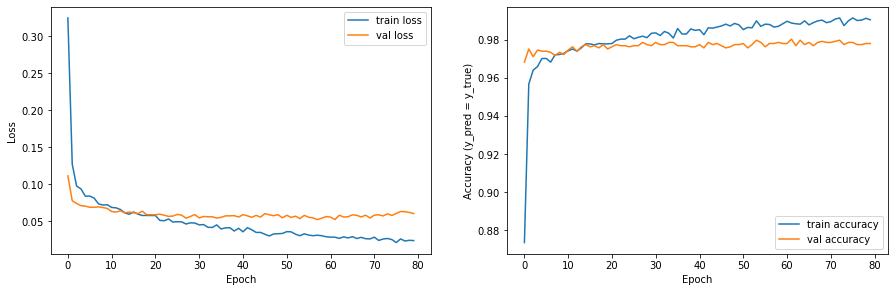

In [46]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [47]:
# count sig/bkg examples in the test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

## Test set performance plots

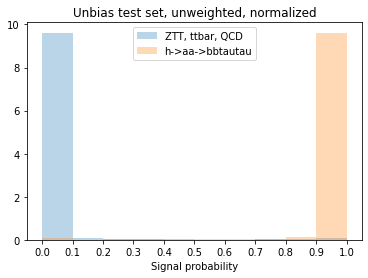

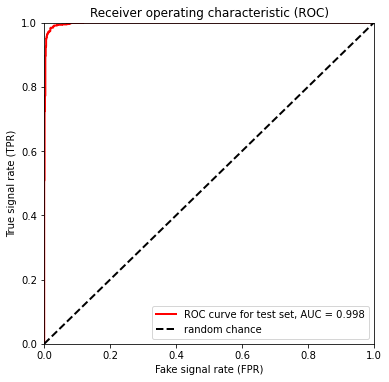

Test loss, test accuracy: [0.0692547131415611, 0.981566846370697]


In [48]:
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'ZTT, ttbar, QCD')
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.legend(loc = 'upper center')
pyplot.title('Unbias test set, unweighted, normalized')
pyplot.xlabel('Signal probability')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Prediction on the observed data set

In [ ]:
pyplot.hist(model.predict(X_obs), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Observed data')
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'ZTT, ttbar, QCD (MC test set)', histtype = 'step')
#pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 1.0, label = 'h->aa->bbtautau (MC test set)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Model prediction on observed data set, normalized')
pyplot.xlabel('Predicted probability of being a signal event')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.show()

# Write model prediction to root files

## Load all root files one by one

In [49]:
from root_numpy import array2root

infolder = 'root_raw/mt18_raw/'
outfolder = 'root_outputs/mt18_outputs/'

inpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths)):
    inpaths[i] = infolder + inpaths[i]
    outpaths[i] = outfolder + outpaths[i]

allfiles = []
for i in range(len(inpaths)):
    allfiles.append(ROOT.RDataFrame('mutau_tree', inpaths[i]))


for i in range(len(allfiles)):
    allfiles[i] = allfiles[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
print(len(allfiles))

46


## Data pre-processing

In [50]:
for i in range(len(allfiles)):
    allfiles[i] = pd.DataFrame(allfiles[i].AsNumpy(feature_list))
    allfiles[i] = allfiles[i].values
    allfiles[i] = scaler.transform(allfiles[i])
    print(inpaths[i])

root_raw/mt18_raw/DY.root
root_raw/mt18_raw/DY1.root
root_raw/mt18_raw/DY2.root
root_raw/mt18_raw/DY3.root
root_raw/mt18_raw/DY4.root
root_raw/mt18_raw/GGHTT.root
root_raw/mt18_raw/GGHWW.root
root_raw/mt18_raw/GGZHLLTT.root
root_raw/mt18_raw/GGZHNNTT.root
root_raw/mt18_raw/GGZHQQTT.root
root_raw/mt18_raw/GGZHWW.root
root_raw/mt18_raw/ST_tW_antitop.root
root_raw/mt18_raw/ST_tW_top.root
root_raw/mt18_raw/ST_t_antitop.root
root_raw/mt18_raw/ST_t_top.root
root_raw/mt18_raw/TTTo2L2Nu.root
root_raw/mt18_raw/TTToHadronic.root
root_raw/mt18_raw/TTToSemiLeptonic.root
root_raw/mt18_raw/VBFHTT.root
root_raw/mt18_raw/VBFHWW.root
root_raw/mt18_raw/VV2L2Nu.root
root_raw/mt18_raw/WZ2L2Q.root
root_raw/mt18_raw/WZ3LNu.root
root_raw/mt18_raw/WminusHTT.root
root_raw/mt18_raw/WminusHWW.root
root_raw/mt18_raw/WplusHTT.root
root_raw/mt18_raw/WplusHWW.root
root_raw/mt18_raw/ZHTT.root
root_raw/mt18_raw/ZHWW.root
root_raw/mt18_raw/ZZ2L2Q.root
root_raw/mt18_raw/ZZ4L.root
root_raw/mt18_raw/data_obs.root
root_raw

## Feed to NN and write outputs to root files

In [51]:
for i in range(len(allfiles)):
    y_pred = model.predict(allfiles[i])
    y_pred = np.array(y_pred, dtype = [('pred_2b', np.float32)])
    array2root(y_pred, filename = outpaths[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths[i])

root_outputs/mt18_outputs/DY.root
root_outputs/mt18_outputs/DY1.root
root_outputs/mt18_outputs/DY2.root
root_outputs/mt18_outputs/DY3.root
root_outputs/mt18_outputs/DY4.root
root_outputs/mt18_outputs/GGHTT.root
root_outputs/mt18_outputs/GGHWW.root
root_outputs/mt18_outputs/GGZHLLTT.root
root_outputs/mt18_outputs/GGZHNNTT.root
root_outputs/mt18_outputs/GGZHQQTT.root
root_outputs/mt18_outputs/GGZHWW.root
root_outputs/mt18_outputs/ST_tW_antitop.root
root_outputs/mt18_outputs/ST_tW_top.root
root_outputs/mt18_outputs/ST_t_antitop.root
root_outputs/mt18_outputs/ST_t_top.root
root_outputs/mt18_outputs/TTTo2L2Nu.root
root_outputs/mt18_outputs/TTToHadronic.root
root_outputs/mt18_outputs/TTToSemiLeptonic.root
root_outputs/mt18_outputs/VBFHTT.root
root_outputs/mt18_outputs/VBFHWW.root
root_outputs/mt18_outputs/VV2L2Nu.root
root_outputs/mt18_outputs/WZ2L2Q.root
root_outputs/mt18_outputs/WZ3LNu.root
root_outputs/mt18_outputs/WminusHTT.root
root_outputs/mt18_outputs/WminusHWW.root
root_outputs/mt18_